Look into initial results with CLASP+CLUBB_MF

In [1]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import os
import pickle
import time
import warnings
from datetime import date, timedelta
import Ngl
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import metpy.calc as mpc
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from matplotlib.dates import DateFormatter
from metpy.units import units
from metpy import interpolate
from metpy.calc import vertical_velocity
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings('ignore')


## A few useful functions

In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [3]:
def interpolateToPressure_v2(DS, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DS.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DS.hyam.values)[:]
    hybm = np.squeeze(DS.hybm.values)[:]
    hyai = np.squeeze(DS.hyai.values)[:]
    hybi = np.squeeze(DS.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

In [4]:
def interpolateToPressure_v2_h2(DS, DSctrl, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DSctrl.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DSctrl.hyam.values)[:]
    hybm = np.squeeze(DSctrl.hybm.values)[:]
    hyai = np.squeeze(DSctrl.hyai.values)[:]
    hybi = np.squeeze(DSctrl.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DSctrl.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

In [5]:
def interpolateToPressure_v2_h3(DS, DSctrl, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DSctrl.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DSctrl.hyam.values)[:]
    hybm = np.squeeze(DSctrl.hybm.values)[:]
    hyai = np.squeeze(DSctrl.hyai.values)[:]
    hybi = np.squeeze(DSctrl.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DSctrl.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)
 
    ## Handle data that's by-plume *and* by subcycle for EDMF output
    elif np.shape(DS[varName].values)[2]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.ncyc.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            for iCyc in range(len(DS.ncyc.values)):
                varInterp[:,iCyc,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iCyc,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

            
    saveOut = varInterp
    
    return saveOut

In [6]:
def process_camData(DS):
    ## Add evaporative fraction to DS 
    ds_EF = DS.LHFLX.values / (DS.LHFLX.values + DS.SHFLX.values)
    DS['EvapFraction'] = (('time'), np.squeeze(ds_EF))

    ## Define the actual vertical velocity skew, not just the third order moment 
    skw_W = DS.WP3_CLUBB.values / ((DS.WP2_CLUBB.values)**1.5)
    DS['Skw_W'] = (('time','ilev'), np.squeeze(skw_W))

    ## Add in TKE 
    DS['TKE']  = (('time','ilev','lat,','lon'),
                       0.5*(DS['UP2_CLUBB']+DS['VP2_CLUBB']+DS['WP2_CLUBB'])) 
    # DS['TKE'].attrs['units']   = 'm2/s2'
    # DS['TKE'].attrs['long_name']   = 'Turbulent Kinetic Energy'
    
    ## Add in wind speed 
    DS['WindMagnitude']  = (('time','lev','lat,','lon'),
                                    np.sqrt((DS.U.values**2.0) + (DS.V.values**2.0)) )
    
    # DS['WindMagnitude'].attrs['units']   = 'm/s'
    # DS['WindMagnitude'].attrs['long_name']   = 'Wind speed'

    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 

#     p0mb   = DS.P0.values/100        # mb 
#     hyam   = np.squeeze(DS.hyam.values)[:]
#     hybm   = np.squeeze(DS.hybm.values)[:]
#     pnew64 = p0mb*hyam + p0mb*hybm
#     pnew64 = pnew64[20:-4]
    
    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WPRTP_CLUBB','WPTHLP_CLUBB','WP3_CLUBB','WP2_CLUBB','UP2_CLUBB',
                          'VP2_CLUBB','TKE','Z3','U','V','T','Q','OMEGA','RVMTEND_CLUBB','STEND_CLUBB','CLDLIQ','CLOUD','CLOUDFRAC_CLUBB',
                          'UPWP_CLUBB','THETAL','WindMagnitude','CONCLD','QT','GCLDLWP',
#                           'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl','edmf_cloudfrac','edmf_dnw','edmf_precc',
#                           'edmf_upbuoy','edmf_updet','edmf_upent',
#                           ## Add budget terms 
                          # 'thlp2','thlp2_bt','thlp2_cl','thlp2_dp1','thlp2_dp2','thlp2_forcing','thlp2_ma','thlp2_mc','thlp2_pd',
                          # 'thlp2_sf','thlp2_ta','thlp2_tp','thlp2_zt', 
#                           'wp2','wp2_ac','wp2_bp','wp2_bt','wp2_cl','wp2_dp1','wp2_dp2','wp2_ma', 'wp2_pd','wp2_pr1','wp2_pr2',
#                           'wp2_pr3','wp2_sf','wp2_ta','wp2_zt',
                          'wpthlp','wprtp','rtp2',
                          'thlm','rtm','wm_zm','rtm_zm','thlm_zm',
                          # 'wp2rcp','wp2rtp','wp2thlp','wp2thvp','wp3_on_wp2','wp3_on_wp2_zt','wprtp',
                          # 'wprtp2','wprtp_ac','wprtp_bp','wprtp_bt','wprtp_cl','wprtp_dp1','wprtp_enter_mfl','wprtp_exit_mfl',
                          # 'wprtp_forcing','wprtp_ma','wprtp_mc','wprtp_mfl','wprtp_mfl_max','wprtp_mfl_min','wprtp_pd',
                          # 'wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_sicl','wprtp_ta','wprtp_tp','wprtp_zt',
                          # 'wprtpthlp','wpthlp','wpthlp2','wpthlp_ac','wpthlp_bp','wpthlp_bt','wpthlp_cl','wpthlp_dp1','wpthlp_entermfl',
                          # 'wpthlp_exit_mfl','wpthlp_forcing','wpthlp_ma','wpthlp_mc','wpthlp_mfl','wpthlp_mfl_max','wpthlp_mfl_min',
                          # 'wpthlp_pr1','wpthlp_pr2','wpthlp_pr3','wpthlp_sicl','wpthlp_ta','wpthlp_tp','wpthlp_zt'
                          ])

    for iVar in range(len(varSels)): 
        # varUnits = DS[varSels[iVar]].units
        # varName  = DS[varSels[iVar]].long_name

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2(DS, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        # DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        # DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

    # - - - - - - - - - - - - - - - - - - - - - - - -
      
#     ## Resample to 30m means? 
#     DS = DS.resample(time="30Min").mean()

    ## Compute vertical velocity as m/s rather than Pa/s 
    w_mps = vertical_velocity( np.squeeze(DS['OMEGA_interp'].values)*units('Pa/s'), 
                               np.squeeze(DS['levInterp'].values)*units.hPa, 
                               np.squeeze(DS['T_interp'].values)*units.K )
    w_mps_save = np.full([len(DS.time.values), 
                      len(DS.levInterp.values), 
                      len(DS.lat.values), 
                      len(DS.lon.values)], np.nan)
    w_mps_save[:,:,0,0] = w_mps
    
    DS['w_mps'] = ( ('time','levInterp','lat,','lon'), w_mps_save)
        
    return DS

In [7]:
def process_camData_h2(DS, DSctrl):
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 

#     p0mb   = DSctrl.P0.values/100        # mb 
#     hyam   = np.squeeze(DSctrl.hyam.values)[:]
#     hybm   = np.squeeze(DSctrl.hybm.values)[:]
#     pnew64 = p0mb*hyam + p0mb*hybm
#     pnew64 = pnew64[20:-4]
    
    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray([
                          'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl',
                          'edmf_cloudfrac','edmf_dnw','edmf_precc',
                          'edmf_qtflxup','edmf_thlflxup',
                          'edmf_S_ATHLTHL','edmf_S_AQTQT','edmf_S_AWW',
                           # Variables in Lopt6 case
#                            'edmf_ent','edmf_upent','edmf_updet','edmf_upbuoy',
                           ])
    
#     ## Get averages for ensembles that don't include zeros.... 
#     nTime = len(DS.time.values)

#     for iT in range(nTime):
#         selDS_h2 = scamDS_h2.isel(case=iCase, time=iT, lat=0, lon=0)

#         for iL in range(len(scamDS_h2.ilev.values)):
#             ivalPlumes = np.where( (selDS_h2.edmf_upthl.values!=0) &   # [ens,ilev]
#                                    (np.isfinite(selDS_h2.edmf_upthl.values)==True)
#                                    (selDS_h2.edmf_upa.values!=0) )[0]


    for iVar in range(len(varSels)): 
        # varUnits = DS[varSels[iVar]].units
        # varName  = DS[varSels[iVar]].long_name

#         print('Working on variable... ', varSels[iVar])
        
        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2_h2(DS, DSctrl, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        # DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        # DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

        
#     ## Resample to 30m means? 
#     DS = DS.resample(time="30Min").mean()
        
    return DS

In [8]:
def process_camData_h3(DS, DSctrl):
    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 

#     p0mb   = DSctrl.P0.values/100        # mb 
#     hyam   = np.squeeze(DSctrl.hyam.values)[:]
#     hybm   = np.squeeze(DSctrl.hybm.values)[:]
#     pnew64 = p0mb*hyam + p0mb*hybm
#     pnew64 = pnew64[20:-4]
    
    DS = DS.assign_coords({"levInterp": pnew64})
    varSels = np.asarray([
                          'up_macmic1','up_macmic2','dn_macmic1','dn_macmic2',
                        'upa_macmic1','upa_macmic2','dna_macmic1','dna_macmic2',
                        'thlu_macmic1','thlu_macmic2','qtu_macmic1','qtu_macmic2',
                        'thld_macmic1','thld_macmic2','qtd_macmic1','qtd_macmic2',
                           ])
    
    for iVar in range(len(varSels)): 

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2_h3(DS, DSctrl, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==6: 
            DS[varSels[iVar]+'_interp']  = (('time','ncyc','nens','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        # DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        # DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

        
#     ## Resample to 30m means? 
#     DS = DS.resample(time="30Min").mean()
        
    return DS

In [9]:
def preprocess_h0(ds):
    
#     keepVars = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
#                 'U10','CLDHGH','CLDLIQ','CONCLD','TMQ','P0','hyam','hybm','hyai','hybi',
#                 ## Add budget terms 
#                 # 'thlp2','thlp2_bt','thlp2_cl','thlp2_dp1','thlp2_dp2','thlp2_forcing','thlp2_ma','thlp2_mc','thlp2_pd',
#                 # 'thlp2_sf','thlp2_ta','thlp2_tp','thlp2_zt', 
#                 'wp2','wp2_ac','wp2_bp','wp2_bt','wp2_cl','wp2_dp1','wp2_dp2','wp2_ma', 'wp2_pd','wp2_pr1','wp2_pr2',
#                 'wp2_pr3','wp2_sf','wp2_ta','wp2_zt',
#                 'wpthlp','wprtp',
#                 # 'wp2rcp','wp2rtp','wp2thlp','wp2thvp','wp3_on_wp2','wp3_on_wp2_zt','wprtp',
#                 # 'wprtp2','wprtp_ac','wprtp_bp','wprtp_bt','wprtp_cl','wprtp_dp1','wprtp_enter_mfl','wprtp_exit_mfl',
#                 # 'wprtp_forcing','wprtp_ma','wprtp_mc','wprtp_mfl','wprtp_mfl_max','wprtp_mfl_min','wprtp_pd',
#                 # 'wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_sicl','wprtp_ta','wprtp_tp','wprtp_zt',
#                 # 'wprtpthlp','wpthlp','wpthlp2','wpthlp_ac','wpthlp_bp','wpthlp_bt','wpthlp_cl','wpthlp_dp1','wpthlp_entermfl',
#                 # 'wpthlp_exit_mfl','wpthlp_forcing','wpthlp_ma','wpthlp_mc','wpthlp_mfl','wpthlp_mfl_max','wpthlp_mfl_min',
#                 # 'wpthlp_pr1','wpthlp_pr2','wpthlp_pr3','wpthlp_sicl','wpthlp_ta','wpthlp_tp','wpthlp_zt'
#                 ]
    
    keepVars = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
                'U10','CLDHGH','CLDLIQ','CONCLD','TMQ','P0','hyam','hybm','hyai','hybi',
                'PHIS','USTAR','QT','GCLDLWP',
#                 'WPRTP2_CLUBB','WPTHLP2_CLUBB','WP2RTP_CLUBB','WP2THLP_CLUBB','WPRTPTHLP_CLUBB',
#                 'WP2THLP_CLUBB','WPTHLP2_CLUBB','WPRTPTHLP_ZM_CLUBB',
#                 'WP4_CLUBB','WPRTP2_ZM_CLUBB','WPTHLP2_ZM_CLUBB','WP2RTP_ZM_CLUBB','WP2THLP_ZM_CLUBB',
                'THETAL','CDNUMC','CLDBOT','CLDLOW',
                'CLDMED','CLDTOP','CLDTOT','THLP2_CLUBB','CLOUDCOVER_CLUBB','CLOUDFRAC_CLUBB',
                'RCM_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','UP2_CLUBB','UPWP_CLUBB',
                'VP2_CLUBB','T','Q','OMEGA','PBLH','U','V','WP2_CLUBB','WP3_CLUBB','WPRCP_CLUBB',
                'WPRTP_CLUBB',
                'WPTHLP_CLUBB','WPTHVP_CLUBB','Z3','PRECT','PRECC',
                # 'PRECZ',
                'TGCLDCWP','TGCLDLWP','GCLDLWP',
                'LHFLX','SHFLX','TREFHT','RHREFHT']
        
    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars]

    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
#     ## Set some limits for hours? 
#     hrStart = 5
#     hrEnd   = 21

#     iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
#     dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean().dropna(dim='time')
    dsSel = dsSel.load()

    
        
    return dsSel

In [10]:
def preprocess_h1(ds):
    
    keepVars = [
#                 'thlp2','thlp2_bt','thlp2_cl','thlp2_dp1','thlp2_dp2','thlp2_forcing','thlp2_ma','thlp2_mc','thlp2_pd',
#                 'thlp2_sf','thlp2_ta','thlp2_tp','thlp2_zt', 
#                 'wp2','wp2_ac','wp2_bp','wp2_bt','wp2_cl','wp2_dp1','wp2_dp2','wp2_ma', 'wp2_pd','wp2_pr1','wp2_pr2',
#                 'wp2_pr3','wp2_sf','wp2_ta','wp2_zt',
                'wpthlp','wprtp','rtp2',
                'thlm','rtm','wm_zm','rtm_zm','thlm_zm',
#                 'wp2rcp','wp2rtp','wp2thlp','wp2thvp','wp3_on_wp2','wp3_on_wp2_zt','wprtp',
#                 'wprtp2','wprtp_ac','wprtp_bp','wprtp_bt','wprtp_cl','wprtp_dp1','wprtp_enter_mfl','wprtp_exit_mfl',
#                 'wprtp_forcing','wprtp_ma','wprtp_mc','wprtp_mfl','wprtp_mfl_max','wprtp_mfl_min','wprtp_pd',
#                 'wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_sicl','wprtp_ta','wprtp_tp','wprtp_zt',
#                 'wprtpthlp','wpthlp','wpthlp2','wpthlp_ac','wpthlp_bp','wpthlp_bt','wpthlp_cl','wpthlp_dp1','wpthlp_entermfl',
#                 'wpthlp_exit_mfl','wpthlp_forcing','wpthlp_ma','wpthlp_mc','wpthlp_mfl','wpthlp_mfl_max','wpthlp_mfl_min',
#                 'wpthlp_pr1','wpthlp_pr2','wpthlp_pr3','wpthlp_sicl','wpthlp_ta','wpthlp_tp','wpthlp_zt'
                ]
        
    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars]

    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
#     ## Set some limits for hours? 
#     hrStart = 5
#     hrEnd   = 21

#     iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
#     dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean().dropna(dim='time')
    dsSel = dsSel.load()

    
        
    return dsSel

In [11]:
def preprocess_h2(ds):
    
    varSels = np.asarray([
                      'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl','edmf_cloudfrac','edmf_dnw',
                      'edmf_precc','edmf_uplh',
                       # These are only there for the Lopt6 case right now 
#                       'edmf_ent','edmf_upent','edmf_updet','edmf_upbuoy',
                       ])

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds[varSels].isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
#     ## Set some limits for hours? 
#     hrStart = 5
#     hrEnd   = 21

#     iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
#     dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Replacing 'missing' updraft values with NaN 
    dsSel   = dsSel.where(dsSel['edmf_upthl'] != 0.0)
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean(dim='time', skipna=True).dropna(dim='time')
    dsSel = dsSel.load()

    
    return dsSel


def preprocess_h2_2d(ds):
    
    varSels = np.asarray([
                      'edmf_cloudfrac','edmf_qtflxup','edmf_thlflxup','edmf_precc',
                      'edmf_S_ATHLTHL','edmf_S_AQTQT','edmf_S_AWW',
                      # These are only there for the Lopt6 case right now 
#                       'edmf_L0',
                       ])

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds[varSels].isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
#     ## Set some limits for hours? 
#     hrStart = 5
#     hrEnd   = 21

#     iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
#     dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Replacing 'missing' updraft values with NaN 
#     dsSel   = dsSel.where(dsSel['edmf_upthl'] != 0.0)
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean(dim='time', skipna=True).dropna(dim='time')
    dsSel = dsSel.load()

    
    return dsSel

In [12]:
def preprocess_h3(ds):

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
#     ## Set some limits for hours? 
#     hrStart = 5
#     hrEnd   = 21

#     iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
#     dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Replacing 'missing' updraft values with NaN 
    dsSel   = dsSel.where(dsSel['thlu_macmic2'] != 0.0)
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean(dim='time', skipna=True).dropna(dim='time')
    dsSel = dsSel.load()

    
    return dsSel

In [13]:
## Pre-processing to get CLM data

def preprocessCLM_h0(ds):
    
    keepVars_CLM = ['SOILWATER_10CM','TSOI_10CM','RAIN','FSA','TG','TSA',
                    'QVEGT','QVEGE','QSOIL','H2OSOI','TSOI','SOILLIQ']

    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars_CLM]
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
#     ## Set some limits for hours? 
#     hrStart = 5
#     hrEnd   = 21

#     iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
#     dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean().dropna(dim='time')
    dsSel = dsSel.load()

    return dsSel



In [14]:
## Pre-processing to get CLM data

def preprocessCLM_h1(ds):
    
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
#     ## Set some limits for hours? 
#     hrStart = 5
#     hrEnd   = 21

#     iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
#     dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    QFLX = dsSel.QSOIL+dsSel.QVEGE+dsSel.QVEGT
    dsSel['QFLX'] = (('time','pft'), QFLX)
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean()
    dsSel = dsSel.load()

    
    return dsSel


For plotting

In [15]:
def getStatSigCI(nTimes, nLevs, varSel, ctrlCase, testCase): 

    ## Get ranges for each case's CI 
    ctrlDS_lowCI    = lowCI.sel(case=ctrlCase)[varSel]
    testDS_lowCI    = lowCI.sel(case=testCase)[varSel]

    ctrlDS_hghCI    = hghCI.sel(case=ctrlCase)[varSel]
    testDS_hghCI    = hghCI.sel(case=testCase)[varSel]

    levSig = np.full([nTimes, nLevs], np.nan)

    for iHr in range(nTimes): 
        for iLev in range(nLevs):

            # Not significant range?
            if ( (testDS_lowCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_lowCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (testDS_hghCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_hghCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            
            elif ( (ctrlDS_lowCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_lowCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (ctrlDS_hghCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_hghCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0            
            
            
            else:
                levSig[iHr, iLev] = 1 
    
    return levSig

In [16]:
def getStatSigCI_h2(nTimes, nLevs, varSel, ctrlCase, testCase): 

    ## Get ranges for each case's CI 
    ctrlDS_lowCI    = lowCI_h2.sel(case=ctrlCase)[varSel]
    testDS_lowCI    = lowCI_h2.sel(case=testCase)[varSel]

    ctrlDS_hghCI    = hghCI_h2.sel(case=ctrlCase)[varSel]
    testDS_hghCI    = hghCI_h2.sel(case=testCase)[varSel]

    levSig = np.full([nTimes, nLevs], np.nan)

    for iHr in range(nTimes): 
        for iLev in range(nLevs):

            # Not significant range?
            if ( (testDS_lowCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_lowCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (testDS_hghCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_hghCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            
            elif ( (ctrlDS_lowCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_lowCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (ctrlDS_hghCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_hghCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0       
            
            elif np.isfinite(testDS_lowCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0
            elif np.isfinite(ctrlDS_lowCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0            
            elif np.isfinite(testDS_hghCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0
            elif np.isfinite(ctrlDS_hghCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0  
                
            else:
                levSig[iHr, iLev] = 1 
    
    return levSig

In [17]:
def getMaxValHeightTime(DS,varName, maxLev,levName,timeName):
    iMax = np.where(DS[levName].values>=maxLev)[0]
    DS   = DS.isel(levInterp=iMax.astype(int))
    
    maxValTemp = np.nanmax(np.squeeze(DS[varName].values))
    minValTemp = np.nanmin(np.squeeze(DS[varName].values))
    
    if np.abs(maxValTemp)>np.abs(minValTemp):
        maxVal = maxValTemp
    elif np.abs(maxValTemp)<np.abs(minValTemp):
        maxVal = minValTemp
    else: 
        maxVal = maxValTemp
        
    iMax = np.where(DS[varName].values == maxVal)
    hgtMax = DS[levName].values[iMax[1]]
    timeMax = DS[timeName].values[iMax[0]]
    
    return maxVal, hgtMax, timeMax

## Read in data

**Single column CAM and CLM data**

In [18]:
# archiveDir  = '/scratch/cluster/mdfowler/tempOutput_claspMF/'
testDir     = '/scratch/cluster/mdfowler/defaultSfc_L0eq250/'

case_names  = [
               'clubbMF',
               'clasp+MF',
              ]

caseStart = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_'

caseStrings = [
                'usePatchDataFALSE_setSfcFlxFALSE_realSfc_L0eq250_moreOnWarmestPatch.',
                'usePatchDataTRUE_setSfcFlxFALSE_realSfc_L0eq250_moreOnWarmestPatch.',   
                ]

for iCase in range(len(case_names)):
    print('*** Starting on case %s ***' % (case_names[iCase]))

    ## Get list of files 
    listFiles_h0 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h0*'))
    listFiles_h1 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h1*'))
    listFiles_h2 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h2*'))
    listFiles_h3 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h3*'))

    listFilesCLM_h1 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*clm2.h1*'))
    listFilesCLM_h0 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*clm2.h0*'))        

    case_h0 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h0 files loaded')
    case_h1 = xr.open_mfdataset(listFiles_h1,  preprocess=preprocess_h1, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h1 files loaded')
    case_h2 = xr.open_mfdataset(listFiles_h2,  preprocess=preprocess_h2, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h2 files loaded with mfdataset')
    case_h2_2d = xr.open_mfdataset(listFiles_h2,  preprocess=preprocess_h2_2d, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h2 2D data loaded with mfdataset')
    
    case_h3 = xr.open_mfdataset(listFiles_h3,  preprocess=preprocess_h3, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h3 files loaded with mfdataset')
        
    # Merge cases and load
    caseFull = xr.merge([case_h1, case_h0])
    caseFull = caseFull.assign_coords({"nens": np.arange(len(case_h2.nens.values))})
    
    caseH2   = xr.merge([case_h2, case_h2_2d])
    caseH2   = caseH2.assign_coords({"nens": np.arange(len(case_h2.nens.values))})
    
    caseH3   = case_h3.assign_coords({"nens": np.arange(len(case_h2.nens.values))})
    caseH3   = caseH3.assign_coords({"ncyc": np.arange(len(case_h3.ncyc.values))})
    del case_h0,case_h1,case_h2,case_h2_2d,case_h3

    print('DS merged and loaded')
    
    ## Process data 
    procDS    = process_camData( caseFull )
    del caseFull
    procDS_h2 = process_camData_h2( caseH2, procDS  )
    del caseH2
    procDS_h3 = process_camData_h3( caseH3, procDS  )
    del caseH3
            
    ## Combine all the cases into 
    case_allDays      = procDS.squeeze().assign_coords({"case":  case_names[iCase]})
    h2_allDays        = procDS_h2.squeeze().assign_coords({"case":  case_names[iCase]})
    h3_allDays        = procDS_h3.squeeze().assign_coords({"case":  case_names[iCase]})
                        
    if iCase==0:
        scamDS    = case_allDays
        del case_allDays
        scamDS_h2 = h2_allDays
        del h2_allDays
        scamDS_h3 = h3_allDays
        del h3_allDays
    else: 
        scamDS    = xr.concat([scamDS, case_allDays], "case") 
        del case_allDays
        scamDS_h2 = xr.concat([scamDS_h2, h2_allDays], "case") 
        del h2_allDays
        scamDS_h3 = xr.concat([scamDS_h3, h3_allDays], "case") 
        del h3_allDays
            
    ## Read in CLM datasets too 
 
 #    caseCLM_h0 = xr.open_mfdataset(listFilesCLM_h0,  preprocess=preprocessCLM_h0, concat_dim='time', 
#                                 combine='nested', decode_times=True, 
#                                 data_vars='minimal')
#     print('CLM_h0 files loaded with mfdataset')

    caseCLM_h1 = xr.open_mfdataset(listFilesCLM_h1,  preprocess=preprocessCLM_h1, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal')
    print('CLM_h1 files loaded with mfdataset')

#     caseCLMh0_allDays = caseCLM_h0.assign_coords({"case":  case_names[iCase]})
    caseCLMh1_allDays = caseCLM_h1.assign_coords({"case":  case_names[iCase]})

    if iCase==0:
#         clmDS_h0 = caseCLMh0_allDays
        clmDS_h1 = caseCLMh1_allDays
    else: 
#         clmDS_h0 = xr.concat([clmDS_h0, caseCLMh0_allDays], "case") 
        clmDS_h1 = xr.concat([clmDS_h1, caseCLMh1_allDays], "case") 
    del caseCLMh1_allDays
    print('Done with CLM files')
            
    print('Done with case %i of %i ' % (iCase+1, len(case_names)))
        

*** Starting on case clubbMF ***
h0 files loaded
h1 files loaded
h2 files loaded with mfdataset
h2 2D data loaded with mfdataset
h3 files loaded with mfdataset
DS merged and loaded
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
CLM_h1 files loaded with mfdataset
Done with CLM files
Done with case 1 of 2 
*** Starting on case clasp+MF ***
h0 files loaded
h1 files loaded
h2 files loaded with mfdataset
h2 2D data loaded with mfdataset
h3 files loaded with mfdataset
DS merged and loaded
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
CLM_h1 files loaded with mfdataset
Done with CLM files
Done with case 2 of 2 


In [19]:
print('CLM times: ', len(clmDS_h1.time.values))
print('CAM times: ', len(scamDS_h2.time.values))


CLM times:  21312
CAM times:  21312


**Patch labels?**

In [28]:
print('itype_veg   itype_col   itypelunit   wtg_cell         label?               iTile\n')

labels = ['BareGround','NeedleleafEvergreen','BroadleafDeciduous','C3grass','C4grass','rainCrop','irrCrop',
          'urb_hd','urb_hd','urb_hd','urb_hd','urb_hd',
          'urb_md','urb_md','urb_md','urb_md','urb_md']

for iTile in range(len(clmDS_h1.sel(case='clasp+MF').isel(time=1).pfts1d_itype_veg.values)):
    print('%6i %10i %10i %15.4f %22s, %10i' % (clmDS_h1.pfts1d_itype_veg.values[1, iTile], 
          clmDS_h1.pfts1d_itype_col.values[1, iTile],
          clmDS_h1.pfts1d_itype_lunit.values[1, iTile],
          clmDS_h1.pfts1d_wtgcell.values[1, iTile], 
          labels[iTile],iTile,
                                   ) )


itype_veg   itype_col   itypelunit   wtg_cell         label?               iTile

     0          1          1          0.0032             BareGround,          0
     1          1          1          0.0015    NeedleleafEvergreen,          1
     7          1          1          0.0066     BroadleafDeciduous,          2
    13          1          1          0.2556                C3grass,          3
    14          1          1          0.2217                C4grass,          4
    15        215          2          0.4874               rainCrop,          5
    16        216          2          0.0226                irrCrop,          6
     0         71          8          0.0000                 urb_hd,          7
     0         72          8          0.0000                 urb_hd,          8
     0         73          8          0.0000                 urb_hd,          9
     0         74          8          0.0000                 urb_hd,         10
     0         75          8          

In [37]:
plumeLabel = np.full([len(scamDS_h2.case.values), len(scamDS_h2.time.values), len(scamDS_h2.nens.values)], 'SurfaceAvg')

sigDig = 9

for iT in range(len(clmDS_h1.time.values)-1):

    # Sel time QFLX and edmf_uplh 
    this_uplh = scamDS_h2.sel(case='clasp+MF').isel(time=iT, ilev=-1).edmf_uplh.values
    this_qflx = clmDS_h1.sel(case='clasp+MF').isel(time=iT).QFLX 
    this_upa  = scamDS_h2.sel(case='clasp+MF').isel(time=iT, ilev=-1).edmf_upa.values
    
    for iLabel in range(len(labels)):
        iPatchMatch = np.where(np.around(this_uplh, sigDig) == np.around(this_qflx.values[iLabel],sigDig))[0]
        
        plumeLabel[1, iT, iPatchMatch] = labels[iLabel]
        
    #Urban HD mean: 
    iUrbHD  = np.where(labels=='urb_hd')[0]
    urbHDMean = np.nansum(this_qflx.values[iUrbHD]*clmDS_h1.sel(case='clasp+MF').isel(time=iT).pfts1d_wtgcell.values[iUrbHD])/np.nansum(clmDS_h1.sel(case='clasp+MF').isel(time=iT).pfts1d_wtgcell.values[iUrbHD])
    iPatchMatch_UrbanHD  = np.where(np.around(this_uplh, sigDig) == np.around(urbHDMean,sigDig))[0] 
    plumeLabel[1, iT, iPatchMatch_UrbanHD] = 'urban HD' 
    
    ## TODO: For safety, since using a round off digit, should confirm that things aren't being marked as two PFTs 

    ## Also fill in if the plume is not active...
    this_upa  = scamDS_h2.sel(case='clasp+MF').isel(time=iT, ilev=-1).edmf_upa.values
    iMiss     = np.where(this_upa==0.0)[0]
    plumeLabel[1, iT, iMiss]  = 'Off'

    ## Also fill in if the plume is not active in HOM case
    this_upa  = scamDS_h2.sel(case='clubbMF').isel(time=iT, ilev=-1).edmf_upa.values
    iMiss2    = np.where(this_upa==0.0)[0]
    plumeLabel[0, iT, iMiss2]  = 'Off'



In [38]:
scamDS_h2['plumeLabel'] = (('case','time','nens'), plumeLabel)

In [31]:
print(plumeLabel[1, 0:50,:])

[['urb_md' 'urb_md' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off']
 ['urb_md' 'urb_md' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off']
 ['urb_md' 'urb_md' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off']
 ['urb_md' 'urb_md' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off']
 ['urb_md' 'urb_md' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off']
 ['urb_md' 'urb_md' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off']
 ['urb_md' 'urb_md' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off']
 ['urb_md' 'urb_md' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off']
 ['urb_md' 'urb_md' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off']
 ['urb_md' 'urb_md' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off']
 ['urb_md' 'urb_md' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off']
 ['urb_md' 'urb_md' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off']
 ['urb_md' 'urb_md' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off']
 ['urb_md' 'urb_md' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off' 'Off']
 ['urb_md' 'urb_md' 'Off' 'Off' 'O

In [39]:
np.unique(plumeLabel[1, :,:])

array(['BroadleafD', 'C3grass', 'C4grass', 'Needleleaf', 'Off',
       'SurfaceAvg', 'irrCrop', 'rainCrop', 'urb_md'], dtype='<U10')

In [25]:
# iT=10

# # Sel time QFLX and edmf_uplh 
# this_uplh = scamDS_h2.sel(case='clasp+MF').isel(time=iT, ilev=-1, lat=0, lon=0).edmf_uplh.values
# this_qflx = clmDS_h1.sel(case='clasp+MF').isel(time=iT).QFLX 
# this_upa  = scamDS_h2.sel(case='clasp+MF').isel(time=iT, ilev=-1, lat=0, lon=0).edmf_upa.values
# urbMean = np.nansum(this_qflx.values[2:-1]*clmDS_h1.sel(case='clasp+MF').isel(time=iT).pfts1d_wtgcell.values[2:-1])/np.nansum(clmDS_h1.sel(case='clasp+MF').isel(time=iT).pfts1d_wtgcell.values[2:-1])
 
# print('uplh: ', this_uplh)
# print('qflx: ', this_qflx)
# print('UrbMean: ',urbMean)

**Figure out how to use the subcycle output well**

In [42]:
# # Parallel loop over time 
# def computeSumMacmic_parallel(recArray1, recArray2):
        
#     total_var = np.full([len(recArray1.levInterp.values)], np.nan)
    
#     for iLev in range(len(recArray1.levInterp.values)):
#         part1 = recArray1.isel(levInterp=iLev) 
#         part2 = recArray2.isel(levInterp=iLev)
        
#         if ((np.isfinite(part1.values)==False) & (np.isfinite(part2.values)==False)):
#             total_var[iLev] = np.nan
#         else:
#             total_var[iLev] = np.nansum([part1.values, part2.values])
    
#     return total_var

**Note:** The way this is working out below, it's fine to take the mean over the new, stacked axis because there's only one cycle in macmic1 and macmic2 with my output frequency. But that's not foolproof!! 

In [33]:
var1    = ['up_macmic1_interp', 'dn_macmic1_interp','upa_macmic1_interp','dna_macmic1_interp',
           'thlu_macmic1_interp','qtu_macmic1_interp','thld_macmic1_interp','qtd_macmic1_interp']

var2    = ['up_macmic2_interp', 'dn_macmic2_interp','upa_macmic2_interp','dna_macmic2_interp',
           'thlu_macmic2_interp','qtu_macmic2_interp','thld_macmic2_interp','qtd_macmic2_interp']

varSave = ['up_macmicAvg_interp', 'dn_macmicAvg_interp','upa_macmicAvg_interp','dna_macmicAvg_interp',
           'thlu_macmicAvg_interp','qtu_macmicAvg_interp','thld_macmicAvg_interp','qtd_macmicAvg_interp']

for iVar in range(len(var1)):
    print('Computing %s' % (varSave[iVar]))
    
    varCyc1 = scamDS_h3[var1[iVar]]
    varCyc2 = scamDS_h3[var2[iVar]]
    
    ## This seems to work... 
    s = np.stack((varCyc1, varCyc2))
#     C = np.nansum(s, axis=0)
    C = np.nanmean(s, axis=0)
    C[np.all(np.isnan(s), axis=0)] = np.nan
    
    scamDS_h2[varSave[iVar]]  = (('case','time','nens','levInterp'), np.squeeze(C))


Computing up_macmicAvg_interp
Computing dn_macmicAvg_interp
Computing upa_macmicAvg_interp
Computing dna_macmicAvg_interp
Computing thlu_macmicAvg_interp
Computing qtu_macmicAvg_interp
Computing thld_macmicAvg_interp
Computing qtd_macmicAvg_interp


In [34]:
del scamDS_h3

In [35]:
## Get number of plumes at each time/level
nPlumesActive = scamDS_h2.thlu_macmicAvg_interp.count(dim='nens')
print(np.shape(nPlumesActive))

scamDS['nPlumesActive'] = (('case','time','levInterp'), nPlumesActive)


(2, 21312, 78)


**IMPORTANT** Check plumes here

In [25]:
# patchLabelsForPlumes = np.array(patchLabelsForPlumes)
# print(patchLabelsForPlumes)

In [36]:
scamDS_h2.plumeLabel

<xarray.DataArray 'plumeLabel' (case: 2, time: 21312, nens: 10)>
array([[['Off', 'Off', 'Off', ..., 'Off', 'Off', 'Off'],
        ['Off', 'Off', 'Off', ..., 'Off', 'Off', 'Off'],
        ['Off', 'Off', 'Off', ..., 'Off', 'Off', 'Off'],
        ...,
        ['Off', 'Off', 'Off', ..., 'Off', 'Off', 'Off'],
        ['Off', 'Off', 'Off', ..., 'Off', 'Off', 'Off'],
        ['SurfaceAvg', 'SurfaceAvg', 'SurfaceAvg', ..., 'SurfaceAvg',
         'SurfaceAvg', 'SurfaceAvg']],

       [['urb_md', 'urb_md', 'Off', ..., 'Off', 'Off', 'Off'],
        ['urb_md', 'urb_md', 'Off', ..., 'Off', 'Off', 'Off'],
        ['urb_md', 'urb_md', 'Off', ..., 'Off', 'Off', 'Off'],
        ...,
        ['urb_md', 'urb_md', 'Off', ..., 'Off', 'Off', 'Off'],
        ['urb_md', 'urb_md', 'Off', ..., 'Off', 'Off', 'Off'],
        ['SurfaceAvg', 'SurfaceAvg', 'SurfaceAvg', ..., 'SurfaceAvg',
         'SurfaceAvg', 'SurfaceAvg']]], dtype='<U10')
Coordinates:
    lat      float64 36.6
    lon      float64 262.5
  * time     (time) datetime64[ns] 2015-06-06T00:03:30 ... 2018-09-18T23:58:30
  * nens     (nens) int64 0 1 2 3 4 5 6 7 8 9
  * case     (case) object 'clubbMF' 'clasp+MF'

In [27]:
grassDS = scamDS_h2.sel(case='clasp+MF').where(scamDS_h2.sel(case='clasp+MF').plumeLabel == 'C3grass')
cropDS  = scamDS_h2.sel(case='clasp+MF').where(scamDS_h2.sel(case='clasp+MF').plumeLabel == 'IrrigCrop')
lakeDS  = scamDS_h2.sel(case='clasp+MF').where(scamDS_h2.sel(case='clasp+MF').plumeLabel == 'Lake')
urbanDS = scamDS_h2.sel(case='clasp+MF').where(scamDS_h2.sel(case='clasp+MF').plumeLabel == 'Urban')


In [28]:
# nPlumesActive_grass = scamDS_h2.thlu_macmicAvg_interp.isel(nens=np.where(patchLabelsForPlumes=='C3grass')[0])
# nPlumesActive_crop  = scamDS_h2.thlu_macmicAvg_interp.isel(nens=np.where(patchLabelsForPlumes=='IrrigCrop')[0])

# if np.any(patchLabelsForPlumes=='UrbnRf'):
#     nPlumesActive_urban = scamDS_h2.thlu_macmicAvg_interp.isel(nens=np.where(patchLabelsForPlumes=='UrbnRf')[0])
# elif np.any(patchLabelsForPlumes=='Urban'):
#     nPlumesActive_urban = scamDS_h2.thlu_macmicAvg_interp.isel(nens=np.where(patchLabelsForPlumes=='Urban')[0])

# nPlumesActive_lake  = scamDS_h2.thlu_macmicAvg_interp.isel(nens=np.where(patchLabelsForPlumes=='Lake')[0])

# print('Number of grass plumes: ', len(nPlumesActive_grass.nens.values))
# print('Number of crop (irrig) plumes: ', len(nPlumesActive_crop.nens.values))
# print('Number of urban plumes: ', len(nPlumesActive_urban.nens.values))
# print('Number of grass plumes: ', len(nPlumesActive_lake.nens.values))

# nPlumesActive_grass = grassDS.thlu_macmicAvg_interp
# nPlumesActive_crop  = cropDS.thlu_macmicAvg_interp
# nPlumesActive_urban = urbanDS.thlu_macmicAvg_interp
# nPlumesActive_lake  = lakeDS.thlu_macmicAvg_interp

scamDS['nPlumesActive_grass'] = (('time','levInterp'), grassDS.thlu_macmicAvg_interp.count(dim='nens'))
scamDS['nPlumesActive_crop']  = (('time','levInterp'), cropDS.thlu_macmicAvg_interp.count(dim='nens'))
scamDS['nPlumesActive_urban'] = (('time','levInterp'), urbanDS.thlu_macmicAvg_interp.count(dim='nens'))
scamDS['nPlumesActive_lake']  = (('time','levInterp'), lakeDS.thlu_macmicAvg_interp.count(dim='nens'))


In [29]:
np.unique(scamDS_h2.plumeLabel)

array(['C3grass', 'IrrigCrop', 'Lake', 'Off', 'SurfaceAvg', 'Urban'],
      dtype='<U10')

In [37]:
# plt.hist(scamDS['nPlumesActive_grass'].isel(levInterp=-1), np.arange(0,6,1))

In [41]:
# ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# ## Make sure the additions are working properly 
# ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# nTimes = len(scamDS_h3.time.values)
# nEns   = len(scamDS_h3.nens.values)

# # iCase_clubb = np.where(scamDS_h3.case.values=='clubbMF')[0]
# iCase_clasp = np.where(scamDS_h3.case.values=='clasp+MF')[0]

# var1    = ['up_macmic1_interp', 'dn_macmic1_interp','upa_macmic1_interp','dna_macmic1_interp',
#            'thlu_macmic1_interp','qtu_macmic1_interp','thld_macmic1_interp','qtd_macmic1_interp']

# var2    = ['up_macmic2_interp', 'dn_macmic2_interp','upa_macmic2_interp','dna_macmic2_interp',
#            'thlu_macmic2_interp','qtu_macmic2_interp','thld_macmic2_interp','qtd_macmic2_interp']

# varSave = ['up_macmicAvg_interp', 'dn_macmicAvg_interp','upa_macmicAvg_interp','dna_macmicAvg_interp',
#            'thlu_macmicAvg_interp','qtu_macmicAvg_interp','thld_macmicAvg_interp','qtd_macmicAvg_interp']

# # for iVar in range(1):
# for iVar in range(len(var1)):
#     print('Computing %s' % (varSave[iVar]))
    
#     totVar = np.full([len(scamDS_h3.case.values), nTimes, nEns,
#                       len(scamDS_h3.levInterp.values), 
#                       len(scamDS_h3.lat.values), len(scamDS_h3.lon.values)], np.nan)
    
#     for iEns in range(nEns):
# #         varCycle1_clubb = scamDS_h3[var1[iVar]].isel(case=iCase_clubb, nens=iEns, lat=0, lon=0)
# #         varCycle2_clubb = scamDS_h3[var2[iVar]].isel(case=iCase_clubb, nens=iEns, lat=0, lon=0)
        
#         varCycle1_clasp = scamDS_h3[var1[iVar]].isel(case=iCase_clasp, nens=iEns, lat=0, lon=0)
#         varCycle2_clasp = scamDS_h3[var2[iVar]].isel(case=iCase_clasp, nens=iEns, lat=0, lon=0)
        
# #         totVar[iCase_clubb,:,iEns,:,0,0] = Parallel(n_jobs=4)(delayed(computeSumMacmic_parallel)(varCycle1_clubb.isel(time=i),
# #                                                                                                  varCycle2_clubb.isel(time=i),) for i in range(nTimes))

#         totVar[iCase_clasp,:,iEns,:,0,0] = Parallel(n_jobs=4)(delayed(computeSumMacmic_parallel)(varCycle1_clasp.isel(time=i),
#                                                                                                  varCycle2_clasp.isel(time=i)) for i in range(nTimes))
            
#         print('Done with ensemble %i' % (iEns) )

#     scamDS_h2[varSave[iVar]]  = (('case','time','nens','levInterp','lat','lon'), totVar)
#     print('Saved variable %s' %(varSave[iVar]))
    
    

Sanity check that the nansum used above is computing the right sum of things

In [47]:
# ## Get useful mean per cycle of the edmf plume data (merge macmic1 and macmic2)
# nTime = len(scamDS_h3.time.values)
# nCyc  = len(scamDS_h3.ncyc.values)
# nCase = len(scamDS_h3.case.values)
# nEns  = len(scamDS_h3.nens.values)
# nLev  = len(scamDS_h3.levInterp.values)

# # print('Number of times: %i\nNumber of subcycles: %i\nNumber of cases: %i' % (nTime, nCyc, nCase))

# var1 = ['up_macmic1_interp', 'dn_macmic1_interp','upa_macmic1_interp','dna_macmic1_interp',
#         'thlu_macmic1_interp','qtu_macmic1_interp','thld_macmic1_interp','qtd_macmic1_interp']
# var2 = ['up_macmic2_interp', 'dn_macmic2_interp','upa_macmic2_interp','dna_macmic2_interp',
#         'thlu_macmic2_interp','qtu_macmic2_interp','thld_macmic2_interp','qtd_macmic2_interp']
# varSave = ['up_macmicAvg_interp', 'dn_macmicAvg_interp','upa_macmicAvg_interp','dna_macmicAvg_interp',
#            'thlu_macmicAvg_interp','qtu_macmicAvg_interp','thld_macmicAvg_interp','qtd_macmicAvg_interp']


# for iCase in range(2):
#     print('---CASE:%s----' % (scamDS_h3.case.values[iCase]))
#     for iVar in range(len(var1)):
# #     for iVar in range(2):
#         print('  variable: %s' % (varSave[iVar]))

#         totVar = np.full([nCase, nTime, nEns, nLev], np.nan)
# #         totVar = np.full([nTime, nEns, nLev], np.nan)
        
# #         for iT in range(1):
#         iT = 50
#         selDS_pt1 = scamDS_h3[var1[iVar]].isel(time=iT, case=iCase, lon=0, lat=0)
#         selDS_pt2 = scamDS_h3[var2[iVar]].isel(time=iT, case=iCase, lon=0, lat=0)

#         print('    EnsNum      macmic1      macmic2      mean      nanmeanSaveC')
#         for iLev in range(len(selDS_pt1.levInterp.values)): 
#             for iEns in range(nEns):
#                 if ((np.isfinite(selDS_pt1.isel(nens=iEns,levInterp=iLev))==False) & (np.isfinite(selDS_pt2.isel(nens=iEns,levInterp=iLev))==False)):
#                         totVar[iCase,iT,iEns,iLev] = np.nan
# #                         totVar[iT,iEns,iLev] = np.nan
#                 else:
#                     totVar[iCase,iT,iEns,iLev] = np.nanmean([selDS_pt1.isel(nens=iEns,levInterp=iLev), 
# #                     totVar[iCase,iT,iEns,iLev] = np.nansum([selDS_pt1.isel(nens=iEns,levInterp=iLev), 
# #                     totVar[iT,iEns,iLev] = np.nansum([selDS_pt1.isel(nens=iEns,levInterp=iLev), 
#                                                             selDS_pt2.isel(nens=iEns,levInterp=iLev)])

                
                
#                 if iLev==(len(selDS_pt1.levInterp.values)-3):
#                     print('%6i %15.3f %12.3f %10.3f %12.3f' % (iEns, selDS_pt1.isel(nens=iEns,levInterp=iLev),
#                                                               selDS_pt2.isel(nens=iEns,levInterp=iLev), 
#                                                               np.mean([selDS_pt1.isel(nens=iEns,levInterp=iLev), selDS_pt2.isel(nens=iEns,levInterp=iLev)]) , 
# #                                                               totVar[iCase,iT,iEns,iLev],
# #                                                               totVar[iT,iEns,iLev], 
#                                                              scamDS_h2[varSave[iVar]].values[iCase,iT,iEns,iLev] ))
                    
            

---CASE:clubbMF----
  variable: up_macmicAvg_interp
    EnsNum      macmic1      macmic2      mean      nanmeanSaveC
     0           1.521        2.035      1.778        1.778
     1           1.238        1.045      1.142        1.142
     2           0.965        1.344      1.155        1.155
     3           1.202        1.519      1.360        1.360
     4           2.767        1.097      1.932        1.932
     5           1.157        2.362      1.759        1.759
     6           1.612        1.380      1.496        1.496
     7           0.974        2.877      1.926        1.926
     8           1.241        2.734      1.988        1.988
     9           0.689        1.643      1.166        1.166
  variable: dn_macmicAvg_interp
    EnsNum      macmic1      macmic2      mean      nanmeanSaveC
     0           0.000        0.000      0.000        0.000
     1           0.000        0.000      0.000        0.000
     2           0.000        0.000      0.000        0.000
     3

     0         305.145      305.224    305.184      305.184
     1         305.204      304.857    305.030      305.030
     2         305.079      305.090    305.085      305.085
     3         304.883      304.819    304.851      304.851
     4         305.569      304.717    305.143      305.143
     5         304.783      304.739    304.761      304.761
     6         304.763      304.796    304.779      304.779
     7         304.778      304.915    304.846      304.846
     8         304.796      305.109    304.953      304.953
     9         304.775      304.954    304.864      304.864
  variable: qtu_macmicAvg_interp
    EnsNum      macmic1      macmic2      mean      nanmeanSaveC
     0           0.014        0.014      0.014        0.014
     1           0.014        0.014      0.014        0.014
     2           0.014        0.014      0.014        0.014
     3           0.014        0.014      0.014        0.014
     4           0.015        0.014      0.014        0.014
  

In [25]:
np.nanmean(scamDS_h2.dn_macmicAvg_interp.values)

0.0

### Get the contribution of MF that can be added to CLUBB's moments

In [40]:
tot_wp2 = scamDS_h2.edmf_S_AWW_interp.values + scamDS.WP2_CLUBB_interp.values
scamDS_h2['total_wp2']  = (('case','time','levInterp'), tot_wp2)

tot_thlp2 = scamDS_h2.edmf_S_ATHLTHL_interp.values + scamDS.THLP2_CLUBB_interp.values
scamDS_h2['total_thlp2']  = (('case','time','levInterp'), tot_thlp2)

tot_rtp2 = scamDS_h2.edmf_S_AQTQT_interp.values + (1e-6 * scamDS.RTP2_CLUBB_interp.values) ## [g2/kg2] for RTP2_CLUBB
scamDS_h2['total_rtp2']  = (('case','time','levInterp'), tot_rtp2)

tot_wpthlp = scamDS_h2.edmf_thlflxup_interp.values + (scamDS.wpthlp_interp.values)
scamDS_h2['total_wpthlp']  = (('case','time','levInterp'), tot_wpthlp)

tot_wprtp = scamDS_h2.edmf_qtflxup_interp.values + (scamDS.wprtp_interp.values)
scamDS_h2['total_wprtp']  = (('case','time','levInterp'), tot_wprtp)



Text(0.5, 0, 'K^2')

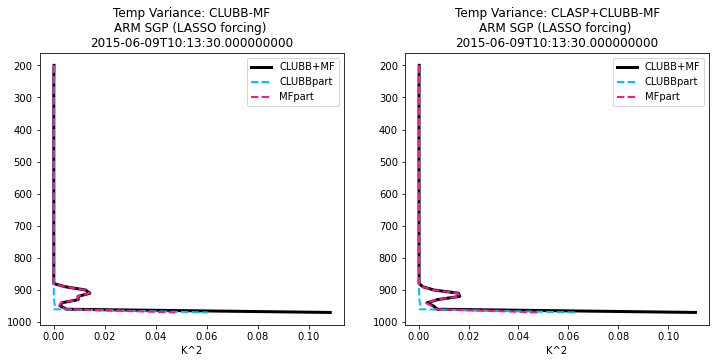

In [41]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

totVar   = 'total_thlp2'
clubbVar = 'THLP2_CLUBB_interp'
mfVar    = 'edmf_S_ATHLTHL_interp'
unitsStr = 'K^2'
varName  = 'Temp Variance'

selTime  = 410

colorsel = ['black','deepskyblue','deeppink']
linestylesel = ['-','--','--']
linewidthsel = [3,2,2]



axs[0].plot(np.squeeze(scamDS_h2[totVar].isel(time=selTime).sel(case='clubbMF')), 
            scamDS_h2.levInterp.values, 
            color=colorsel[0],linestyle=linestylesel[0], linewidth=linewidthsel[0], 
            label='CLUBB+MF')
axs[0].plot(np.squeeze(scamDS[clubbVar].isel(time=selTime).sel(case='clubbMF')), 
            scamDS.levInterp.values, 
            color=colorsel[1],linestyle=linestylesel[1], linewidth=linewidthsel[1], 
            label='CLUBBpart')
axs[0].plot(np.squeeze(scamDS_h2[mfVar].isel(time=selTime).sel(case='clubbMF')), 
            scamDS_h2.levInterp.values, 
            color=colorsel[2],linestyle=linestylesel[2], linewidth=linewidthsel[2], 
            label='MFpart')

axs[1].plot(np.squeeze(scamDS_h2.total_thlp2.isel(time=selTime).sel(case='clasp+MF')), 
            scamDS_h2.levInterp.values, 
            color=colorsel[0],linestyle=linestylesel[0], linewidth=linewidthsel[0],
            label='CLUBB+MF')
axs[1].plot(np.squeeze(scamDS[clubbVar].isel(time=selTime).sel(case='clasp+MF')), 
             scamDS.levInterp.values, 
            color=colorsel[1],linestyle=linestylesel[1], linewidth=linewidthsel[1], 
            label='CLUBBpart')
axs[1].plot(np.squeeze(scamDS_h2[mfVar].isel(time=selTime).sel(case='clasp+MF')), 
             scamDS_h2.levInterp.values, 
            color=colorsel[2],linestyle=linestylesel[2], linewidth=linewidthsel[2], 
            label='MFpart')

axs[0].legend()
axs[0].invert_yaxis()
axs[0].set_title(varName+': CLUBB-MF\nARM SGP (LASSO forcing) \n'+str(scamDS.time.values[selTime]))
axs[0].set_xlabel(unitsStr)


axs[1].legend()
axs[1].invert_yaxis()
axs[1].set_title(varName+': CLASP+CLUBB-MF\nARM SGP (LASSO forcing) \n'+str(scamDS.time.values[selTime]))
axs[1].set_xlabel(unitsStr)



Text(0.5, 0, 'm^2 s^-2')

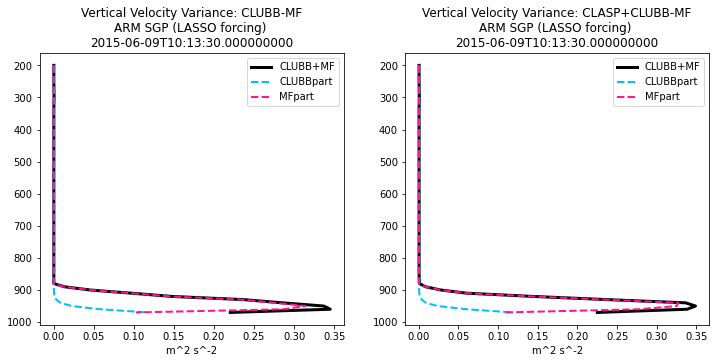

In [42]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs     = axs.ravel()

totVar   = 'total_wp2'
clubbVar = 'WP2_CLUBB_interp'
mfVar    = 'edmf_S_AWW_interp'
unitsStr = 'm^2 s^-2'
varName  = 'Vertical Velocity Variance'

selTime  = 410

colorsel = ['black','deepskyblue','deeppink']
linestylesel = ['-','--','--']
linewidthsel = [3,2,2]



axs[0].plot(np.squeeze(scamDS_h2[totVar].isel(time=selTime).sel(case='clubbMF')), 
            scamDS_h2.levInterp.values, 
            color=colorsel[0],linestyle=linestylesel[0], linewidth=linewidthsel[0], 
            label='CLUBB+MF')
axs[0].plot(np.squeeze(scamDS[clubbVar].isel(time=selTime).sel(case='clubbMF')), 
            scamDS.levInterp.values, 
            color=colorsel[1],linestyle=linestylesel[1], linewidth=linewidthsel[1], 
            label='CLUBBpart')
axs[0].plot(np.squeeze(scamDS_h2[mfVar].isel(time=selTime).sel(case='clubbMF')), 
            scamDS_h2.levInterp.values, 
            color=colorsel[2],linestyle=linestylesel[2], linewidth=linewidthsel[2], 
            label='MFpart')

axs[1].plot(np.squeeze(scamDS_h2[totVar].isel(time=selTime).sel(case='clasp+MF')), 
            scamDS_h2.levInterp.values, 
            color=colorsel[0],linestyle=linestylesel[0], linewidth=linewidthsel[0],
            label='CLUBB+MF')
axs[1].plot(np.squeeze(scamDS[clubbVar].isel(time=selTime).sel(case='clasp+MF')), 
             scamDS.levInterp.values, 
            color=colorsel[1],linestyle=linestylesel[1], linewidth=linewidthsel[1], 
            label='CLUBBpart')
axs[1].plot(np.squeeze(scamDS_h2[mfVar].isel(time=selTime).sel(case='clasp+MF')), 
             scamDS_h2.levInterp.values, 
            color=colorsel[2],linestyle=linestylesel[2], linewidth=linewidthsel[2], 
            label='MFpart')

axs[0].legend()
axs[0].invert_yaxis()
axs[0].set_title(varName+': CLUBB-MF\nARM SGP (LASSO forcing) \n'+str(scamDS.time.values[selTime]))
axs[0].set_xlabel(unitsStr)


axs[1].legend()
axs[1].invert_yaxis()
axs[1].set_title(varName+': CLASP+CLUBB-MF\nARM SGP (LASSO forcing) \n'+str(scamDS.time.values[selTime]))
axs[1].set_xlabel(unitsStr)


## Plots and Analysis 

### PDFs

In [43]:
# Limit to daytime hours
selHours = np.where((scamDS['time.hour'].values>=7) & (scamDS['time.hour'].values<=19))[0]
scamDaytime  = scamDS.isel(time=selHours)


In [44]:
scamRain  = scamDaytime.PRECT.resample(time='1H').mean().dropna(dim='time')*(3600*1e3) ## Convert units to mm/hr,

# SCAM
rainRatesHMG_scam = scamRain.sel(case='clubbMF').values
rainRatesHMG_scam = rainRatesHMG_scam[np.where(rainRatesHMG_scam>0)[0]]

rainRatesHTG_scam = scamRain.sel(case='clasp+MF').values
rainRatesHTG_scam = rainRatesHTG_scam[np.where(rainRatesHTG_scam>0)[0]]


In [45]:
np.unique(scamRain['time.hour'].values)

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [46]:
dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHTG_scam), 'case': 'claspMF'}),
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHMG_scam), 'case': 'clubbMF'}),
         ])

# Make plot 
g = sns.displot(dfReal, x='Rain rate', hue='case', kind='kde', height=6, cut=0, 
                log_scale=True,
# g = sns.displot(dfReal, x='Rain rate', hue='case', kind='ecdf', height=8, 
                palette=['red','mediumblue'], legend=True)

# g.ax.set_xlim([10**-13, 10**1])
g.ax.set_title("Hourly rain rates (>0.0 mm/hr)", fontsize=16 ) 
g.ax.set_xlabel('mm/hr',fontsize=16)
g.ax.set_ylabel('Probability Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)
# plt.setp(g._legend.get_title(), fontsize=14)
# plt.setp(g._legend.get_texts(), fontsize=14)
# plt.setp(g.ax.lines[5], linestyle='--')   # Index goes in reverse order 
# plt.legend(loc='upper left', 
#            labels=['Obs','LES_HMG','LES_HTG','SCAM_HMG','SCAM_HTG',r"SCAM_HTG$_\alpha$",r"SCAM_HTG$_{100}$"], 
#            ncol=2, fontsize=12)




In [47]:
# scamCLD  = scamDS.CLDTOT.resample(time='1H').mean().dropna(dim='time')

scamCLD  = scamDS.CLDTOT.resample(time='1H').mean().dropna(dim='time')
# Limit to daytime hours
selHours = np.where(scamCLD['time.hour'].values<=19)[0]
scamCLD  = scamCLD.isel(time=selHours)

# SCAM
cldHMG_scam = scamCLD.sel(case='clubbMF').values
cldHTG_scam = scamCLD.sel(case='clasp+MF').values

dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'Cloud Fraction': np.squeeze(cldHTG_scam), 'case': 'claspMF'}),
         pd.DataFrame.from_dict({'Cloud Fraction': np.squeeze(cldHMG_scam), 'case': 'clubbMF'}),
         ])

# Make plot 
g = sns.displot(dfReal, x='Cloud Fraction', hue='case', kind='kde', height=6, cut=0,
                palette=['red','mediumblue'])

g.ax.set_title("Cloud total", fontsize=16 ) 
g.ax.set_xlabel('Cloud fraction',fontsize=16)
g.ax.set_ylabel('Probability Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)

plt.setp(g._legend.get_title(), fontsize=14)
plt.setp(g._legend.get_texts(), fontsize=12)


[None, None, None, None]

In [38]:
binEdges = [10e-16, 10e-14, 10e-12, 10e-10, 10e-8, 10e-6, 10e-4, 10e-2, 10e-1,10]

plt.hist(np.squeeze(rainRatesHMG_scam), alpha = 0.5, bins=binEdges)
plt.hist(np.squeeze(rainRatesHTG_scam), alpha=0.5, bins=binEdges)

plt.xscale('log')
plt.legend(['CLUBB-MF', 'CLASP+MF'])


In [48]:
# SCAM
rainRatesHMG_scam = scamRain.sel(case='clubbMF').values
rainRatesHMG_scam = rainRatesHMG_scam[np.where(rainRatesHMG_scam>0)[0]]

rainRatesHTG_scam = scamRain.sel(case='clasp+MF').values
rainRatesHTG_scam = rainRatesHTG_scam[np.where(rainRatesHMG_scam>0)[0]]  # Keep where HMG is raining

times = scamRain.sel(case='clubbMF')['time.hour'].values[np.where(rainRatesHMG_scam>0)[0]]
print(np.unique(times))

# for iT in range(len(rainRatesHMG_scam)):

plt.scatter(rainRatesHMG_scam, rainRatesHTG_scam,
            c=times,
            cmap = 'jet')

plt.xlabel('HOM case')
plt.ylabel('HET case')
plt.title('Hourly Mean Rain Rates > 0 mm/hr')
plt.colorbar(label='Local Hour')
plt.xlim([-0.05,1.8])
plt.ylim([-0.05,1.8])
    

[ 7  8  9 10 11 12 13 14 15 16 17 18 19]


(-0.05, 1.8)

In [49]:
rainRatesHMG_scam = scamRain.sel(case='clubbMF').where(scamRain.sel(case='clubbMF')>0)
rainRatesHTG_scam = scamRain.sel(case='clasp+MF').where(scamRain.sel(case='clubbMF')>0)

Text(0, 0.5, 'Hourly Mean PRECT [mm/hr]')

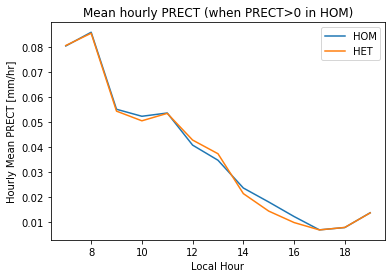

In [50]:
plt.plot(rainRatesHMG_scam.groupby('time.hour').mean(dim='time').dropna(dim='hour').hour.values, 
         rainRatesHMG_scam.groupby('time.hour').mean(dim='time').dropna(dim='hour').values)

plt.plot(rainRatesHTG_scam.groupby('time.hour').mean(dim='time').dropna(dim='hour').hour.values, 
         rainRatesHTG_scam.groupby('time.hour').mean(dim='time').dropna(dim='hour').values)

plt.title('Mean hourly PRECT (when PRECT>0 in HOM)')
plt.legend(['HOM','HET'])
plt.xlabel('Local Hour')
plt.ylabel('Hourly Mean PRECT [mm/hr]')

In [51]:
# scamCLD  = scamDS.CLDTOT.resample(time='1H').mean().dropna(dim='time')

scamL0  = scamDS_h2.edmf_L0.resample(time='1H').mean().dropna(dim='time')
# Limit to daytime hours
selHours = np.where(scamL0['time.hour'].values<=19)[0]
scamL0  = scamL0.isel(time=selHours)

# SCAM
cldHMG_scam = scamL0.sel(case='clubbMF').values
cldHTG_scam = scamL0.sel(case='clasp+MF').values

dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'L0': np.squeeze(cldHTG_scam), 'case': 'claspMF'}),
         pd.DataFrame.from_dict({'L0': np.squeeze(cldHMG_scam), 'case': 'clubbMF'}),
         ])

# Make plot 
g = sns.displot(dfReal, x='L0', hue='case', kind='kde', height=6, cut=0,
                palette=['red','mediumblue'])

g.ax.set_title("edmf_L0", fontsize=16 ) 
g.ax.set_xlabel('length scale (L0 [m])',fontsize=16)
g.ax.set_ylabel('Probability Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)

plt.setp(g._legend.get_title(), fontsize=14)
plt.setp(g._legend.get_texts(), fontsize=12)


AttributeError: 'Dataset' object has no attribute 'edmf_L0'

In [52]:
upthl_clubbMF = scamDS_h2.thlu_macmicAvg_interp.sel(case='clubbMF')
upthl_claspMF = scamDS_h2.thlu_macmicAvg_interp.sel(case='clasp+MF')

countValPlumes_clubb = np.zeros([len(upthl_clubbMF.levInterp.values)])
countValPlumes_clasp = np.zeros([len(upthl_clubbMF.levInterp.values)])

for iLev in range(len(upthl_clubbMF.levInterp.values)):
    countValPlumes_clubb[iLev] = np.shape(np.where( np.isfinite(upthl_clubbMF.isel(levInterp=iLev))==True))[1]
    countValPlumes_clasp[iLev] = np.shape(np.where( np.isfinite(upthl_claspMF.isel(levInterp=iLev))==True))[1]


In [38]:
np.shape(countValPlumes_clubb)

(78,)

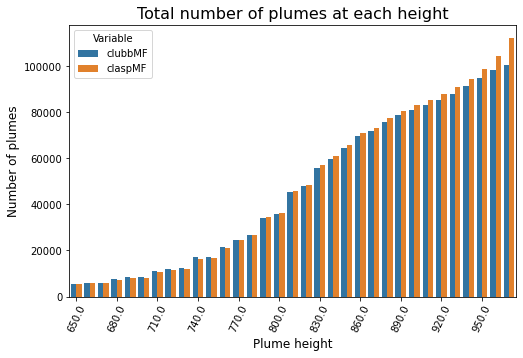

In [53]:
fig, ax = plt.subplots(figsize=(8, 5))    

levs = upthl_claspMF.levInterp.values
dfLevInfo = pd.DataFrame({'Level': levs[45::],
                          'clubbMF': countValPlumes_clubb[45::], 
                          'claspMF': countValPlumes_clasp[45::]})
tidy = dfLevInfo.melt(id_vars='Level').rename(columns=str.title)

g = sns.barplot(x='Level',y='Value',hue='Variable',data=tidy)
xtix = ax.get_xticks()
ax.set_xticks(xtix[::3])
plt.xticks(rotation=65)
ax.set_ylabel('Number of plumes',fontsize=12)
ax.set_xlabel('Plume height',fontsize=12)
ax.set_title('Total number of plumes at each height', fontsize=16)

plt.show()

(700.0, 980.0)

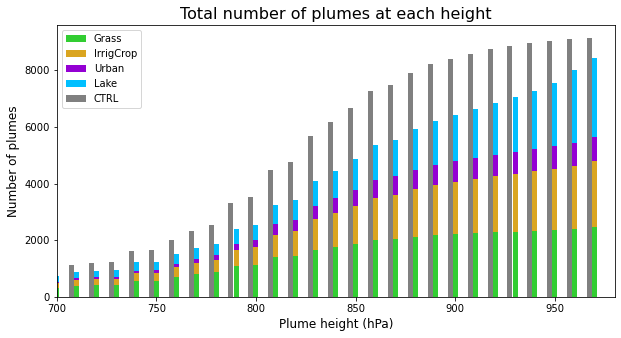

In [31]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))    

# Limit to daytime hours
selHours = np.where((scamDS_h2['time.hour'].values>=7) & (scamDS_h2['time.hour'].values<=19))[0]
scamDaytime  = scamDS.isel(time=selHours)

nplumes_grass  = scamDaytime.sel(case='clasp+MF').nPlumesActive_grass.resample(time='1H').mean().dropna(dim='time').sum(dim='time').values[50::]
nplumes_crop   = scamDaytime.sel(case='clasp+MF').nPlumesActive_crop.resample(time='1H').mean().dropna(dim='time').sum(dim='time').values[50::]
nplumes_urban  = scamDaytime.sel(case='clasp+MF').nPlumesActive_urban.resample(time='1H').mean().dropna(dim='time').sum(dim='time').values[50::]
nplumes_lake   = scamDaytime.sel(case='clasp+MF').nPlumesActive_lake.resample(time='1H').mean().dropna(dim='time').sum(dim='time').values[50::]

nplumes_HOM  = scamDaytime.nPlumesActive.resample(time='1H').mean().dropna(dim='time').sum(dim='time').sel(case='clubbMF').values[50::]


levs = scamDS.levInterp.values
tiles = ['Grass','IrrigCrop','Urban','Lake']

ax.bar(levs[50::], nplumes_grass, color='limegreen',width=2.5)
ax.bar(levs[50::], nplumes_crop, bottom=nplumes_grass, color='goldenrod', width=2.5)
ax.bar(levs[50::], nplumes_urban, bottom=nplumes_grass+nplumes_crop, color='darkviolet', width=2.5)
ax.bar(levs[50::], nplumes_lake, bottom=nplumes_grass+nplumes_crop+nplumes_urban, color='deepskyblue', width=2.5)

ax.bar(levs[50::]-2.55, nplumes_HOM, color='gray', width=2.5,)

ax.legend(['Grass','IrrigCrop','Urban','Lake','CTRL'])

xtix = ax.get_xticks()
# ax.set_xticks(xtix[::3])
# plt.xticks(rotation=45)
ax.set_ylabel('Number of plumes',fontsize=12)
ax.set_xlabel('Plume height (hPa)',fontsize=12)
ax.set_title('Total number of plumes at each height', fontsize=16)
# ax.set_ylim([0,4000])
ax.set_xlim([levs[50], 980])

# dfGrass = pd.DataFrame({'Level': levs[55::],
#                           'clubbMF': nplumes_grass.sel(case='clubbMF').values[55::], 
#                           'claspMF': nplumes_grass.sel(case='clasp+MF').values[55::]})
# tidy = dfGrass.melt(id_vars='Level').rename(columns=str.title)

# g = sns.barplot(x='Level',y='Value',hue='Variable',data=tidy,ax=axs[0])
# xtix = axs[0].get_xticks()
# axs[0].set_xticks(xtix[::3])
# plt.xticks(rotation=65)
# axs[0].set_ylabel('Number of plumes',fontsize=12)
# axs[0].set_xlabel('Plume height',fontsize=12)
# axs[0].set_title('Total number of plumes at each height (grass)', fontsize=16)
# axs[0].set_ylim([0,4000])


In [32]:
# Limit to daytime hours
selHours = np.where((scamDS_h2['time.hour'].values>=7) & (scamDS_h2['time.hour'].values<=19))[0]
# scamDay  = scamDS_h2.isel(time=selHours).mean(dim='nens')

edmf_grass = grassDS.isel(time=selHours).mean(dim='nens')
edmf_crop  = cropDS.isel(time=selHours).mean(dim='nens')
edmf_urban  = urbanDS.isel(time=selHours).mean(dim='nens')
edmf_lake   = lakeDS.isel(time=selHours).mean(dim='nens')

edmf_CTRL  = scamDS_h2.isel(time=selHours).mean(dim='nens').sel(case='clubbMF')
edmf_HET   = scamDS_h2.isel(time=selHours).mean(dim='nens').sel(case='clasp+MF')


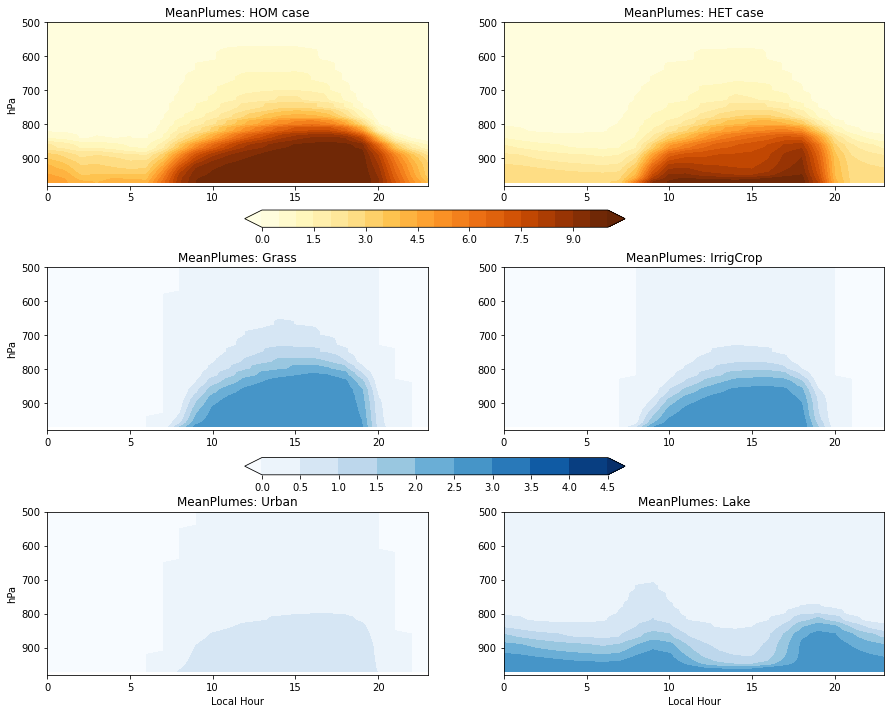

In [33]:
## Look at diurnal cycle of plume initiations?
nplumes_grassMean  = scamDS.sel(case='clasp+MF').nPlumesActive_grass.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')
nplumes_cropMean   = scamDS.sel(case='clasp+MF').nPlumesActive_crop.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')
nplumes_urbanMean  = scamDS.sel(case='clasp+MF').nPlumesActive_urban.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')
nplumes_lakeMean   = scamDS.sel(case='clasp+MF').nPlumesActive_lake.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')

nplumes_HOMmean    = scamDS.sel(case='clubbMF').nPlumesActive.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')
nplumes_HETmean    = scamDS.sel(case='clasp+MF').nPlumesActive.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')

## ----- Plot that ----- 
fig,axs = plt.subplots(3,2, figsize=(15,12))
axs = axs.ravel()

## Plot overall means 
axs[0].contourf(nplumes_HOMmean.hour.values, nplumes_HOMmean.levInterp.values, 
                nplumes_HOMmean.values.transpose(), np.arange(0,10.5,0.5), 
                cmap = 'YlOrBr', extend='both')
axs[0].set_title('MeanPlumes: HOM case')

cplot = axs[1].contourf(nplumes_HETmean.hour.values, nplumes_HETmean.levInterp.values, 
                nplumes_HETmean.values.transpose(), np.arange(0,10.5,0.5), 
                cmap = 'YlOrBr', extend='both')
axs[1].set_title('MeanPlumes: HET case')

# add colorbar for overall mean cases 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.015, ax_position.width, 0.02])
cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)


## Plot patch data 
axs[2].contourf(nplumes_grassMean.hour.values, nplumes_grassMean.levInterp.values, 
                nplumes_grassMean.values.transpose(), np.arange(0,5,0.5), 
                cmap = 'Blues', extend='both')
axs[2].set_title('MeanPlumes: Grass')

cplot=axs[3].contourf(nplumes_cropMean.hour.values, nplumes_cropMean.levInterp.values, 
                nplumes_cropMean.values.transpose(), np.arange(0,5,0.5), 
                cmap = 'Blues', extend='both')
axs[3].set_title('MeanPlumes: IrrigCrop')
# add colorbar for individual patches 
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.035, ax_position.width, 0.02])
cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

axs[4].contourf(nplumes_urbanMean.hour.values, nplumes_urbanMean.levInterp.values, 
                nplumes_urbanMean.values.transpose(), np.arange(0,5,0.5), 
                cmap = 'Blues', extend='both')
axs[4].set_title('MeanPlumes: Urban')

cplot = axs[5].contourf(nplumes_lakeMean.hour.values, nplumes_lakeMean.levInterp.values, 
                nplumes_lakeMean.values.transpose(), np.arange(0,5,0.5), 
                cmap = 'Blues', extend='both')
axs[5].set_title('MeanPlumes: Lake')


## Other plot options 
axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()

axs[0].set_ylim([980,500])
axs[1].set_ylim([980,500])
axs[2].set_ylim([980,500])
axs[3].set_ylim([980,500])
axs[4].set_ylim([980,500])
axs[5].set_ylim([980,500])

axs[4].set_xlabel('Local Hour')
axs[5].set_xlabel('Local Hour')

axs[0].set_ylabel('hPa')
axs[2].set_ylabel('hPa')
axs[4].set_ylabel('hPa')


fig.subplots_adjust(hspace = 0.5)


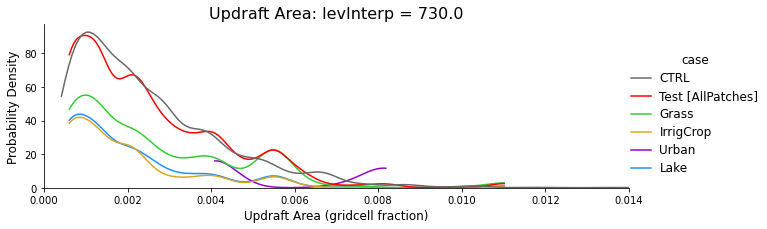

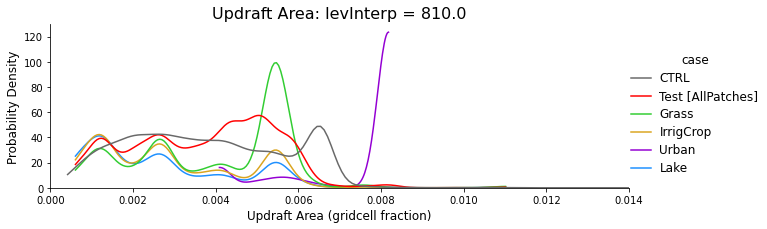

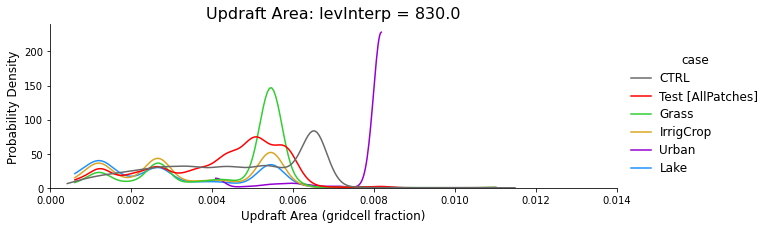

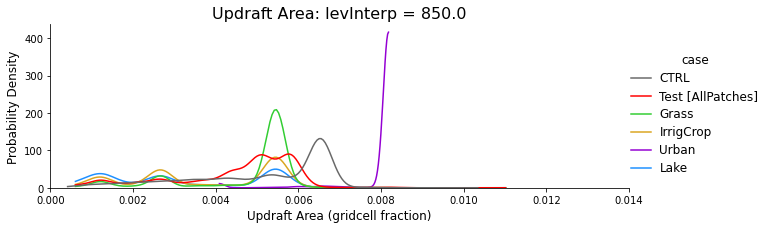

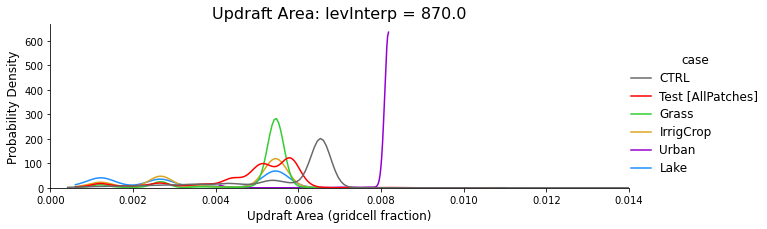

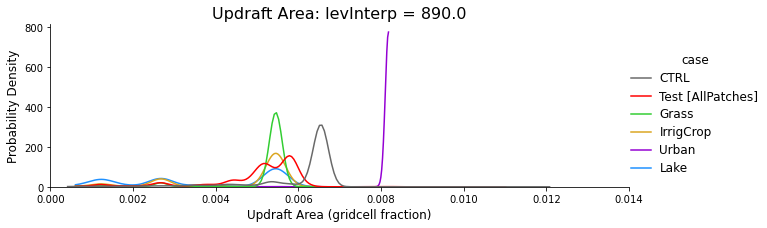

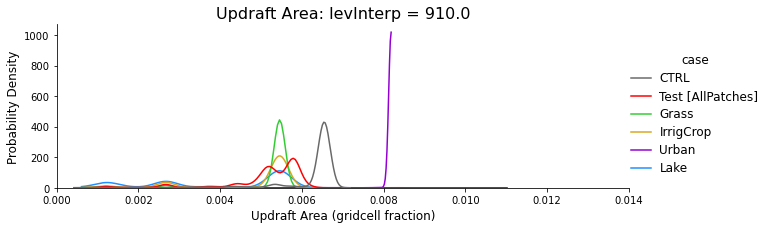

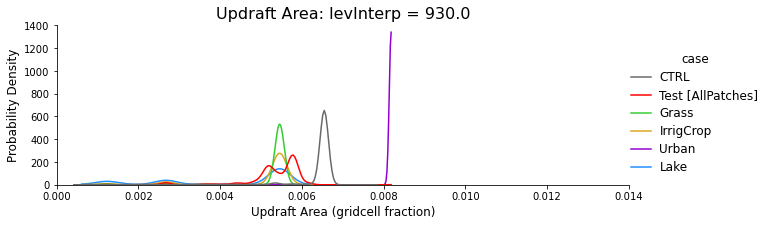

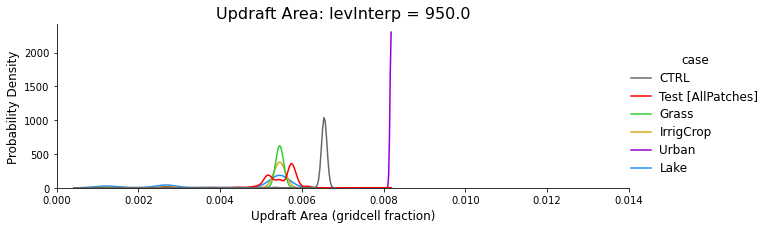

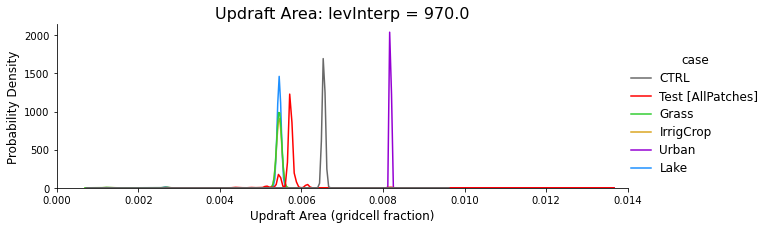

In [34]:
## Data choices 

varSel = 'upa_macmicAvg_interp'
levSel = [-25,-17,-15,-13,-11,-9,-7,-5,-3,-1]

# ## Make figure 
# fig,axs = plt.subplots(len(levSel),1, figsize=(8,3*len(levSel)))
# axs     = axs.ravel()

for ilev in range(len(levSel)):
    dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'UpdraftArea': np.squeeze(edmf_CTRL[varSel].isel(levInterp=levSel[ilev]).values), 'case': 'CTRL'}),
         pd.DataFrame.from_dict({'UpdraftArea': np.squeeze(edmf_HET[varSel].isel(levInterp=levSel[ilev]).values), 'case': 'Test [AllPatches]'}),

        pd.DataFrame.from_dict({'UpdraftArea': np.squeeze(edmf_grass[varSel].isel(levInterp=levSel[ilev]).values), 'case': 'Grass'}),
         pd.DataFrame.from_dict({'UpdraftArea': np.squeeze(edmf_crop[varSel].isel(levInterp=levSel[ilev]).values), 'case': 'IrrigCrop'}),
         pd.DataFrame.from_dict({'UpdraftArea': np.squeeze(edmf_urban[varSel].isel(levInterp=levSel[ilev]).values), 'case': 'Urban'}),
         pd.DataFrame.from_dict({'UpdraftArea': np.squeeze(edmf_lake[varSel].isel(levInterp=levSel[ilev]).values), 'case': 'Lake'}),
         ])

    # Make plot 
    g = sns.displot( data=dfReal, x='UpdraftArea', hue='case', kind='kde', cut=0,
    #                 fill=True, alpha=0.5,
                    palette=['dimgrey','red','limegreen','goldenrod','darkviolet','dodgerblue'],
                   height=3, aspect=9/3, 
                   )

    g.ax.set_title("Updraft Area: levInterp = "+str(edmf_CTRL.levInterp.values[levSel[ilev]]), fontsize=16 ) 

    g.ax.set_xlabel('Updraft Area (gridcell fraction)',fontsize=12)
    g.ax.set_ylabel('Probability Density',fontsize=12)
    g.ax.set_xlim([0.00, 0.014])
#     g.ax.tick_params(axis='both', labelsize= 14)

    plt.setp(g._legend.get_title(), fontsize=12)
    plt.setp(g._legend.get_texts(), fontsize=12)




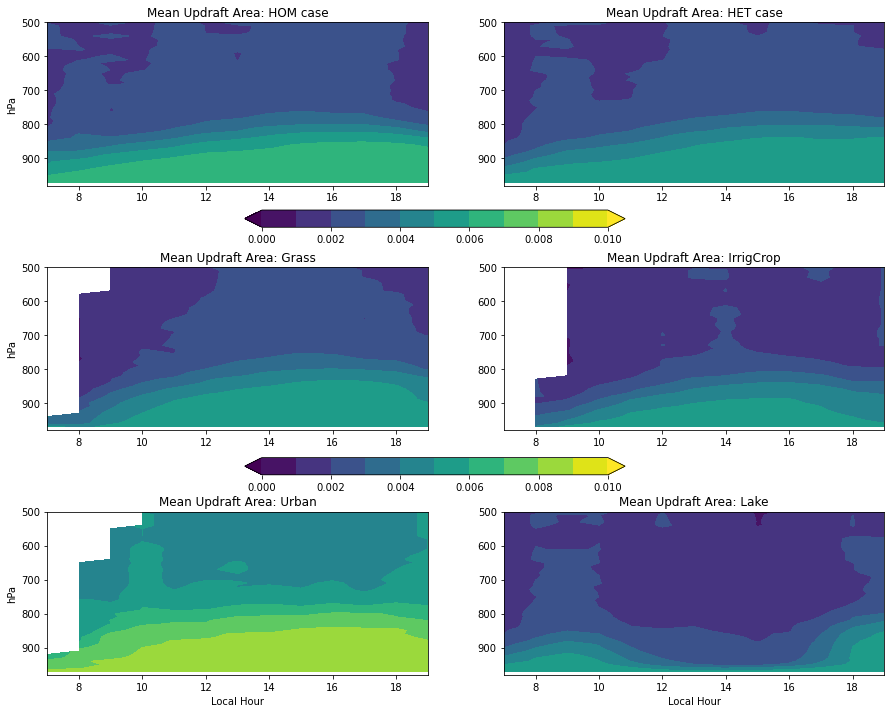

In [35]:
## Look at diurnal cycle of plume properties?
nplumes_grassMean  = edmf_grass.upa_macmicAvg_interp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_cropMean   = edmf_crop.upa_macmicAvg_interp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_urbanMean  = edmf_urban.upa_macmicAvg_interp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_lakeMean   = edmf_lake.upa_macmicAvg_interp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')

nplumes_HOMmean    = edmf_CTRL.upa_macmicAvg_interp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_HETmean    = edmf_HET.upa_macmicAvg_interp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')

## ----- Plot that ----- 
fig,axs = plt.subplots(3,2, figsize=(15,12))
axs = axs.ravel()

## Plot overall means 
axs[0].contourf(nplumes_HOMmean.hour.values, nplumes_HOMmean.levInterp.values, 
                nplumes_HOMmean.values.transpose(), np.arange(0,0.011,0.001), 
                cmap = 'viridis', extend='both')
axs[0].set_title('Mean Updraft Area: HOM case')

cplot = axs[1].contourf(nplumes_HETmean.hour.values, nplumes_HETmean.levInterp.values, 
                nplumes_HETmean.values.transpose(), np.arange(0,0.011,0.001), 
                cmap = 'viridis', extend='both')
axs[1].set_title('Mean Updraft Area: HET case')

# add colorbar for overall mean cases 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.015, ax_position.width, 0.02])
cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)


## Plot patch data 
axs[2].contourf(nplumes_grassMean.hour.values, nplumes_grassMean.levInterp.values, 
                nplumes_grassMean.values.transpose(), np.arange(0,0.011,0.001), 
                cmap = 'viridis', extend='both')
axs[2].set_title('Mean Updraft Area: Grass')

cplot=axs[3].contourf(nplumes_cropMean.hour.values, nplumes_cropMean.levInterp.values, 
                nplumes_cropMean.values.transpose(), np.arange(0,0.011,0.001), 
                cmap = 'viridis', extend='both')
axs[3].set_title('Mean Updraft Area: IrrigCrop')
# add colorbar for individual patches 
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.035, ax_position.width, 0.02])
cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

axs[4].contourf(nplumes_urbanMean.hour.values, nplumes_urbanMean.levInterp.values, 
                nplumes_urbanMean.values.transpose(), np.arange(0,0.011,0.001), 
                cmap = 'viridis', extend='both')
axs[4].set_title('Mean Updraft Area: Urban')

cplot = axs[5].contourf(nplumes_lakeMean.hour.values, nplumes_lakeMean.levInterp.values, 
                nplumes_lakeMean.values.transpose(), np.arange(0,0.011,0.001), 
                cmap = 'viridis', extend='both')
axs[5].set_title('Mean Updraft Area: Lake')


## Other plot options 
axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()

axs[0].set_ylim([980,500])
axs[1].set_ylim([980,500])
axs[2].set_ylim([980,500])
axs[3].set_ylim([980,500])
axs[4].set_ylim([980,500])
axs[5].set_ylim([980,500])

axs[0].set_xlim([7,19])
axs[1].set_xlim([7,19])
axs[2].set_xlim([7,19])
axs[3].set_xlim([7,19])
axs[4].set_xlim([7,19])
axs[5].set_xlim([7,19])

axs[4].set_xlabel('Local Hour')
axs[5].set_xlabel('Local Hour')

axs[0].set_ylabel('hPa')
axs[2].set_ylabel('hPa')
axs[4].set_ylabel('hPa')


fig.subplots_adjust(hspace = 0.5)


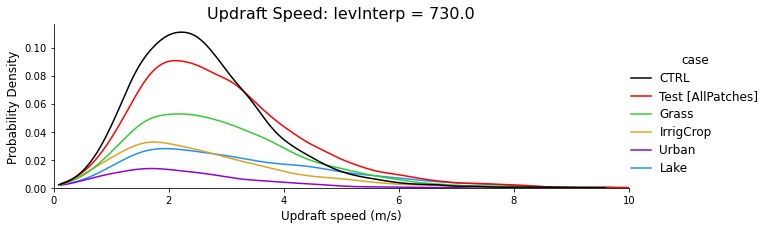

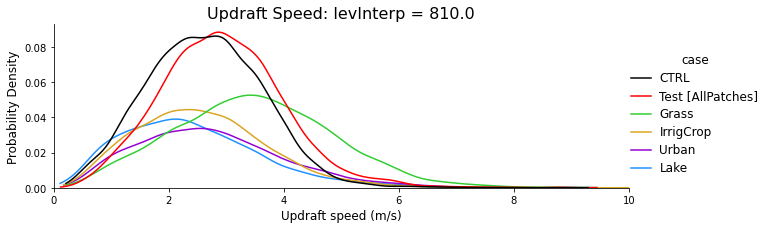

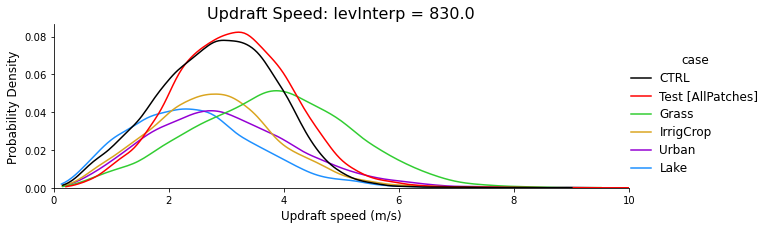

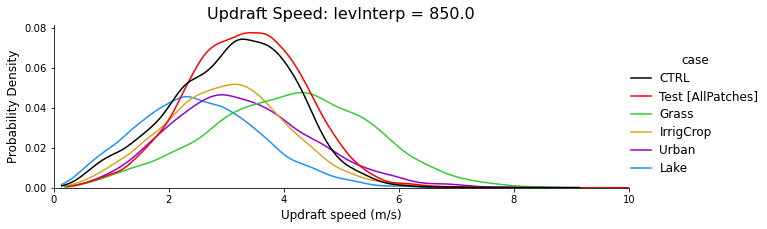

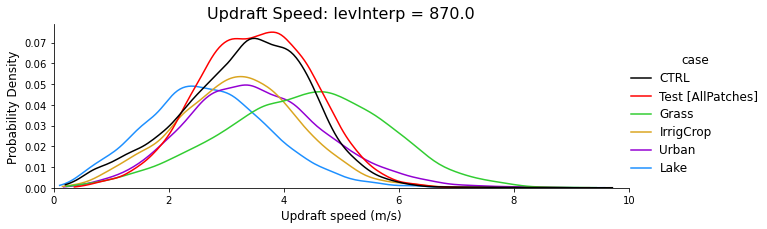

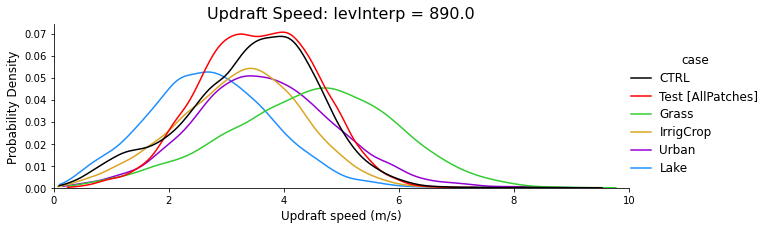

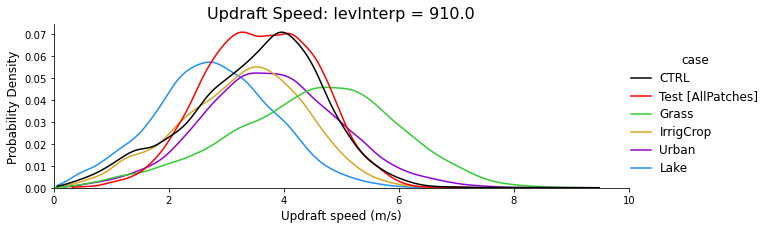

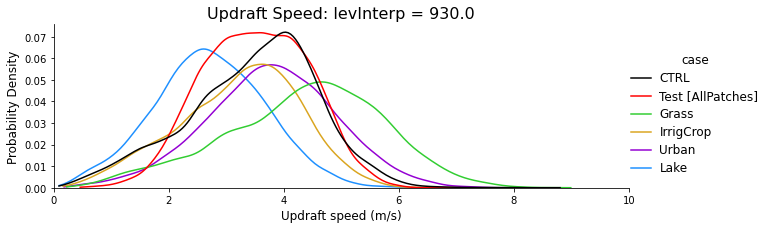

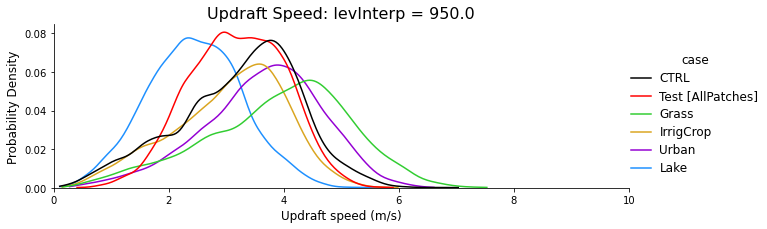

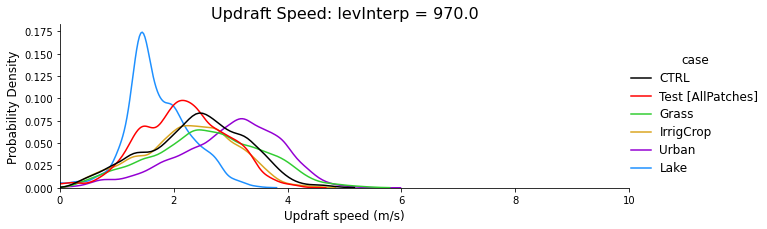

In [36]:
## Data choices 

varSel = 'up_macmicAvg_interp'
levSel = [-25,-17,-15,-13,-11,-9,-7,-5,-3,-1]

## Make figures 
for ilev in range(len(levSel)):
    dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_CTRL[varSel].isel(levInterp=levSel[ilev]).values), 'case': 'CTRL'}),
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_HET[varSel].isel(levInterp=levSel[ilev]).values), 'case': 'Test [AllPatches]'}),

        pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_grass[varSel].isel(levInterp=levSel[ilev]).values), 'case': 'Grass'}),
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_crop[varSel].isel(levInterp=levSel[ilev]).values), 'case': 'IrrigCrop'}),
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_urban[varSel].isel(levInterp=levSel[ilev]).values), 'case': 'Urban'}),
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_lake[varSel].isel(levInterp=levSel[ilev]).values), 'case': 'Lake'}),
         ])

    # Make plot 
    g = sns.displot( data=dfReal, x='UpdraftSpeed', hue='case', kind='kde', cut=0,
    #                 fill=True, alpha=0.5,
                    palette=['k','red','limegreen','goldenrod','darkviolet','dodgerblue'],
                   height=3, aspect=9/3, 
                   )

    g.ax.set_title("Updraft Speed: levInterp = "+str(edmf_CTRL.levInterp.values[levSel[ilev]]), fontsize=16 ) 

    g.ax.set_xlabel('Updraft speed (m/s)',fontsize=12)
    g.ax.set_ylabel('Probability Density',fontsize=12)
    g.ax.set_xlim([0.00, 10])

#     g.ax.tick_params(axis='both', labelsize= 14)

    plt.setp(g._legend.get_title(), fontsize=12)
    plt.setp(g._legend.get_texts(), fontsize=12)




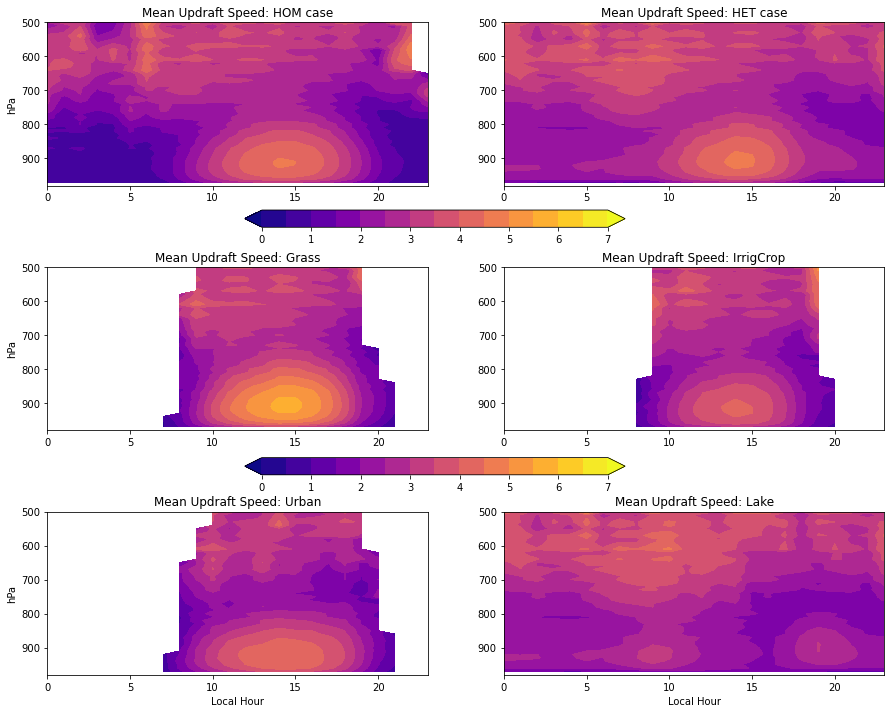

In [38]:
## Look at diurnal cycle of plume properties?
# nplumes_grassMean  = edmf_grass.up_macmicAvg_interp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# nplumes_cropMean   = edmf_crop.up_macmicAvg_interp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# nplumes_urbanMean  = edmf_urban.up_macmicAvg_interp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# nplumes_lakeMean   = edmf_lake.up_macmicAvg_interp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')

# nplumes_HOMmean    = edmf_CTRL.up_macmicAvg_interp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# nplumes_HETmean    = edmf_HET.up_macmicAvg_interp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')


## Look at diurnal cycle of plume initiations?
nplumes_grassMean  = grassDS.up_macmicAvg_interp.mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_cropMean   = cropDS.up_macmicAvg_interp.mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_urbanMean  = urbanDS.up_macmicAvg_interp.mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_lakeMean   = lakeDS.up_macmicAvg_interp.mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')

nplumes_HOMmean    = scamDS_h2.up_macmicAvg_interp.sel(case='clubbMF').mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_HETmean    = scamDS_h2.up_macmicAvg_interp.sel(case='clasp+MF').mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')


## ----- Plot that ----- 
fig,axs = plt.subplots(3,2, figsize=(15,12))
axs = axs.ravel()

## Plot overall means 
axs[0].contourf(nplumes_HOMmean.hour.values, nplumes_HOMmean.levInterp.values, 
                nplumes_HOMmean.values.transpose(), np.arange(0,7.5,0.5), 
                cmap = 'plasma', extend='both')
axs[0].set_title('Mean Updraft Speed: HOM case')

cplot = axs[1].contourf(nplumes_HETmean.hour.values, nplumes_HETmean.levInterp.values, 
                nplumes_HETmean.values.transpose(), np.arange(0,7.5,0.5), 
                cmap = 'plasma', extend='both')
axs[1].set_title('Mean Updraft Speed: HET case')

# add colorbar for overall mean cases 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.015, ax_position.width, 0.02])
cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)


## Plot patch data 
axs[2].contourf(nplumes_grassMean.hour.values, nplumes_grassMean.levInterp.values, 
                nplumes_grassMean.values.transpose(), np.arange(0,7.5,0.5), 
                cmap = 'plasma', extend='both')
axs[2].set_title('Mean Updraft Speed: Grass')

cplot=axs[3].contourf(nplumes_cropMean.hour.values, nplumes_cropMean.levInterp.values, 
                nplumes_cropMean.values.transpose(), np.arange(0,7.5,0.5), 
                cmap = 'plasma', extend='both')
axs[3].set_title('Mean Updraft Speed: IrrigCrop')
# add colorbar for individual patches 
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.035, ax_position.width, 0.02])
cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

axs[4].contourf(nplumes_urbanMean.hour.values, nplumes_urbanMean.levInterp.values, 
                nplumes_urbanMean.values.transpose(), np.arange(0,7.5,0.5), 
                cmap = 'plasma', extend='both')
axs[4].set_title('Mean Updraft Speed: Urban')

cplot = axs[5].contourf(nplumes_lakeMean.hour.values, nplumes_lakeMean.levInterp.values, 
                nplumes_lakeMean.values.transpose(), np.arange(0,7.5,0.5), 
                cmap = 'plasma', extend='both')
axs[5].set_title('Mean Updraft Speed: Lake')


## Other plot options 
axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()

axs[0].set_ylim([980,500])
axs[1].set_ylim([980,500])
axs[2].set_ylim([980,500])
axs[3].set_ylim([980,500])
axs[4].set_ylim([980,500])
axs[5].set_ylim([980,500])

# axs[0].set_xlim([7,19])
# axs[1].set_xlim([7,19])
# axs[2].set_xlim([7,19])
# axs[3].set_xlim([7,19])
# axs[4].set_xlim([7,19])
# axs[5].set_xlim([7,19])

axs[4].set_xlabel('Local Hour')
axs[5].set_xlabel('Local Hour')

axs[0].set_ylabel('hPa')
axs[2].set_ylabel('hPa')
axs[4].set_ylabel('hPa')


fig.subplots_adjust(hspace = 0.5)


In [44]:
np.shape(edmf_grass[varSel].isel(levInterp=levSel[ilev]).values)

(11544,)

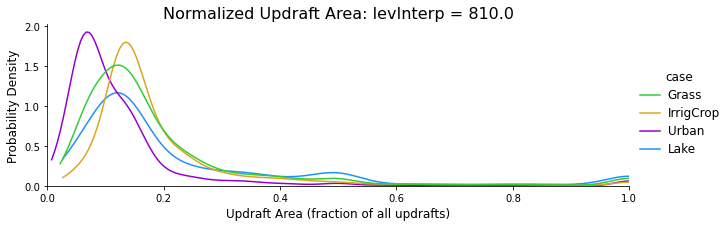

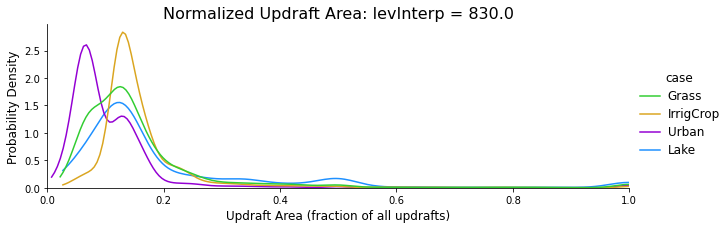

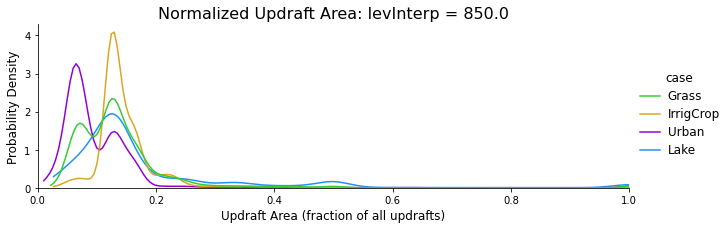

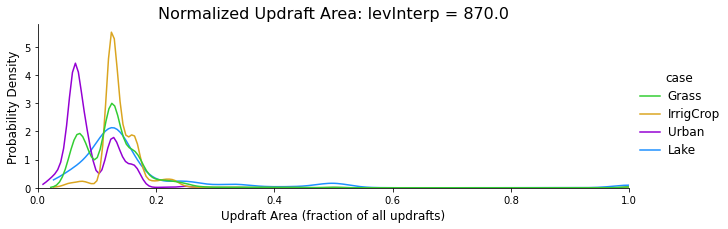

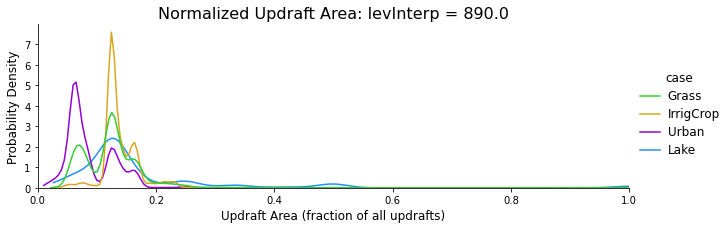

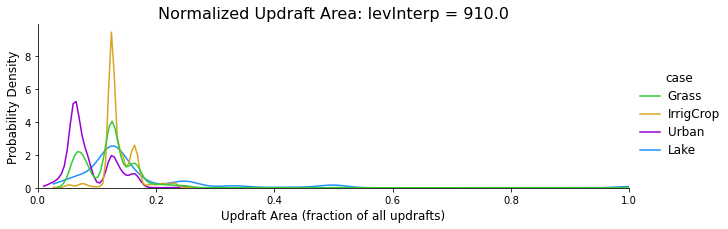

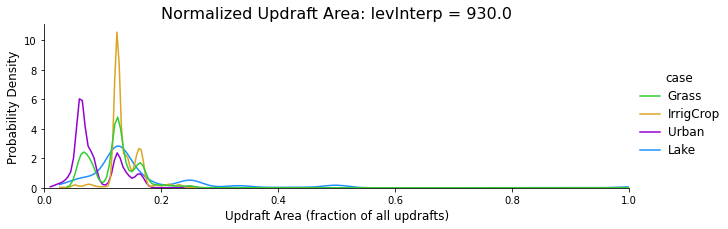

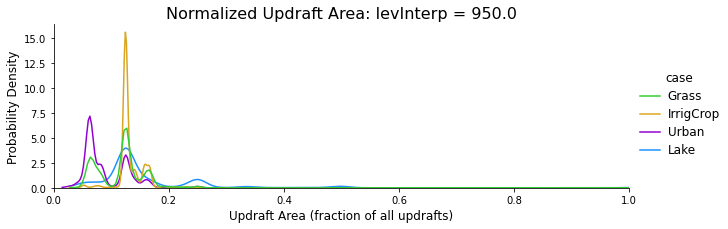

In [45]:
## Updraft area, but normalized so that we're looking at the fraction of updraft area relative to total updrafts, 
##     not total gridcell

varSel = 'upa_macmicAvg_interp'
levSel = [-17,-15,-13,-11,-9,-7,-5,-3,-1]

normFactor_HET  = scamDay.upa_macmicAvg_interp.sel(case='clasp+MF').sum(dim='nens')
normFactor_CTRL = scamDay.upa_macmicAvg_interp.sel(case='clubbMF').sum(dim='nens')

# ## Make figure 
# fig,axs = plt.subplots(len(levSel),1, figsize=(8,3*len(levSel)))
# axs     = axs.ravel()

for ilev in range(len(levSel)):
    dfReal = pd.concat(axis=0, ignore_index=True, objs=[
#          pd.DataFrame.from_dict({'UpdraftArea': np.squeeze(edmf_CTRL[varSel].isel(levInterp=levSel[ilev]).values/normFactor_CTRL.isel(levInterp=levSel[ilev]).values), 'case': 'CTRL'}),
#          pd.DataFrame.from_dict({'UpdraftArea': np.squeeze(edmf_HET[varSel].isel(levInterp=levSel[ilev]).values/normFactor_HET.isel(levInterp=levSel[ilev]).values), 'case': 'Test [AllPatches]'}),

        pd.DataFrame.from_dict({'UpdraftArea': np.squeeze(edmf_grass[varSel].isel(levInterp=levSel[ilev]).values/normFactor_HET.isel(levInterp=levSel[ilev]).values), 'case': 'Grass'}),
         pd.DataFrame.from_dict({'UpdraftArea': np.squeeze(edmf_crop[varSel].isel(levInterp=levSel[ilev]).values/normFactor_HET.isel(levInterp=levSel[ilev]).values), 'case': 'IrrigCrop'}),
         pd.DataFrame.from_dict({'UpdraftArea': np.squeeze(edmf_urban[varSel].isel(levInterp=levSel[ilev]).values/normFactor_HET.isel(levInterp=levSel[ilev]).values), 'case': 'Urban'}),
         pd.DataFrame.from_dict({'UpdraftArea': np.squeeze(edmf_lake[varSel].isel(levInterp=levSel[ilev]).values/normFactor_HET.isel(levInterp=levSel[ilev]).values), 'case': 'Lake'}),
         ])

    # Make plot 
    g = sns.displot( data=dfReal, x='UpdraftArea', hue='case', kind='kde', cut=0,
    #                 fill=True, alpha=0.5,
                    palette=['limegreen','goldenrod','darkviolet','dodgerblue'],
                   height=3, aspect=9/3, 
                   )

    g.ax.set_title("Normalized Updraft Area: levInterp = "+str(edmf_CTRL.levInterp.values[levSel[ilev]]), fontsize=16 ) 

    g.ax.set_xlabel('Updraft Area (fraction of all updrafts)',fontsize=12)
    g.ax.set_ylabel('Probability Density',fontsize=12)
    g.ax.set_xlim([0.00, 1.0])

#     g.ax.tick_params(axis='both', labelsize= 14)

    plt.setp(g._legend.get_title(), fontsize=12)
    plt.setp(g._legend.get_texts(), fontsize=12)




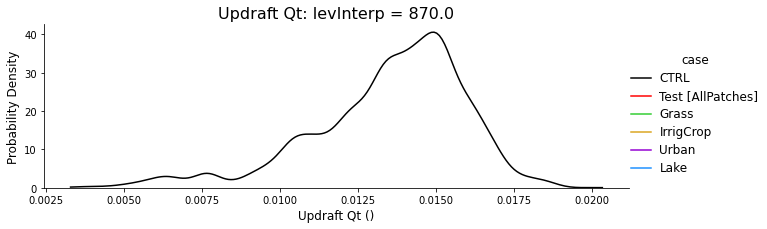

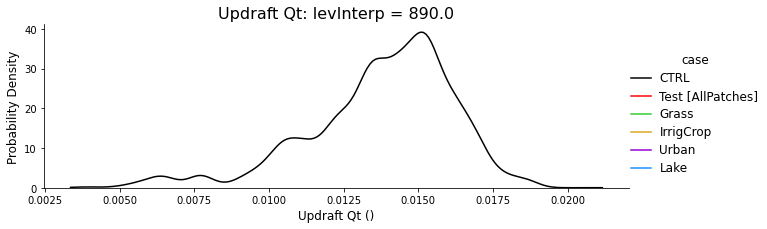

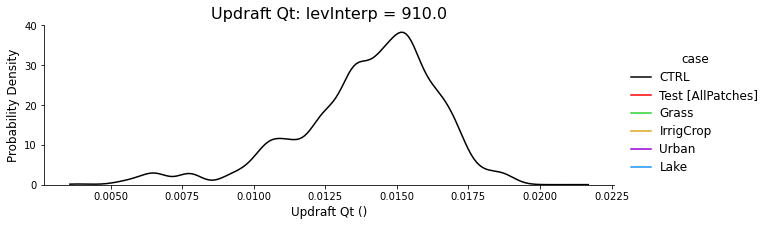

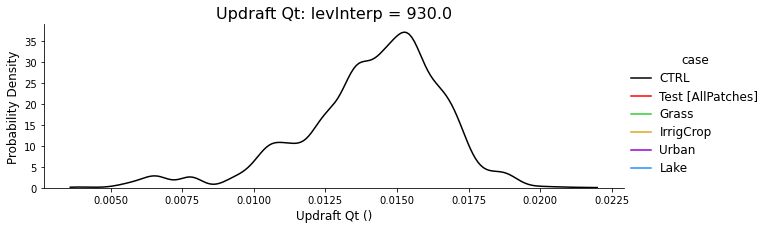

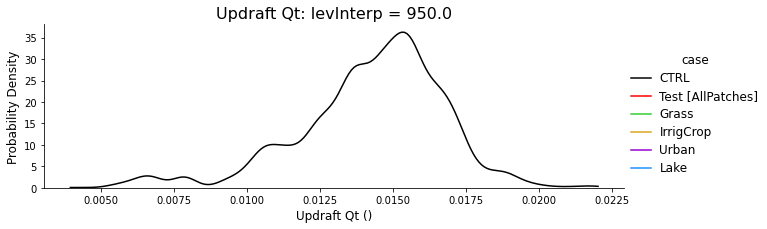

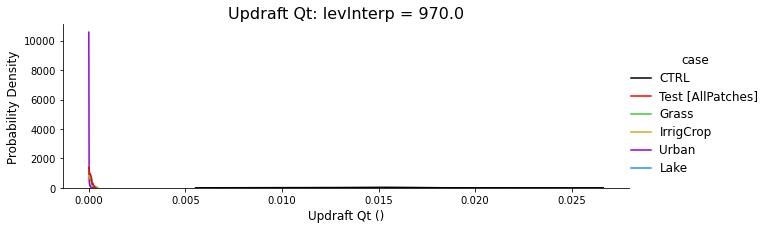

In [40]:
## Data choices 

varSel = 'qtu_macmicAvg_interp'
levSel = [-25,-17,-15,-13,-11,-9,-7,-5,-3,-1]

## Make figures 
for ilev in range(len(levSel)):
    dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_CTRL[varSel].isel(levInterp=levSel[ilev]).values), 'case': 'CTRL'}),
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_HET[varSel].isel(levInterp=levSel[ilev]).values), 'case': 'Test [AllPatches]'}),

        pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_grass[varSel].isel(levInterp=levSel[ilev]).values), 'case': 'Grass'}),
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_crop[varSel].isel(levInterp=levSel[ilev]).values), 'case': 'IrrigCrop'}),
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_urban[varSel].isel(levInterp=levSel[ilev]).values), 'case': 'Urban'}),
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_lake[varSel].isel(levInterp=levSel[ilev]).values), 'case': 'Lake'}),
         ])

    # Make plot 
    g = sns.displot( data=dfReal, x='UpdraftSpeed', hue='case', kind='kde', cut=0,
    #                 fill=True, alpha=0.5,
                    palette=['k','red','limegreen','goldenrod','darkviolet','dodgerblue'],
                   height=3, aspect=9/3, 
                   )

    g.ax.set_title("Updraft Qt: levInterp = "+str(edmf_CTRL.levInterp.values[levSel[ilev]]), fontsize=16 ) 

    g.ax.set_xlabel('Updraft Qt ()',fontsize=12)
    g.ax.set_ylabel('Probability Density',fontsize=12)
#     g.ax.set_xlim([130, 350])

#     g.ax.tick_params(axis='both', labelsize= 14)

    plt.setp(g._legend.get_title(), fontsize=12)
    plt.setp(g._legend.get_texts(), fontsize=12)




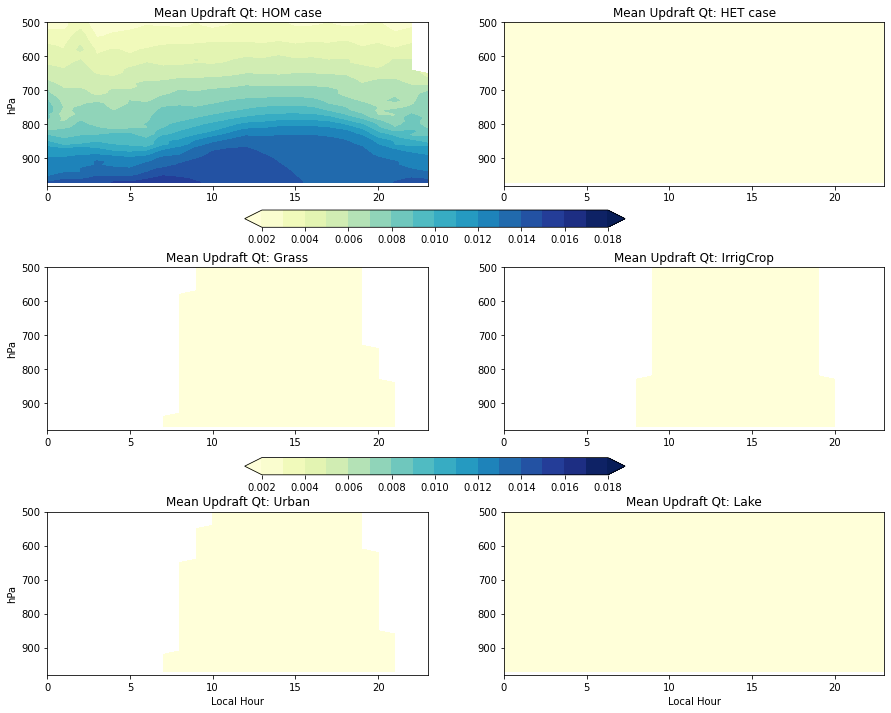

In [39]:
## Look at diurnal cycle of plume properties?
# nplumes_grassMean  = edmf_grass.qtu_macmicAvg_interp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# nplumes_cropMean   = edmf_crop.qtu_macmicAvg_interp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# nplumes_urbanMean  = edmf_urban.qtu_macmicAvg_interp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# nplumes_lakeMean   = edmf_lake.qtu_macmicAvg_interp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')

# nplumes_HOMmean    = edmf_CTRL.qtu_macmicAvg_interp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# nplumes_HETmean    = edmf_HET.qtu_macmicAvg_interp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')

## Look at diurnal cycle of plume initiations?
nplumes_grassMean  = grassDS.qtu_macmicAvg_interp.mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_cropMean   = cropDS.qtu_macmicAvg_interp.mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_urbanMean  = urbanDS.qtu_macmicAvg_interp.mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_lakeMean   = lakeDS.qtu_macmicAvg_interp.mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')

nplumes_HOMmean    = scamDS_h2.qtu_macmicAvg_interp.sel(case='clubbMF').mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_HETmean    = scamDS_h2.qtu_macmicAvg_interp.sel(case='clasp+MF').mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')



## ----- Plot that ----- 
fig,axs = plt.subplots(3,2, figsize=(15,12))
axs = axs.ravel()

## Plot overall means 
axs[0].contourf(nplumes_HOMmean.hour.values, nplumes_HOMmean.levInterp.values, 
                nplumes_HOMmean.values.transpose(), np.arange(0.002,0.019,0.001), 
                cmap = 'YlGnBu', extend='both')
axs[0].set_title('Mean Updraft Qt: HOM case')

cplot = axs[1].contourf(nplumes_HETmean.hour.values, nplumes_HETmean.levInterp.values, 
                nplumes_HETmean.values.transpose(), np.arange(0.002,0.019,0.001), 
                cmap = 'YlGnBu', extend='both')
axs[1].set_title('Mean Updraft Qt: HET case')

# add colorbar for overall mean cases 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.015, ax_position.width, 0.02])
cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)


## Plot patch data 
axs[2].contourf(nplumes_grassMean.hour.values, nplumes_grassMean.levInterp.values, 
                nplumes_grassMean.values.transpose(), np.arange(0.002,0.019,0.001), 
                cmap = 'YlGnBu', extend='both')
axs[2].set_title('Mean Updraft Qt: Grass')

cplot=axs[3].contourf(nplumes_cropMean.hour.values, nplumes_cropMean.levInterp.values, 
                nplumes_cropMean.values.transpose(), np.arange(0.002,0.019,0.001), 
                cmap = 'YlGnBu', extend='both')
axs[3].set_title('Mean Updraft Qt: IrrigCrop')
# add colorbar for individual patches 
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.035, ax_position.width, 0.02])
cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

axs[4].contourf(nplumes_urbanMean.hour.values, nplumes_urbanMean.levInterp.values, 
                nplumes_urbanMean.values.transpose(), np.arange(0.002,0.019,0.001), 
                cmap = 'YlGnBu', extend='both')
axs[4].set_title('Mean Updraft Qt: Urban')

cplot = axs[5].contourf(nplumes_lakeMean.hour.values, nplumes_lakeMean.levInterp.values, 
                nplumes_lakeMean.values.transpose(), np.arange(0.002,0.019,0.001), 
                cmap = 'YlGnBu', extend='both')
axs[5].set_title('Mean Updraft Qt: Lake')


## Other plot options 
axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()

axs[0].set_ylim([980,500])
axs[1].set_ylim([980,500])
axs[2].set_ylim([980,500])
axs[3].set_ylim([980,500])
axs[4].set_ylim([980,500])
axs[5].set_ylim([980,500])

# axs[0].set_xlim([7,19])
# axs[1].set_xlim([7,19])
# axs[2].set_xlim([7,19])
# axs[3].set_xlim([7,19])
# axs[4].set_xlim([7,19])
# axs[5].set_xlim([7,19])

axs[4].set_xlabel('Local Hour')
axs[5].set_xlabel('Local Hour')

axs[0].set_ylabel('hPa')
axs[2].set_ylabel('hPa')
axs[4].set_ylabel('hPa')

fig.subplots_adjust(hspace = 0.5)


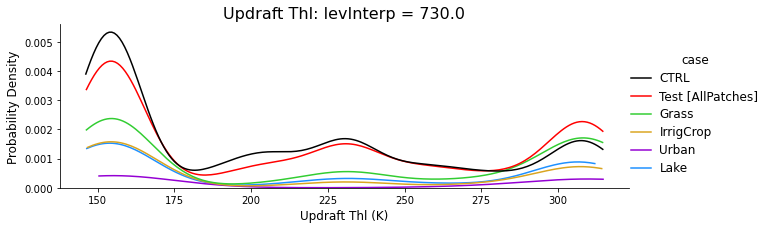

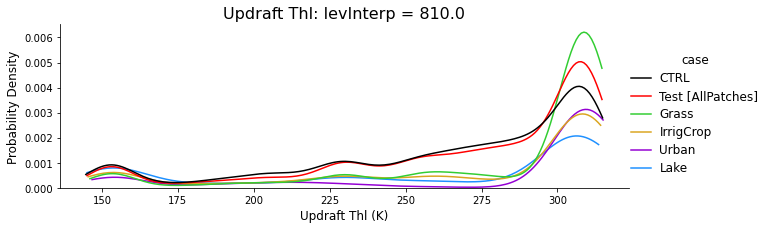

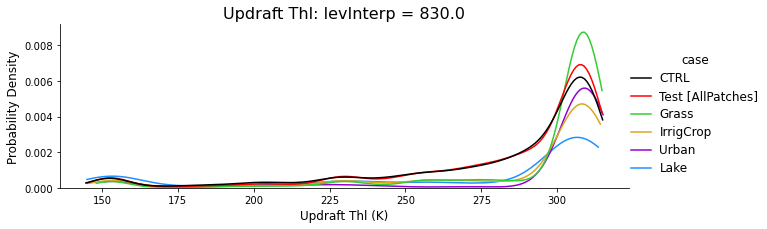

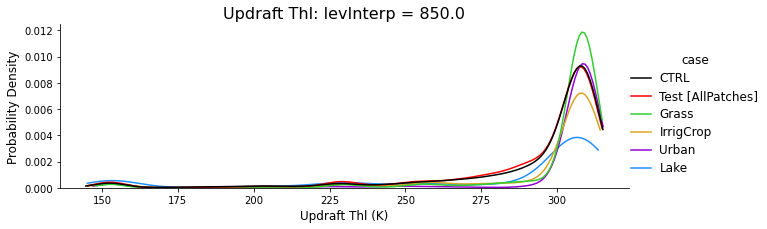

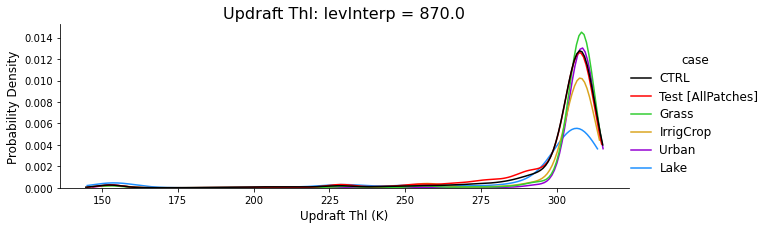

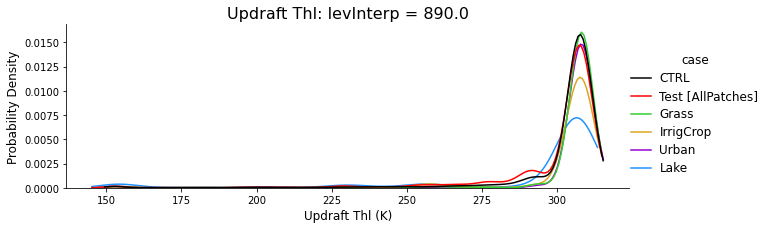

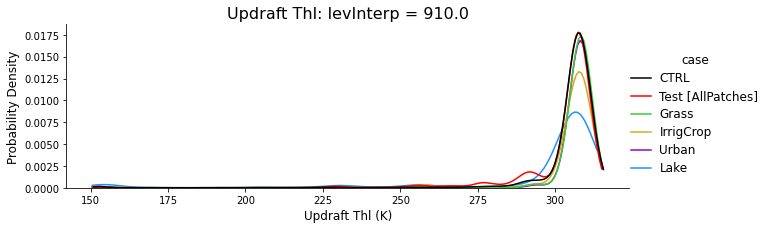

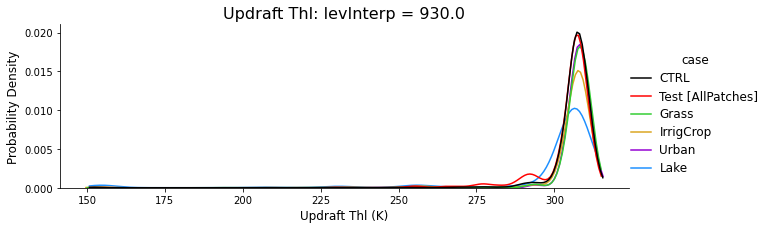

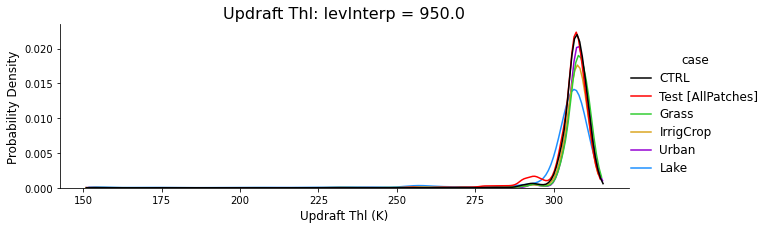

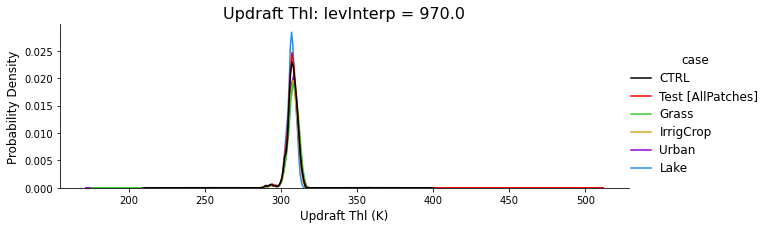

In [41]:
## Data choices 

varSel = 'thlu_macmicAvg_interp'
levSel = [-25,-17,-15,-13,-11,-9,-7,-5,-3,-1]

## Make figures 
for ilev in range(len(levSel)):
    dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_CTRL[varSel].isel(levInterp=levSel[ilev]).values), 'case': 'CTRL'}),
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_HET[varSel].isel(levInterp=levSel[ilev]).values), 'case': 'Test [AllPatches]'}),

        pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_grass[varSel].isel(levInterp=levSel[ilev]).values), 'case': 'Grass'}),
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_crop[varSel].isel(levInterp=levSel[ilev]).values), 'case': 'IrrigCrop'}),
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_urban[varSel].isel(levInterp=levSel[ilev]).values), 'case': 'Urban'}),
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_lake[varSel].isel(levInterp=levSel[ilev]).values), 'case': 'Lake'}),
         ])

    # Make plot 
    g = sns.displot( data=dfReal, x='UpdraftSpeed', hue='case', kind='kde', cut=0,
    #                 fill=True, alpha=0.5,
                    palette=['k','red','limegreen','goldenrod','darkviolet','dodgerblue'],
                   height=3, aspect=9/3, 
                   )

    g.ax.set_title("Updraft Thl: levInterp = "+str(edmf_CTRL.levInterp.values[levSel[ilev]]), fontsize=16 ) 

    g.ax.set_xlabel('Updraft Thl (K)',fontsize=12)
    g.ax.set_ylabel('Probability Density',fontsize=12)
#     g.ax.set_xlim([130, 350])

#     g.ax.tick_params(axis='both', labelsize= 14)

    plt.setp(g._legend.get_title(), fontsize=12)
    plt.setp(g._legend.get_texts(), fontsize=12)




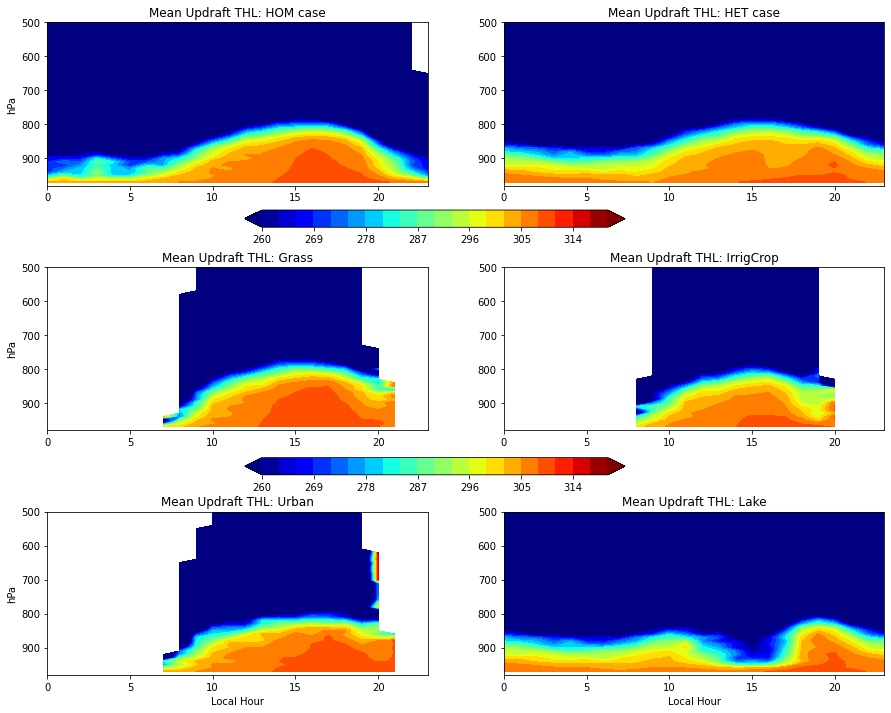

In [42]:
## Look at diurnal cycle of plume properties?
# nplumes_grassMean  = edmf_grass.thlu_macmicAvg_interp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# nplumes_cropMean   = edmf_crop.thlu_macmicAvg_interp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# nplumes_urbanMean  = edmf_urban.thlu_macmicAvg_interp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# nplumes_lakeMean   = edmf_lake.thlu_macmicAvg_interp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')

# nplumes_HOMmean    = edmf_CTRL.thlu_macmicAvg_interp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# nplumes_HETmean    = edmf_HET.thlu_macmicAvg_interp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')

## Look at diurnal cycle of plume initiations?
nplumes_grassMean  = grassDS.thlu_macmicAvg_interp.mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_cropMean   = cropDS.thlu_macmicAvg_interp.mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_urbanMean  = urbanDS.thlu_macmicAvg_interp.mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_lakeMean   = lakeDS.thlu_macmicAvg_interp.mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')

nplumes_HOMmean    = scamDS_h2.thlu_macmicAvg_interp.sel(case='clubbMF').mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_HETmean    = scamDS_h2.thlu_macmicAvg_interp.sel(case='clasp+MF').mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')



## ----- Plot that ----- 
fig,axs = plt.subplots(3,2, figsize=(15,12))
axs = axs.ravel()

minC = 260
maxC = 323
stepC = 3
cmapSel = 'jet'


## Plot overall means 
axs[0].contourf(nplumes_HOMmean.hour.values, nplumes_HOMmean.levInterp.values, 
                nplumes_HOMmean.values.transpose(), np.arange(minC, maxC, stepC), 
                cmap = cmapSel, extend='both')
axs[0].set_title('Mean Updraft THL: HOM case')

cplot = axs[1].contourf(nplumes_HETmean.hour.values, nplumes_HETmean.levInterp.values, 
                nplumes_HETmean.values.transpose(), np.arange(minC, maxC, stepC), 
                cmap = cmapSel, extend='both')
axs[1].set_title('Mean Updraft THL: HET case')

# add colorbar for overall mean cases 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.015, ax_position.width, 0.02])
cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)


## Plot patch data 
axs[2].contourf(nplumes_grassMean.hour.values, nplumes_grassMean.levInterp.values, 
                nplumes_grassMean.values.transpose(), np.arange(minC, maxC, stepC), 
                cmap = cmapSel, extend='both')
axs[2].set_title('Mean Updraft THL: Grass')

cplot=axs[3].contourf(nplumes_cropMean.hour.values, nplumes_cropMean.levInterp.values, 
                nplumes_cropMean.values.transpose(), np.arange(minC, maxC, stepC), 
                cmap = cmapSel, extend='both')
axs[3].set_title('Mean Updraft THL: IrrigCrop')
# add colorbar for individual patches 
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.035, ax_position.width, 0.02])
cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

axs[4].contourf(nplumes_urbanMean.hour.values, nplumes_urbanMean.levInterp.values, 
                nplumes_urbanMean.values.transpose(), np.arange(minC, maxC, stepC), 
                cmap = cmapSel, extend='both')
axs[4].set_title('Mean Updraft THL: Urban')

cplot = axs[5].contourf(nplumes_lakeMean.hour.values, nplumes_lakeMean.levInterp.values, 
                nplumes_lakeMean.values.transpose(), np.arange(minC, maxC, stepC), 
                cmap = cmapSel, extend='both')
axs[5].set_title('Mean Updraft THL: Lake')


## Other plot options 
axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()

axs[0].set_ylim([980,500])
axs[1].set_ylim([980,500])
axs[2].set_ylim([980,500])
axs[3].set_ylim([980,500])
axs[4].set_ylim([980,500])
axs[5].set_ylim([980,500])

# axs[0].set_xlim([7,19])
# axs[1].set_xlim([7,19])
# axs[2].set_xlim([7,19])
# axs[3].set_xlim([7,19])
# axs[4].set_xlim([7,19])
# axs[5].set_xlim([7,19])

axs[4].set_xlabel('Local Hour')
axs[5].set_xlabel('Local Hour')

axs[0].set_ylabel('hPa')
axs[2].set_ylabel('hPa')
axs[4].set_ylabel('hPa')

fig.subplots_adjust(hspace = 0.5)


In [81]:
edmf_grass[varSel].isel(levInterp=-1).max()

<xarray.DataArray 'thlu_macmicAvg_interp' ()>
array(500.40996801)
Coordinates:
    levInterp  float64 970.0
    case       <U8 'clasp+MF'

In [83]:
np.where(edmf_grass[varSel].isel(levInterp=-1).values==edmf_grass[varSel].isel(levInterp=-1).max().values)

(array([3153]),)

In [84]:
edmf_grass.isel(time=3153)

<xarray.Dataset>
Dimensions:                (ilev: 59, lat: 1, lev: 58, levInterp: 78, lon: 1)
Coordinates:
  * lat                    (lat) float64 36.6
  * lon                    (lon) float64 262.5
  * lev                    (lev) float64 3.018 5.445 9.087 ... 983.2 991.2 997.5
  * ilev                   (ilev) float64 2.055 3.98 6.909 ... 987.4 995.1 1e+03
    time                   datetime64[ns] 2017-05-27T09:48:30
  * levInterp              (levInterp) float64 200.0 210.0 220.0 ... 960.0 970.0
    case                   <U8 'clasp+MF'
Data variables:
    edmf_upa               (ilev, lat, lon) float32 nan nan ... 0.005455
    edmf_upw               (ilev, lat, lon) float32 nan nan ... 0.2546 0.3409
    edmf_upqt              (ilev, lat, lon) float32 nan nan ... 0.01628 0.01612
    edmf_upthl             (ilev, lat, lon) float32 nan nan nan ... 307.1 307.1
    edmf_cloudfrac         (lev, lat, lon, ilev) float32 0.0 0.0 0.0 ... 0.0 0.0
    edmf_dnw               (ilev, lat, lon) float32 nan nan nan ... nan 0.0 0.0
    edmf_precc             (ilev, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    edmf_qtflxup           (ilev, lat, lon) float32 0.0 0.0 ... 4.144e-05 0.0
    edmf_thlflxup          (ilev, lat, lon) float32 0.0 0.0 ... -0.004199 0.0
    edmf_S_ATHLTHL         (ilev, lat, lon) float32 0.0 0.0 ... 0.003121
    edmf_S_AQTQT           (ilev, lat, lon) float32 0.0 0.0 ... 7.655e-08
    edmf_S_AWW             (ilev, lat, lon) float32 0.0 0.0 ... 0.03304 0.012
    edmf_upa_interp        (levInterp, lat, lon) float64 nan nan ... 0.001215
    edmf_upw_interp        (levInterp, lat, lon) float64 nan nan ... 0.6209
    edmf_upqt_interp       (levInterp, lat, lon) float64 nan nan ... 0.01628
    edmf_upthl_interp      (levInterp, lat, lon) float64 nan nan ... 307.1 307.1
    edmf_dnw_interp        (levInterp, lat, lon) float64 nan nan nan ... 0.0 0.0
    edmf_qtflxup_interp    (levInterp, lat, lon) float64 0.0 0.0 ... -5.22e-05
    edmf_thlflxup_interp   (levInterp, lat, lon) float64 0.0 0.0 ... 0.00529
    edmf_S_ATHLTHL_interp  (levInterp, lat, lon) float64 0.0 0.0 ... 0.005786
    edmf_S_AQTQT_interp    (levInterp, lat, lon) float64 0.0 0.0 ... 8.544e-08
    edmf_S_AWW_interp      (levInterp, lat, lon) float64 0.0 0.0 ... -0.0145
    up_macmicAvg_interp    (levInterp) float64 nan nan nan ... nan 0.1741 0.7813
    dn_macmicAvg_interp    (levInterp) float64 nan nan nan nan ... nan 0.0 0.0
    upa_macmicAvg_interp   (levInterp) float64 nan nan nan ... 0.0007057 0.00198
    dna_macmicAvg_interp   (levInterp) float64 nan nan nan nan ... nan 0.0 0.0
    thlu_macmicAvg_interp  (levInterp) float64 nan nan nan ... nan 178.4 500.4
    qtu_macmicAvg_interp   (levInterp) float64 nan nan ... 6.984e-06 9.762e-05
    thld_macmicAvg_interp  (levInterp) float64 nan nan nan nan ... nan 0.0 0.0
    qtd_macmicAvg_interp   (levInterp) float64 nan nan nan nan ... nan 0.0 0.0
    total_wp2              (levInterp, lat, lon) float64 0.0004 ... 0.04842
    total_thlp2            (levInterp, lat, lon) float64 0.0001504 ... 0.00335
    total_rtp2             (levInterp, lat, lon) float64 1.28e-14 ... 1.225e-07
    total_wpthlp           (levInterp, lat, lon) float64 -2.355e-05 ... 0.02498
    total_wprtp            (levInterp, lat, lon) float64 7.256e-11 ... 1.755e-05

### Diurnal cycle plots

In [54]:
## Get hourly mean SCAM 
hourlyMeanSCAM  = scamDS.groupby('time.hour').mean(dim='time')
hourlyStdSCAM   = scamDS.groupby('time.hour').std(dim='time')
hourlyCountSCAM = scamDS.groupby('time.hour').count(dim='time')
hourlySE = hourlyStdSCAM/np.sqrt(hourlyCountSCAM)

hourlyMeanSCAM_h2  = scamDS_h2.groupby('time.hour').mean(dim='time')

# hourlyMeanCLM_h0 = clmDS_h0.groupby('time.hour').mean(dim='time')
hourlyMeanCLM_h1 = clmDS_h1.groupby('time.hour').mean(dim='time')


# ## Get mean hourly LES values too 
# hrLES_newDefault = LES_newDefault.groupby('Time.hour').mean(dim='Time')
# hrLES_moments    = LES_allDays_allVarsHr.groupby('time.hour').mean(dim='time')


In [55]:
pltVars = ['SHFLX','LHFLX',
           'TREFHT','QREFHT',
           'SWCF','LWCF',
           'CLDTOT','PRECT',
           'TGCLDLWP','PBLH',
           'CLDLOW','TMQ']

ctrlCase  = 'clubbMF'
testCase  = 'clasp+MF'

ctrlCase2 = 'clubbMF_setSfcFlux'
testCase2 = 'claspMF_setSfcFlux'

fig, axs = plt.subplots(int(len(pltVars)/2), 2, figsize=(13,3.5*len(pltVars)/2) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

for iPlt in range(len(pltVars)):

    axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=ctrlCase).values), 
             color='dodgerblue', label=ctrlCase)
    axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=testCase).values), 
             color='orangered', label=testCase)
    
#     axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=ctrlCase2).values), 
#          color='orangered', linestyle='--', label=ctrlCase2)
#     axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=testCase2).values), 
#          color='dodgerblue', linestyle='--', label=testCase2)

#     if iPlt==2:
#         axs[iPlt].legend(fontsize=12, ncol=2)
    axs[iPlt].legend(fontsize=12, ncol=2)

    # axs.set_ylabel('K kg/kg')
    axs[iPlt].set_xlabel('Hour')
    axs[iPlt].set_title(pltVars[iPlt], fontsize=14)


KeyError: 'edmf_L0'

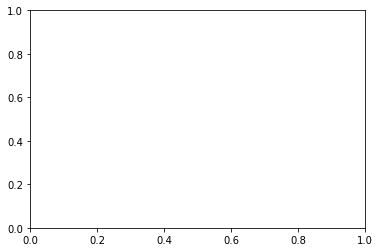

In [56]:
# fig,axs = plt.subplots(1,1, figsize=(6,4))

# axs.plot(hourlyMeanSCAM_h2.hour.values, np.squeeze(hourlyMeanSCAM_h2['edmf_L0'].sel(case=ctrlCase).values), 
#          color='dodgerblue', label=ctrlCase)
# axs.plot(hourlyMeanSCAM_h2.hour.values, np.squeeze(hourlyMeanSCAM_h2['edmf_L0'].sel(case=testCase).values), 
#          color='orangered', label=testCase)
# axs.legend(fontsize=12, ncol=2)
# axs.set_xlabel('Hour')
# axs.set_title('edmf_L0', fontsize=14)

    

In [52]:
uniqDays_scamHMG = scamDS.sel(case='clubbMF').resample(time='1D').mean().dropna(dim='time').time.values
print('SCAM days:    ',    len(uniqDays_scamHMG))
dates            = pd.DatetimeIndex(uniqDays_scamHMG)


SCAM days:     74


### Mean profiles at certain hours?

(-0.5, 5.0)

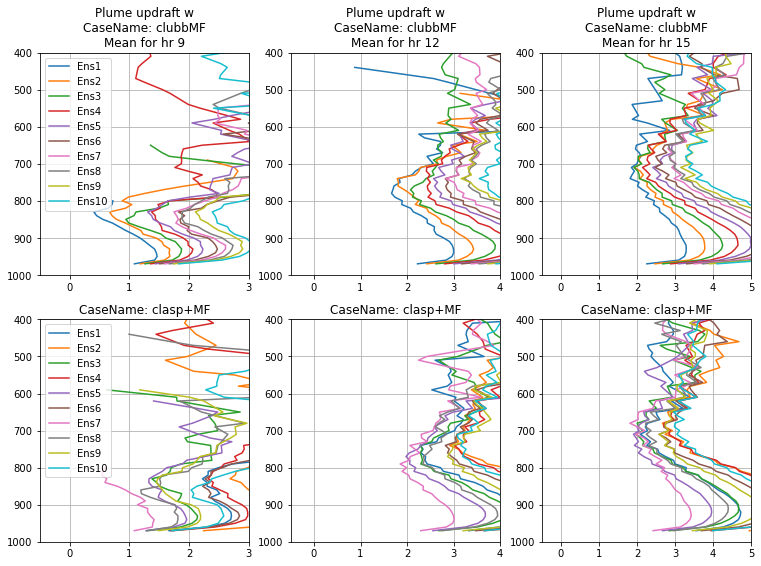

In [59]:
hoursList = [9,12,15]
fig,axs = plt.subplots(2,len(hoursList), figsize=(4.25*len(hoursList),9))
axs = axs.ravel()

caseSel1 = 'clubbMF'
caseSel2 = 'clasp+MF'
# caseSel1 = 'clubbMF_setSfcFlux'
# caseSel2 = 'claspMF_setSfcFlux'

# varSel   = 'edmf_upqt_interp' 
# levVar   = 'levInterp'
# longName = 'Plume updraft qt'

# varSel   = 'edmf_upthl_interp' 
# levVar   = 'levInterp'
# longName = 'Plume updraft thl'

varSel   = 'up_macmicAvg_interp' 
levVar   = 'levInterp'
longName = 'Plume updraft w'

# varSel   = 'edmf_upbuoy_interp' 
# levVar   = 'levInterp'
# longName = 'Plume updraft buoyancy'

# varSel   = 'edmf_updet_interp' 
# levVar   = 'levInterp'
# longName = 'Plume updraft detrainment'

# varSel   = 'edmf_upa_interp' 
# levVar   = 'levInterp'
# longName = 'Plume updraft area'

for iHour in range(len(hoursList)):
    hourSel = hoursList[iHour]

    for iEns in range(len(hourlyMeanSCAM_h2.nens.values)):
        ensSel1 = hourlyMeanSCAM_h2.sel(hour=hourSel, case=caseSel1).isel(nens=iEns)
        ensSel2 = hourlyMeanSCAM_h2.sel(hour=hourSel, case=caseSel2).isel(nens=iEns)

        axs[iHour].plot(ensSel1[varSel].values, ensSel1[levVar].values, label='Ens'+str(iEns+1))
        axs[iHour+3].plot(ensSel2[varSel].values, ensSel2[levVar].values, label='Ens'+str(iEns+1))

    if iHour==0:
        axs[iHour].legend()
        axs[iHour+3].legend()
    
    axs[iHour].invert_yaxis()
    axs[iHour+3].invert_yaxis()

    axs[iHour].set_ylim([1000,400])
    axs[iHour+3].set_ylim([1000,400])

    axs[iHour].set_title(longName+'\nCaseName: '+caseSel1+'\nMean for hr '+str(hourSel))
    axs[iHour+3].set_title('CaseName: '+caseSel2)

    axs[iHour].grid()
    axs[iHour+3].grid()

# # EDMF_upthl limits: 
# axs[0].set_xlim([294,306])
# axs[3].set_xlim([294,306])

# axs[1].set_xlim([303,315])
# axs[4].set_xlim([303,315])

# axs[2].set_xlim([305,315])
# axs[5].set_xlim([305,315])

# # EDMF_upqt limits: 
# axs[0].set_xlim([0.01,0.0145])
# axs[3].set_xlim([0.01,0.0145])

# axs[1].set_xlim([0.008, 0.012])
# axs[4].set_xlim([0.008, 0.012])

# axs[2].set_xlim([0.008, 0.0115])
# axs[5].set_xlim([0.008, 0.0115])

# EDMF_upw limits: 
axs[0].set_xlim([-0.5,3])
axs[3].set_xlim([-0.5,3])

axs[1].set_xlim([-0.5, 4])
axs[4].set_xlim([-0.5, 4])

axs[2].set_xlim([-0.5, 5])
axs[5].set_xlim([-0.5, 5])



### Look at mean over certain periods

In [61]:
iMorn = np.where((scamDS['time.hour'].values>=8) & (scamDS['time.hour'].values<=10))[0]
iAftn = np.where((scamDS['time.hour'].values>=12) & (scamDS['time.hour'].values<=17))[0]
iEvng = np.where((scamDS['time.hour'].values>=18) & (scamDS['time.hour'].values<=20))[0]

mornDS = scamDS.isel(time=iMorn).mean(dim='time')
aftnDS = scamDS.isel(time=iAftn).mean(dim='time')
evngDS = scamDS.isel(time=iEvng).mean(dim='time')

mornDS_h2 = scamDS_h2.isel(time=iMorn).mean(dim='time')
aftnDS_h2 = scamDS_h2.isel(time=iAftn).mean(dim='time')
evngDS_h2 = scamDS_h2.isel(time=iEvng).mean(dim='time')


In [62]:
tableVars = ['PRECT','CLDTOT','TGCLDLWP','TMQ','CLDLOW','SWCF','LWCF']

print('                                       clubb/clasp')
print('                    (8-10a)             (12-5p)                (6-8p)')
print('Variable          MorningMean        AfternoonMean        EveningMean')
  
for iVar in range(len(tableVars)):
    print('%10s  %8.3f / %7.3f  %8.3f / %7.3f  %8.3f / %7.3f' % (tableVars[iVar], 
                    mornDS[tableVars[iVar]].sel(case='clubbMF'), mornDS[tableVars[iVar]].sel(case='clasp+MF'), 
                    aftnDS[tableVars[iVar]].sel(case='clubbMF'), aftnDS[tableVars[iVar]].sel(case='clasp+MF'), 
                    evngDS[tableVars[iVar]].sel(case='clubbMF'), evngDS[tableVars[iVar]].sel(case='clasp+MF'), 
                                  ) )
    
    

                                       clubb/clasp
                    (8-10a)             (12-5p)                (6-8p)
Variable          MorningMean        AfternoonMean        EveningMean
     PRECT     0.000 /   0.000     0.000 /   0.000     0.000 /   0.000
    CLDTOT     0.351 /   0.342     0.288 /   0.299     0.290 /   0.316
  TGCLDLWP     0.012 /   0.012     0.012 /   0.012     0.010 /   0.011
       TMQ    37.854 /  37.846    38.697 /  38.700    38.735 /  38.746
    CLDLOW     0.094 /   0.086     0.024 /   0.024     0.001 /   0.018
      SWCF    -2.454 /  -2.446    -2.044 /  -2.183    -0.867 /  -0.864
      LWCF     0.985 /   1.006     1.003 /   1.033     1.060 /   1.048


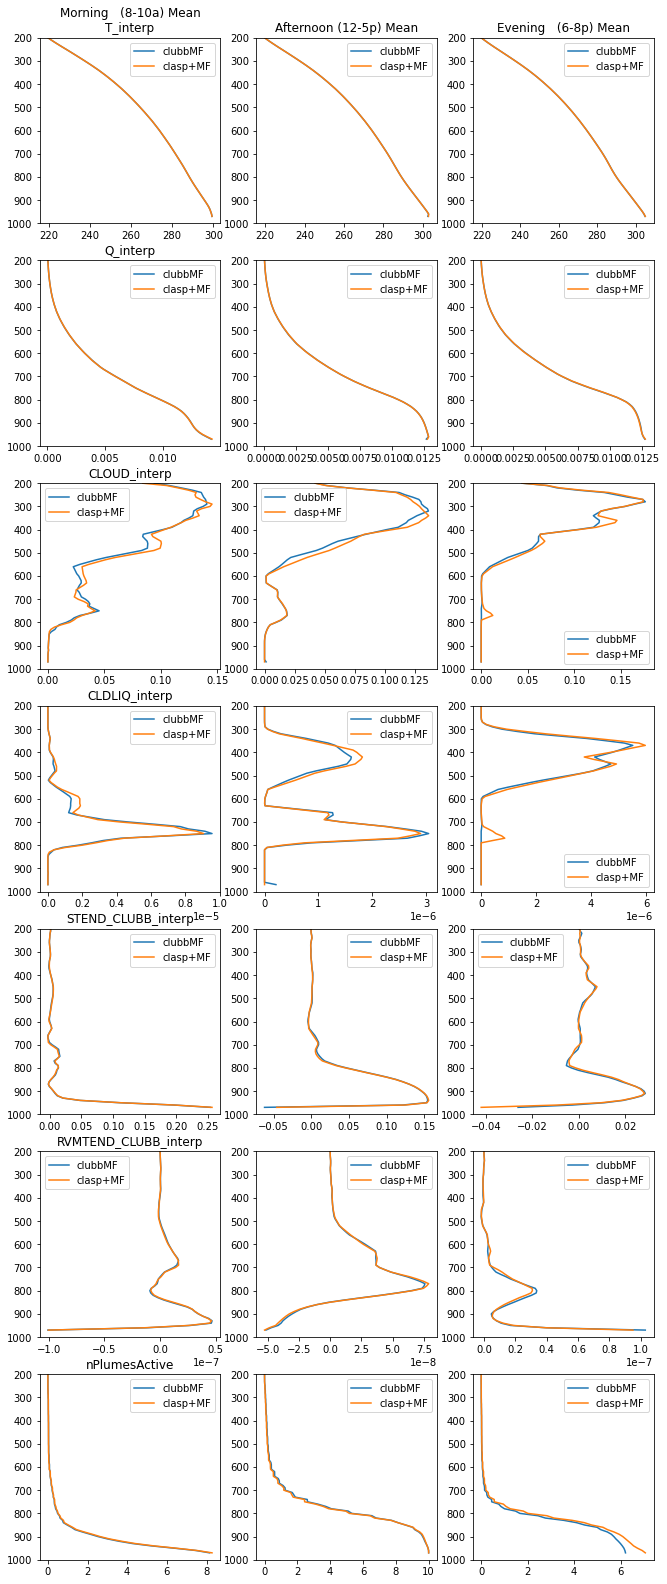

In [63]:
pltVars = ['T_interp','Q_interp','CLOUD_interp','CLDLIQ_interp',
           'STEND_CLUBB_interp','RVMTEND_CLUBB_interp',
           'nPlumesActive']

ctrlCase = 'clubbMF'
testCase = 'clasp+MF'

maxLev   = 200

minX = [280, 0.005, -0.01, -0.1e-5]
maxX = [308, 0.013, 0.06,  1.2e-5]

useH2 = False

fig,axs = plt.subplots(len(pltVars),3, figsize=(11,4*len(pltVars)))
axs = axs.ravel()

for iVar in range(len(pltVars)):
    if useH2: 
        axs[(iVar*3)].plot(mornDS_h2[pltVars[iVar]].sel(case=ctrlCase).values, 
                           mornDS_h2.levInterp.values)
    else: 
        axs[(iVar*3)].plot(np.squeeze(mornDS[pltVars[iVar]].sel(case=ctrlCase).values), 
                           mornDS.levInterp.values, label=ctrlCase)
        axs[(iVar*3)].plot(np.squeeze(mornDS[pltVars[iVar]].sel(case=testCase).values), 
                           mornDS.levInterp.values, label=testCase)
        
        axs[(iVar*3)+1].plot(np.squeeze(aftnDS[pltVars[iVar]].sel(case=ctrlCase).values), 
                           aftnDS.levInterp.values, label=ctrlCase)
        axs[(iVar*3)+1].plot(np.squeeze(aftnDS[pltVars[iVar]].sel(case=testCase).values), 
                           aftnDS.levInterp.values, label=testCase)
    
        axs[(iVar*3)+2].plot(np.squeeze(evngDS[pltVars[iVar]].sel(case=ctrlCase).values), 
                           evngDS.levInterp.values, label=ctrlCase)
        axs[(iVar*3)+2].plot(np.squeeze(evngDS[pltVars[iVar]].sel(case=testCase).values), 
                           evngDS.levInterp.values, label=testCase)
        
    axs[(iVar*3)].legend()
    axs[(iVar*3)].invert_yaxis()
    axs[(iVar*3)].set_ylim([1000, maxLev])
#     axs[(iVar*3)].set_xlim([minX[iVar], maxX[iVar]])
    
        
    axs[(iVar*3)+1].legend()
    axs[(iVar*3)+1].invert_yaxis()
    axs[(iVar*3)+1].set_ylim([1000, maxLev])
#     axs[(iVar*3)+1].set_xlim([minX[iVar], maxX[iVar]])
    
    axs[(iVar*3)+2].legend()
    axs[(iVar*3)+2].invert_yaxis()
    axs[(iVar*3)+2].set_ylim([1000, maxLev])
#     axs[(iVar*3)+2].set_xlim([minX[iVar], maxX[iVar]])
    
    if iVar==0:
        axs[iVar+0].set_title('Morning   (8-10a) Mean\n'+pltVars[iVar])
        axs[iVar+1].set_title('Afternoon (12-5p) Mean')
        axs[iVar+2].set_title('Evening   (6-8p) Mean')
    else:
        axs[iVar*3].set_title(pltVars[iVar])

    

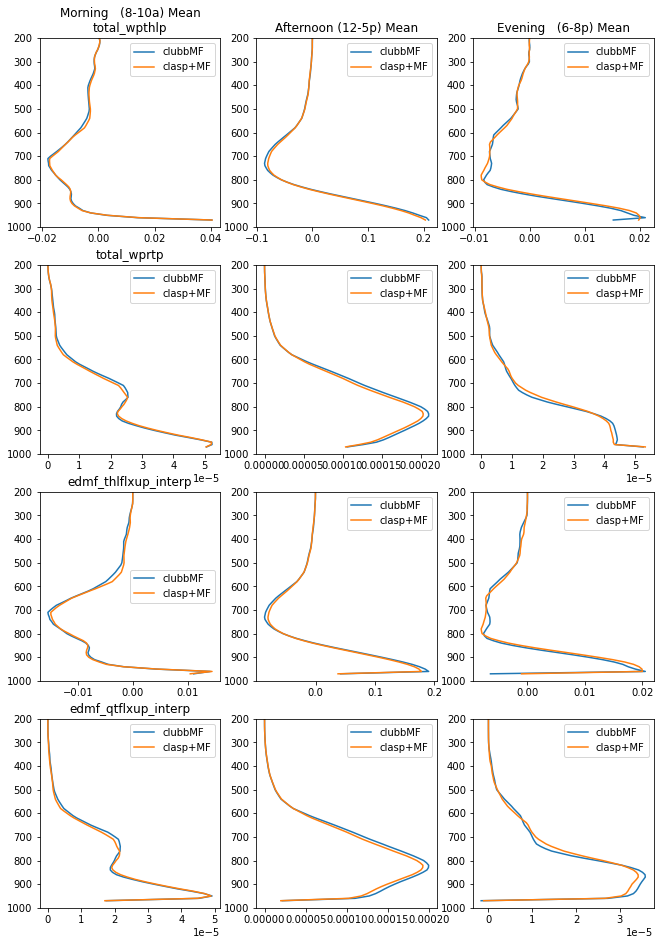

In [64]:
pltVars = ['total_wpthlp','total_wprtp',
           'edmf_thlflxup_interp', 'edmf_qtflxup_interp']

ctrlCase = 'clubbMF'
testCase = 'clasp+MF'

maxLev   = 200

minX = [280, 0.005, -0.01, -0.1e-5]
maxX = [308, 0.013, 0.06,  1.2e-5]

useH2 = True

fig,axs = plt.subplots(len(pltVars),3, figsize=(11,4*len(pltVars)))
axs = axs.ravel()

for iVar in range(len(pltVars)):
    if useH2: 
        axs[(iVar*3)].plot(np.squeeze(mornDS_h2[pltVars[iVar]].sel(case=ctrlCase).values), 
                           mornDS_h2.levInterp.values, label=ctrlCase)
        axs[(iVar*3)].plot(np.squeeze(mornDS_h2[pltVars[iVar]].sel(case=testCase).values), 
                           mornDS_h2.levInterp.values, label=testCase)
        
        axs[(iVar*3)+1].plot(np.squeeze(aftnDS_h2[pltVars[iVar]].sel(case=ctrlCase).values), 
                           aftnDS_h2.levInterp.values, label=ctrlCase)
        axs[(iVar*3)+1].plot(np.squeeze(aftnDS_h2[pltVars[iVar]].sel(case=testCase).values), 
                           aftnDS_h2.levInterp.values, label=testCase)
    
        axs[(iVar*3)+2].plot(np.squeeze(evngDS_h2[pltVars[iVar]].sel(case=ctrlCase).values), 
                           evngDS_h2.levInterp.values, label=ctrlCase)
        axs[(iVar*3)+2].plot(np.squeeze(evngDS_h2[pltVars[iVar]].sel(case=testCase).values), 
                           evngDS_h2.levInterp.values, label=testCase)
    else: 
        axs[(iVar*3)].plot(np.squeeze(mornDS[pltVars[iVar]].sel(case=ctrlCase).values), 
                           mornDS.levInterp.values, label=ctrlCase)
        axs[(iVar*3)].plot(np.squeeze(mornDS[pltVars[iVar]].sel(case=testCase).values), 
                           mornDS.levInterp.values, label=testCase)
        
        axs[(iVar*3)+1].plot(np.squeeze(aftnDS[pltVars[iVar]].sel(case=ctrlCase).values), 
                           aftnDS.levInterp.values, label=ctrlCase)
        axs[(iVar*3)+1].plot(np.squeeze(aftnDS[pltVars[iVar]].sel(case=testCase).values), 
                           aftnDS.levInterp.values, label=testCase)
    
        axs[(iVar*3)+2].plot(np.squeeze(evngDS[pltVars[iVar]].sel(case=ctrlCase).values), 
                           evngDS.levInterp.values, label=ctrlCase)
        axs[(iVar*3)+2].plot(np.squeeze(evngDS[pltVars[iVar]].sel(case=testCase).values), 
                           evngDS.levInterp.values, label=testCase)
        
    axs[(iVar*3)].legend()
    axs[(iVar*3)].invert_yaxis()
    axs[(iVar*3)].set_ylim([1000, maxLev])
#     axs[(iVar*3)].set_xlim([minX[iVar], maxX[iVar]])
    
        
    axs[(iVar*3)+1].legend()
    axs[(iVar*3)+1].invert_yaxis()
    axs[(iVar*3)+1].set_ylim([1000, maxLev])
#     axs[(iVar*3)+1].set_xlim([minX[iVar], maxX[iVar]])
    
    axs[(iVar*3)+2].legend()
    axs[(iVar*3)+2].invert_yaxis()
    axs[(iVar*3)+2].set_ylim([1000, maxLev])
#     axs[(iVar*3)+2].set_xlim([minX[iVar], maxX[iVar]])
    
    if iVar==0:
        axs[iVar+0].set_title('Morning   (8-10a) Mean\n'+pltVars[iVar])
        axs[iVar+1].set_title('Afternoon (12-5p) Mean')
        axs[iVar+2].set_title('Evening   (6-8p) Mean')
    else:
        axs[iVar*3].set_title(pltVars[iVar])
    

### Time-height plots

In [65]:
## Get hourly mean SCAM 
hourlyMeanSCAM  = scamDS.groupby('time.hour').mean(dim='time')
hourlyStdSCAM   = scamDS.groupby('time.hour').std(dim='time')
hourlyCountSCAM = scamDS.groupby('time.hour').count(dim='time')
hourlySE = hourlyStdSCAM/np.sqrt(hourlyCountSCAM)

hourlyMeanSCAM_h2  = scamDS_h2.groupby('time.hour').mean(dim='time')
hourlyStdSCAM_h2   = scamDS_h2.groupby('time.hour').std(dim='time')
hourlyCountSCAM_h2 = scamDS_h2.groupby('time.hour').count(dim='time')
hourlySE_h2 = hourlyStdSCAM_h2/np.sqrt(hourlyCountSCAM_h2)


In [66]:
## Add significance testing 
CIlevel = 1.960   ## 95% CI
# CIlevel = 1.645   ## 90% CI

CI = CIlevel*hourlySE
lowCI = hourlyMeanSCAM - CI
hghCI = hourlyMeanSCAM + CI

# CI_h2 = CIlevel*hourlySE_h2
# lowCI_h2 = hourlyMeanSCAM_h2 - CI_h2
# hghCI_h2 = hourlyMeanSCAM_h2 + CI_h2




**SCAM HOM case and HET-HOM case**

In [67]:
# Set up figure
pltVars  = ['CLDLIQ_interp', 
            'CLOUD_interp',
            'CONCLD_interp',
            'QT_interp',
           ]

cMin    = [0.0, 
           0.0,
           0.0,
           0.0,
          ]

cMax    = [0.5e-4,
           0.5,
           0.1e-2,
           0.1e-1,
          ]

diffMax = [0.4e-5,
           0.05,
           0.2e-2, 
           0.2e-3, 
          ]

multpl = [
          1,
          1,
          1,
          1, 
         ]

maxLev  = 500

units = [
         r'kg/kg',
         r'fraction',
         r'fraction',
         r'kg/kg', 
        ]

cfmt_hmg = ['%.3e', '%.3f','%.3e','%.3e'] # colorbar label formater
cfmt_htg = ['%.3e', '%.3f','%.3e','%.3e'] # colorbar label formater


subPltLabel = [['(a)','(b)'],
               ['(c)','(d)'],
               ['(e)','(f)'],
               ['(g)','(h)'],
               ['(i)','(j)'],
               ['(k)','(l)']]

varLabel    = [
               r" $\overline{CLDLIQ_{interp}}$",
               r" $\overline{CLOUD_{interp}}$",
               r" $\overline{CONCLD_{interp}}$",
               r" $\overline{QT_{interp}}$",
              ]


fig, axs = plt.subplots(len(pltVars), 2, figsize=(11,3.25*len(pltVars)) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

# Set up case 
ctrlCase = 'clubbMF'
testCase = 'clasp+MF'
# ctrlCase = 'clubbMF_setSfcFlux'
# testCase = 'claspMF_setSfcFlux'

# ctrlDS    = hourlyMeanSCAM.sel(case=ctrlCase)
# testDS    = hourlyMeanSCAM.sel(case=testCase)
# diffCases = testDS - ctrlDS

for iVar in range(len(pltVars)): 
    
    if pltVars[iVar]=='edmf_cloudfrac_interp':
        ctrlDS    = hourlyMeanSCAM_h2.sel(case=ctrlCase)
        testDS    = hourlyMeanSCAM_h2.sel(case=testCase)
        diffCases = testDS - ctrlDS        
    else:
        ctrlDS    = hourlyMeanSCAM.sel(case=ctrlCase)
        testDS    = hourlyMeanSCAM.sel(case=testCase)
        diffCases = testDS - ctrlDS
    
# for iVar in range(2): 
    # - - - - Plot control case - - - -
    cplt = axs[iVar*2].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[iVar*2].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                    np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
    ## Add inset text for max/min
    varVal,varHgt,varTime = getMaxValHeightTime(ctrlDS, pltVars[iVar], maxLev, 'levInterp','hour')

    axs[iVar*2].text(8,560,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[iVar*2].text(8,630,'(%i hPa, hour %i)' % (varHgt,varTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Plot difference case - - - -
    nStep = (2*diffMax[iVar])/26
    
    cplt = axs[(iVar*2)+1].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                    np.squeeze(diffCases[pltVars[iVar]].values* multpl[iVar]).transpose(),
                    np.arange(-diffMax[iVar], diffMax[iVar]+nStep, nStep), cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[(iVar*2)+1], format=cfmt_htg[iVar],
                        ticks=[-diffMax[iVar], -diffMax[iVar]/2, 0, diffMax[iVar]/2, diffMax[iVar]])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11)  
    
    ## Add inset text for max difference 
    diffVal,diffHgt,diffTime = getMaxValHeightTime(diffCases, pltVars[iVar], maxLev, 'levInterp','hour')
    
    axs[(iVar*2)+1].text(8,560,r'$Max  \Delta:$ %.2g' % (diffVal* multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[(iVar*2)+1].text(8,630,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    ## Add significance testing 
    levSig    = getStatSigCI(len(diffCases.hour.values), 
                                   len(diffCases.levInterp.values), pltVars[iVar],   ctrlCase, testCase)  

    for iHr in range(len(diffCases.hour.values)): 
        for iLev in range(len(diffCases.levInterp.values)): 
            if levSig[iHr, iLev]==1: 
                axs[(iVar*2)+1].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                            'ko',alpha=0.3,markersize=1)

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Other plot options - - - -
    axs[iVar*2].invert_yaxis()
    axs[(iVar*2)+1].invert_yaxis()

    axs[(iVar*2)].set_ylim([975, maxLev])
    axs[(iVar*2)+1].set_ylim([975, maxLev])

    axs[(iVar*2)].set_title(subPltLabel[iVar][0], loc='left')
    axs[(iVar*2)].set_title(varLabel[iVar])
    
    if iVar==0:
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')
        axs[(iVar*2)+1].set_title(r'$claspMF - clubbMF$')
    else: 
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')

    axs[(iVar*2)].set_ylabel('hPa')
    
    axs[(iVar*2)].set_xlim([6.8,21.2])
    axs[(iVar*2)+1].set_xlim([6.8,21.2])
    axs[(iVar*2)].set_xticks([8,10,12,14,16,18,20])
    axs[(iVar*2)+1].set_xticks([8,10,12,14,16,18,20])
    
    if iVar==len(pltVars)-1: 
        axs[(iVar*2)].set_xlabel('Local Hour')
        axs[(iVar*2)+1].set_xlabel('Local Hour')
        


In [70]:
def getStatSigCI_h2(nTimes, nLevs, varSel, ctrlCase, testCase, CIlevel): 

    ## Get ranges for each case's CI 
    CI_h2_ctrl           = CIlevel*hourlySE_h2.sel(case=ctrlCase).isel()[varSel]
    CI_h2_test           = CIlevel*hourlySE_h2.sel(case=testCase).isel()[varSel]

#     ctrlDS_lowCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)[varSel], -CI_h2_ctrl], axis=0)
#     testDS_lowCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=testCase).isel(lon=0,lat=0)[varSel], -CI_h2_test], axis=0)

#     ctrlDS_hghCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)[varSel], CI_h2_ctrl], axis=0)
#     testDS_hghCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=testCase).isel(lon=0,lat=0)[varSel], CI_h2_test], axis=0)

    ctrlDS_lowCI    = hourlyMeanSCAM_h2.sel(case=ctrlCase).isel()[varSel] -CI_h2_ctrl
    testDS_lowCI    = hourlyMeanSCAM_h2.sel(case=testCase).isel()[varSel] -CI_h2_test

    ctrlDS_hghCI    = hourlyMeanSCAM_h2.sel(case=ctrlCase).isel()[varSel] + CI_h2_ctrl
    testDS_hghCI    = hourlyMeanSCAM_h2.sel(case=testCase).isel()[varSel] + CI_h2_test



    levSig = np.full([nTimes, nLevs], np.nan)

    for iHr in range(nTimes): 
        for iLev in range(nLevs):

            # Not significant range?
            if ( (testDS_lowCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_lowCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (testDS_hghCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_hghCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            
            elif ( (ctrlDS_lowCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_lowCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (ctrlDS_hghCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_hghCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0       
            
            elif np.isfinite(testDS_lowCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0
            elif np.isfinite(ctrlDS_lowCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0            
            elif np.isfinite(testDS_hghCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0
            elif np.isfinite(ctrlDS_hghCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0  
                
            else:
                levSig[iHr, iLev] = 1 
    
    return levSig

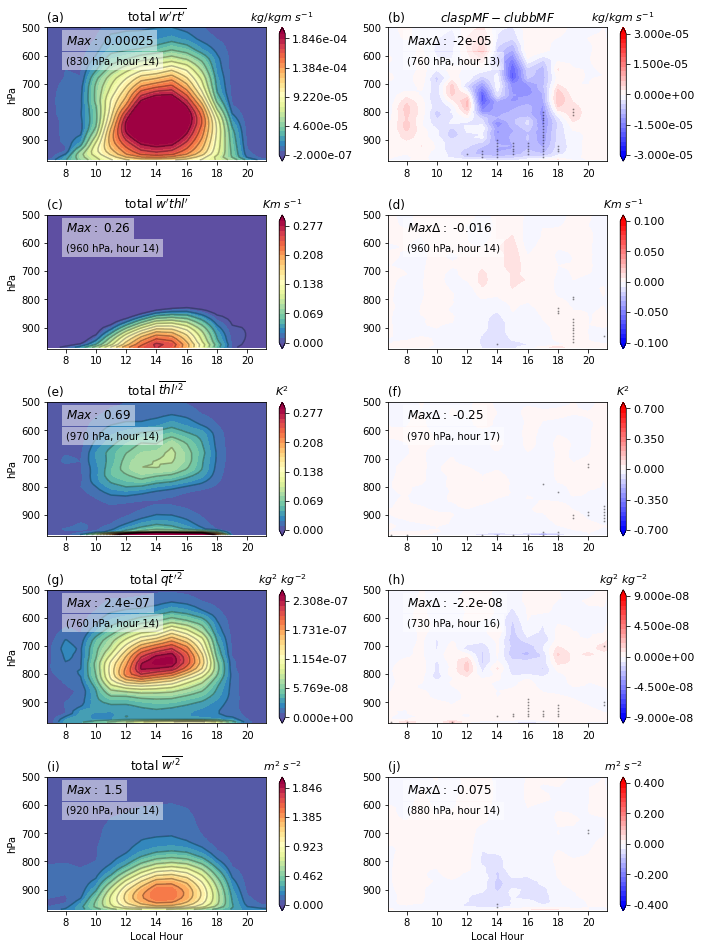

In [71]:
# Set up figure
pltVars  = [
            'total_wprtp',
            'total_wpthlp', 
            'total_thlp2',
            'total_rtp2',
            'total_wp2',
           ]

cMin    = [
          -2e-7, 
           0.0,
           0.0,
           0.0,
           0.0,
          ]

cMax    = [
           2e-4,
           0.3,
           0.3,
           2.5e-7,
           2.0,
          ]

diffMax = [
           3.0e-5,
           0.1,
           0.7, 
           9e-8,
           0.40,
          ]

multpl = [
          1,
          1,
          1,
          1, 
          1,
         ]

maxLev  = 500

units = [
         r'$kg/kg m$ $s^{-1}$',
         r'$K m$ $s^{-1}$',
         r'$K^{2}$',
         r'$kg^{2}$ $kg^{-2}$',
         r'$m^{2}$ $s^{-2}$',
        ]

cfmt_hmg = ['%.3e', '%.3f', '%.3f', '%.3e', '%.3f'] # colorbar label formater
cfmt_htg = ['%.3e', '%.3f', '%.3f', '%.3e', '%.3f'] # colorbar label formater


subPltLabel = [['(a)','(b)'],
               ['(c)','(d)'],
               ['(e)','(f)'],
               ['(g)','(h)'],
               ['(i)','(j)'],
               ['(k)','(l)']]

varLabel    = [
               r"total $\overline{w'rt'}$",
               r"total $\overline{w'thl'}$",
               r"total $\overline{thl'^2}$",
               r"total $\overline{qt'^2}$",
               r"total $\overline{w'^2}$",
              ]


fig, axs = plt.subplots(len(pltVars), 2, figsize=(11,3.25*len(pltVars)) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

# Set up case 
ctrlCase = 'clubbMF'
testCase = 'clasp+MF'
# ctrlCase = 'clubbMF_setSfcFlux'
# testCase = 'claspMF_setSfcFlux'

ctrlDS    = hourlyMeanSCAM_h2.sel(case=ctrlCase)
testDS    = hourlyMeanSCAM_h2.sel(case=testCase)
diffCases = testDS - ctrlDS

for iVar in range(len(pltVars)): 
# for iVar in range(2): 
    # - - - - Plot control case - - - -
    cplt = axs[iVar*2].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[iVar*2].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                    np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
    ## Add inset text for max/min
    varVal,varHgt,varTime = getMaxValHeightTime(ctrlDS, pltVars[iVar], maxLev, 'levInterp','hour')

    axs[iVar*2].text(8,560,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[iVar*2].text(8,630,'(%i hPa, hour %i)' % (varHgt,varTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Plot difference case - - - -
    nStep = (2*diffMax[iVar])/26
    
    cplt = axs[(iVar*2)+1].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                    np.squeeze(diffCases[pltVars[iVar]].values* multpl[iVar]).transpose(),
                    np.arange(-diffMax[iVar], diffMax[iVar]+nStep, nStep), cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[(iVar*2)+1], format=cfmt_htg[iVar],
                        ticks=[-diffMax[iVar], -diffMax[iVar]/2, 0, diffMax[iVar]/2, diffMax[iVar]])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11)  
    
    ## Add inset text for max difference 
    diffVal,diffHgt,diffTime = getMaxValHeightTime(diffCases, pltVars[iVar], maxLev, 'levInterp','hour')
    
    axs[(iVar*2)+1].text(8,560,r'$Max  \Delta:$ %.2g' % (diffVal* multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[(iVar*2)+1].text(8,630,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    ## Add significance testing 
    levSig    = getStatSigCI_h2(len(diffCases.hour.values), 
                                   len(diffCases.levInterp.values), pltVars[iVar],   ctrlCase, testCase, CIlevel)  

    for iHr in range(len(diffCases.hour.values)): 
        for iLev in range(len(diffCases.levInterp.values)): 
            if levSig[iHr, iLev]==1: 
                axs[(iVar*2)+1].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                            'ko',alpha=0.3,markersize=1)

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Other plot options - - - -
    axs[iVar*2].invert_yaxis()
    axs[(iVar*2)+1].invert_yaxis()

    axs[(iVar*2)].set_ylim([975, maxLev])
    axs[(iVar*2)+1].set_ylim([975, maxLev])

    axs[(iVar*2)].set_title(subPltLabel[iVar][0], loc='left')
    axs[(iVar*2)].set_title(varLabel[iVar])
    
    if iVar==0:
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')
        axs[(iVar*2)+1].set_title(r'$claspMF - clubbMF$')
    else: 
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')

    axs[(iVar*2)].set_ylabel('hPa')
    
    axs[(iVar*2)].set_xlim([6.8,21.2])
    axs[(iVar*2)+1].set_xlim([6.8,21.2])
    axs[(iVar*2)].set_xticks([8,10,12,14,16,18,20])
    axs[(iVar*2)+1].set_xticks([8,10,12,14,16,18,20])
    
    if iVar==len(pltVars)-1: 
        axs[(iVar*2)].set_xlabel('Local Hour')
        axs[(iVar*2)+1].set_xlabel('Local Hour')


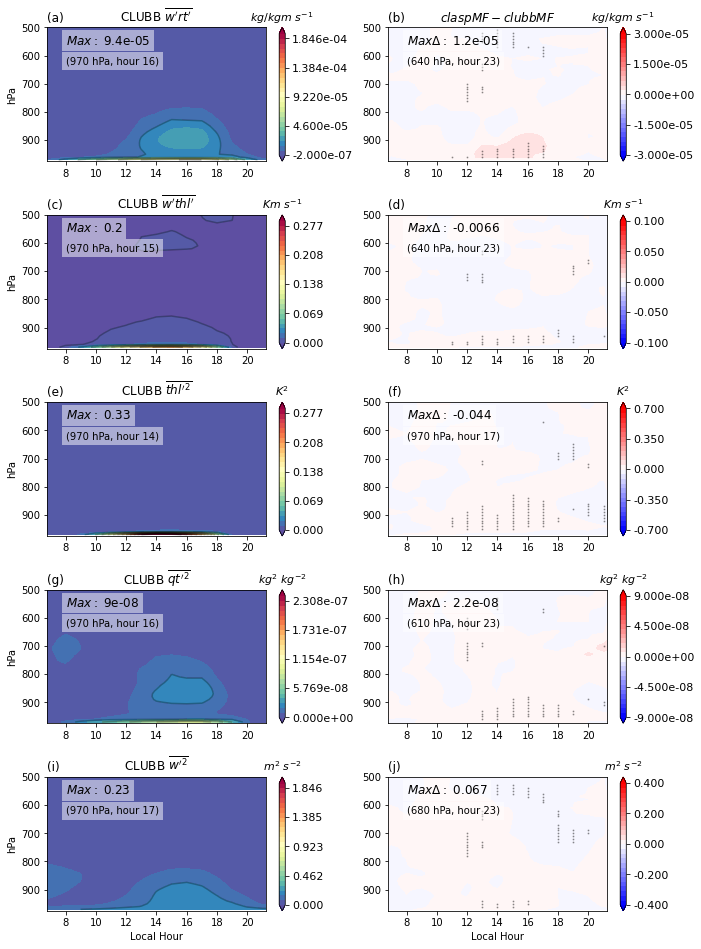

In [72]:
# Set up figure -- CLUBB components 
pltVars  = [
            'wprtp_interp',
            'wpthlp_interp', 
            'THLP2_CLUBB_interp',
            'RTP2_CLUBB_interp',
            'WP2_CLUBB_interp',
           ]

cMin    = [
          -2e-7, 
           0.0,
           0.0,
           0.0,
           0.0,
          ]

cMax    = [
           2e-4,
           0.3,
           0.3,
           2.5e-7,
           2.0,
          ]

diffMax = [
           3.0e-5,
           0.1,
           0.7, 
           9e-8,
           0.40,
          ]

multpl = [
          1,
          1,
          1,
          1e-6, 
          1,
         ]

maxLev  = 500

units = [
         r'$kg/kg m$ $s^{-1}$',
         r'$K m$ $s^{-1}$',
         r'$K^{2}$',
         r'$kg^{2}$ $kg^{-2}$',
         r'$m^{2}$ $s^{-2}$',
        ]

cfmt_hmg = ['%.3e', '%.3f', '%.3f', '%.3e', '%.3f'] # colorbar label formater
cfmt_htg = ['%.3e', '%.3f', '%.3f', '%.3e', '%.3f'] # colorbar label formater


subPltLabel = [['(a)','(b)'],
               ['(c)','(d)'],
               ['(e)','(f)'],
               ['(g)','(h)'],
               ['(i)','(j)'],
               ['(k)','(l)']]

varLabel    = [
               r"CLUBB $\overline{w'rt'}$",
               r"CLUBB $\overline{w'thl'}$",
               r"CLUBB $\overline{thl'^2}$",
               r"CLUBB $\overline{qt'^2}$",
               r"CLUBB $\overline{w'^2}$",
              ]


fig, axs = plt.subplots(len(pltVars), 2, figsize=(11,3.25*len(pltVars)) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

# Set up case 
ctrlCase = 'clubbMF'
testCase = 'clasp+MF'
# ctrlCase = 'clubbMF_setSfcFlux'
# testCase = 'claspMF_setSfcFlux'

ctrlDS    = hourlyMeanSCAM.sel(case=ctrlCase)
testDS    = hourlyMeanSCAM.sel(case=testCase)
diffCases = testDS - ctrlDS

for iVar in range(len(pltVars)): 
# for iVar in range(2): 
    # - - - - Plot control case - - - -
    cplt = axs[iVar*2].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[iVar*2].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                    np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
    ## Add inset text for max/min
    varVal,varHgt,varTime = getMaxValHeightTime(ctrlDS, pltVars[iVar], maxLev, 'levInterp','hour')

    axs[iVar*2].text(8,560,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[iVar*2].text(8,630,'(%i hPa, hour %i)' % (varHgt,varTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Plot difference case - - - -
    nStep = (2*diffMax[iVar])/26
    
    cplt = axs[(iVar*2)+1].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                    np.squeeze(diffCases[pltVars[iVar]].values* multpl[iVar]).transpose(),
                    np.arange(-diffMax[iVar], diffMax[iVar]+nStep, nStep), cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[(iVar*2)+1], format=cfmt_htg[iVar],
                        ticks=[-diffMax[iVar], -diffMax[iVar]/2, 0, diffMax[iVar]/2, diffMax[iVar]])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11)  
    
    ## Add inset text for max difference 
    diffVal,diffHgt,diffTime = getMaxValHeightTime(diffCases, pltVars[iVar], maxLev, 'levInterp','hour')
    
    axs[(iVar*2)+1].text(8,560,r'$Max  \Delta:$ %.2g' % (diffVal* multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[(iVar*2)+1].text(8,630,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    ## Add significance testing 
    levSig    = getStatSigCI(len(diffCases.hour.values), 
                                   len(diffCases.levInterp.values), pltVars[iVar],   ctrlCase, testCase)  

    for iHr in range(len(diffCases.hour.values)): 
        for iLev in range(len(diffCases.levInterp.values)): 
            if levSig[iHr, iLev]==1: 
                axs[(iVar*2)+1].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                            'ko',alpha=0.3,markersize=1)

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Other plot options - - - -
    axs[iVar*2].invert_yaxis()
    axs[(iVar*2)+1].invert_yaxis()

    axs[(iVar*2)].set_ylim([975, maxLev])
    axs[(iVar*2)+1].set_ylim([975, maxLev])

    axs[(iVar*2)].set_title(subPltLabel[iVar][0], loc='left')
    axs[(iVar*2)].set_title(varLabel[iVar])
    
    if iVar==0:
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')
        axs[(iVar*2)+1].set_title(r'$claspMF - clubbMF$')
    else: 
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')

    axs[(iVar*2)].set_ylabel('hPa')
    
    axs[(iVar*2)].set_xlim([6.8,21.2])
    axs[(iVar*2)+1].set_xlim([6.8,21.2])
    axs[(iVar*2)].set_xticks([8,10,12,14,16,18,20])
    axs[(iVar*2)+1].set_xticks([8,10,12,14,16,18,20])
    
    if iVar==len(pltVars)-1: 
        axs[(iVar*2)].set_xlabel('Local Hour')
        axs[(iVar*2)+1].set_xlabel('Local Hour')


In [73]:
# Set up figure -- EDMF components 
pltVars  = [
            'edmf_qtflxup_interp',
            'edmf_thlflxup_interp', 
            'edmf_S_ATHLTHL_interp',
            'edmf_S_AQTQT_interp',
            'edmf_S_AWW_interp',
           ]

cMin    = [
          -2e-7, 
           0.0,
           0.0,
           0.0,
           0.0,
          ]

cMax    = [
           2e-4,
           0.3,
           0.3,
           2.5e-7,
           2.0,
          ]

diffMax = [
           3.0e-5,
           0.1,
           0.7, 
           9e-8,
           0.40,
          ]

multpl = [
          1,
          1,
          1,
          1, 
          1,
         ]

maxLev  = 500

units = [
         r'$kg/kg m$ $s^{-1}$',
         r'$K m$ $s^{-1}$',
         r'$K^{2}$',
         r'$kg^{2}$ $kg^{-2}$',
         r'$m^{2}$ $s^{-2}$',
        ]

cfmt_hmg = ['%.3e', '%.3f', '%.3f', '%.3e', '%.3f'] # colorbar label formater
cfmt_htg = ['%.3e', '%.3f', '%.3f', '%.3e', '%.3f'] # colorbar label formater


subPltLabel = [['(a)','(b)'],
               ['(c)','(d)'],
               ['(e)','(f)'],
               ['(g)','(h)'],
               ['(i)','(j)'],
               ['(k)','(l)']]

varLabel    = [
               r"MF $\overline{w'rt'}$",
               r"MF $\overline{w'thl'}$",
               r"MF $\overline{thl'^2}$",
               r"MF $\overline{qt'^2}$",
               r"MF $\overline{w'^2}$",
              ]


fig, axs = plt.subplots(len(pltVars), 2, figsize=(11,3.25*len(pltVars)) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

# Set up case 
ctrlCase = 'clubbMF'
testCase = 'clasp+MF'
# ctrlCase = 'clubbMF_setSfcFlux'
# testCase = 'claspMF_setSfcFlux'

ctrlDS    = hourlyMeanSCAM_h2.sel(case=ctrlCase)
testDS    = hourlyMeanSCAM_h2.sel(case=testCase)
diffCases = testDS - ctrlDS

for iVar in range(len(pltVars)): 
# for iVar in range(2): 
    # - - - - Plot control case - - - -
    cplt = axs[iVar*2].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[iVar*2].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                    np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
    ## Add inset text for max/min
    varVal,varHgt,varTime = getMaxValHeightTime(ctrlDS, pltVars[iVar], maxLev, 'levInterp','hour')

    axs[iVar*2].text(8,560,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[iVar*2].text(8,630,'(%i hPa, hour %i)' % (varHgt,varTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Plot difference case - - - -
    nStep = (2*diffMax[iVar])/26
    
    cplt = axs[(iVar*2)+1].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                    np.squeeze(diffCases[pltVars[iVar]].values* multpl[iVar]).transpose(),
                    np.arange(-diffMax[iVar], diffMax[iVar]+nStep, nStep), cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[(iVar*2)+1], format=cfmt_htg[iVar],
                        ticks=[-diffMax[iVar], -diffMax[iVar]/2, 0, diffMax[iVar]/2, diffMax[iVar]])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11)  
    
    ## Add inset text for max difference 
    diffVal,diffHgt,diffTime = getMaxValHeightTime(diffCases, pltVars[iVar], maxLev, 'levInterp','hour')
    
    axs[(iVar*2)+1].text(8,560,r'$Max  \Delta:$ %.2g' % (diffVal* multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[(iVar*2)+1].text(8,630,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    ## Add significance testing 
    levSig    = getStatSigCI_h2(len(diffCases.hour.values), 
                                   len(diffCases.levInterp.values), pltVars[iVar],   ctrlCase, testCase, CIlevel)  

    for iHr in range(len(diffCases.hour.values)): 
        for iLev in range(len(diffCases.levInterp.values)): 
            if levSig[iHr, iLev]==1: 
                axs[(iVar*2)+1].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                            'ko',alpha=0.3,markersize=1)

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Other plot options - - - -
    axs[iVar*2].invert_yaxis()
    axs[(iVar*2)+1].invert_yaxis()

    axs[(iVar*2)].set_ylim([975, maxLev])
    axs[(iVar*2)+1].set_ylim([975, maxLev])

    axs[(iVar*2)].set_title(subPltLabel[iVar][0], loc='left')
    axs[(iVar*2)].set_title(varLabel[iVar])
    
    if iVar==0:
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')
        axs[(iVar*2)+1].set_title(r'$claspMF - clubbMF$')
    else: 
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')

    axs[(iVar*2)].set_ylabel('hPa')
    
    axs[(iVar*2)].set_xlim([6.8,21.2])
    axs[(iVar*2)+1].set_xlim([6.8,21.2])
    axs[(iVar*2)].set_xticks([8,10,12,14,16,18,20])
    axs[(iVar*2)+1].set_xticks([8,10,12,14,16,18,20])
    
    if iVar==len(pltVars)-1: 
        axs[(iVar*2)].set_xlabel('Local Hour')
        axs[(iVar*2)+1].set_xlabel('Local Hour')


## Look at rainy days

In [ ]:
# # Limit to daytime hours
# selHours = np.where((scamDS['time.hour'].values>=7) & (scamDS['time.hour'].values<=19))[0]
# scamDaytime  = scamDS.isel(time=selHours)


In [89]:
scamRain  = scamDS.PRECT.resample(time='1H').mean().dropna(dim='time')*(3600*1e3) ## Convert units to mm/hr,

# SCAM
rainRatesHMG_scam = scamRain.sel(case='clubbMF').values
rainRatesHMG_scam = rainRatesHMG_scam[np.where(rainRatesHMG_scam>0)[0]]

rainRatesHTG_scam = scamRain.sel(case='clasp+MF').values
rainRatesHTG_scam = rainRatesHTG_scam[np.where(rainRatesHTG_scam>0)[0]]

print(np.unique(scamRain['time.hour'].values))


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


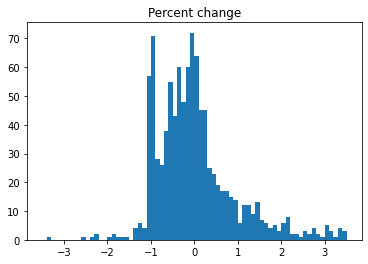

In [88]:
plt.hist((scamRain.sel(case='clasp+MF').values - scamRain.sel(case='clubbMF').values)/scamRain.sel(case='clubbMF').values, 
         np.arange(-3.5, 3.6, 0.1)
        )
plt.title('Percent change')
plt.show()

Text(0, 0.5, 'Difference [mm/hr]')

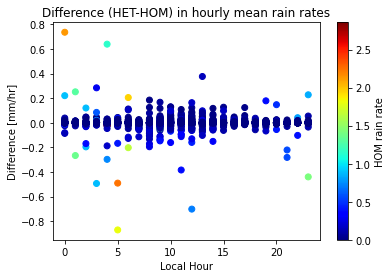

In [92]:
pctChange = (scamRain.sel(case='clasp+MF').values - scamRain.sel(case='clubbMF').values)/scamRain.sel(case='clubbMF').values
diff = (scamRain.sel(case='clasp+MF').values - scamRain.sel(case='clubbMF').values)
hours = scamRain.sel(case='clubbMF')['time.hour'].values

plt.scatter(hours, diff, c=scamRain.sel(case='clubbMF').values, cmap='jet')
plt.colorbar(label='HOM rain rate')
plt.title('Difference (HET-HOM) in hourly mean rain rates')
plt.xlabel('Local Hour')
plt.ylabel('Difference [mm/hr]')



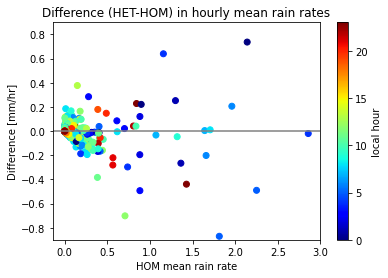

In [95]:
pctChange = (scamRain.sel(case='clasp+MF').values - scamRain.sel(case='clubbMF').values)/scamRain.sel(case='clubbMF').values
diff  = (scamRain.sel(case='clasp+MF').values - scamRain.sel(case='clubbMF').values)
hours = scamRain.sel(case='clubbMF')['time.hour'].values

plt.scatter(scamRain.sel(case='clubbMF').values, diff, c=hours, cmap='jet')
plt.colorbar(label='local hour')
plt.title('Difference (HET-HOM) in hourly mean rain rates')
plt.xlabel('HOM mean rain rate')
plt.ylabel('Difference [mm/hr]')
plt.ylim([-0.9, 0.9])
plt.axhline(0,color='grey')



In [ ]:
## What are the days where CLASP rain falls into bin 1e-4 to 1e-1

Text(0.5, 1.0, 'Hourly mean PRECT')

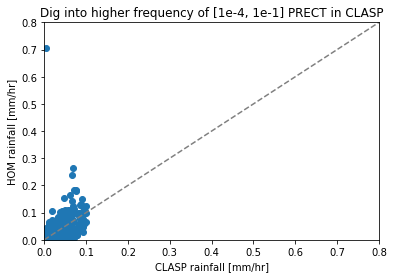

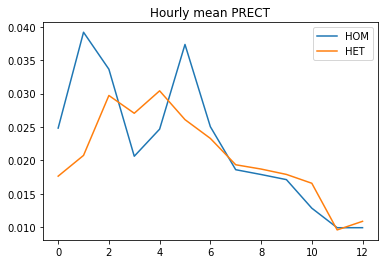

In [151]:
iMatch = np.where((scamRain.sel(case='clasp+MF').values>=1e-4) & 
                  (scamRain.sel(case='clasp+MF').values<=1e-1))[0]

matchDS = scamRain.isel(time=iMatch)

plt.scatter(matchDS.sel(case='clasp+MF'), matchDS.sel(case='clubbMF'))
plt.xlim([0,0.8])
plt.ylim([0,0.8])
plt.plot(np.arange(0,0.85,0.05),np.arange(0,0.85,0.05),'--',color='grey' )
plt.xlabel('CLASP rainfall [mm/hr]')
plt.ylabel('HOM rainfall [mm/hr]')
plt.title('Dig into higher frequency of [1e-4, 1e-1] PRECT in CLASP')

fig,axs = plt.subplots(1,1)
axs.plot(matchDS.groupby('time.hour').mean(dim='time').sel(case='clubbMF'))
axs.plot(matchDS.groupby('time.hour').mean(dim='time').sel(case='clasp+MF'))
axs.legend(['HOM','HET'])
axs.set_title('Hourly mean PRECT')


(array([48., 44., 47., 42., 46., 48., 51., 45., 52., 51., 45., 81.]),
 array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
 <BarContainer object of 12 artists>)

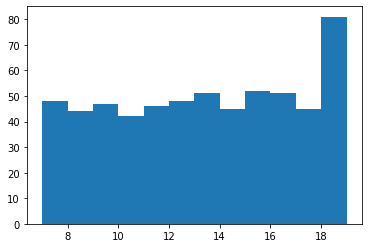

In [163]:
plt.hist(matchDS['time.hour'].values, bins=np.arange(7,20,1))

In [206]:
# All the data for when CLASP prect falls into the bin of interest 

scamDS['total_wp2']   = (('case','time','levInterp'),   scamDS_h2['total_wp2'].values)
scamDS['total_thlp2'] = (('case','time','levInterp'), scamDS_h2['total_thlp2'].values)
scamDS['total_rtp2']  = (('case','time','levInterp'),  scamDS_h2['total_rtp2'].values)
scamDS['total_wpthlp']= (('case','time','levInterp'), scamDS_h2['total_wpthlp'].values)
scamDS['total_wprtp'] = (('case','time','levInterp'),  scamDS_h2['total_wprtp'].values)


In [209]:
fullDS_match    = scamDS.resample(time='1H').mean().dropna(dim='time').isel(time=iMatch)
hrMean_match    = fullDS_match.groupby('time.hour').mean(dim='time')


In [246]:

keepTimes = []

for iTime in range(len(iMatch)):
    iSameH2 = np.where( (scamDS_h2['time.year'].values  == matchDS['time.year'].values[iTime]) & 
                        (scamDS_h2['time.month'].values == matchDS['time.month'].values[iTime]) & 
                        (scamDS_h2['time.day'].values  == matchDS['time.day'].values[iTime]) & 
                        (scamDS_h2['time.hour'].values == matchDS['time.hour'].values[iTime]) )[0]
    
    keepTimes = np.append(keepTimes, iSameH2)
    
hrMean_h2_match  = scamDS_h2.isel(time=keepTimes.astype(int)).groupby('time.hour').mean(dim='time')


Text(0.5, 1.0, 'HET-HOM')

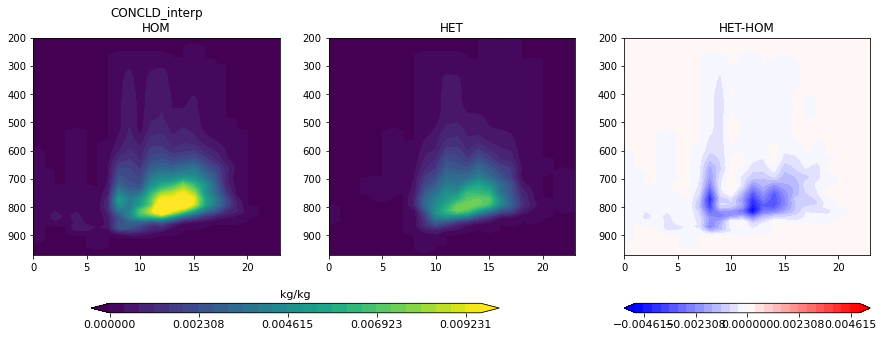

In [201]:
fig,axs = plt.subplots(1,3, figsize=(15,4))
axs     = axs.ravel()

# varPlot = 'CLDLIQ_interp'
# maxCval = 3e-5
# diffMax = 1e-5

# varPlot = 'CLOUD_interp'
# maxCval = 0.4
# diffMax = 0.1

# varPlot = 'CONCLD_interp'
# maxCval = 0.01
# diffMax = 0.005

varPlot = 'CONCLD_interp'
maxCval = 0.01
diffMax = 0.005

axs[0].contourf(hrMean_match.hour.values, hrMean_match.levInterp.values,
                hrMean_match.sel(case='clubbMF')[varPlot].values.transpose(), 
                np.arange(0, maxCval, maxCval/26), extend='both')

cplt = axs[1].contourf(hrMean_match.hour.values, hrMean_match.levInterp.values,
                hrMean_match.sel(case='clasp+MF')[varPlot].values.transpose(), 
                np.arange(0, maxCval, maxCval/26), extend='both')
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.22, ax_position.y0-0.2, ax_position.width+0.15, 0.033])
cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
cbar.ax.locator_params(nbins=6)
cbar.ax.set_title('kg/kg', fontsize=11)
cbar.ax.tick_params(labelsize=11) 

cplt = axs[2].contourf(hrMean_match.hour.values, hrMean_match.levInterp.values,
                (hrMean_match.sel(case='clasp+MF')[varPlot].values-hrMean_match.sel(case='clubbMF')[varPlot].values).transpose(), 
                np.arange(-diffMax, diffMax+(diffMax*2)/26, (diffMax*2)/26), cmap='bwr', extend='both')
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.033])
cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
cbar.ax.locator_params(nbins=6)
cbar.ax.tick_params(labelsize=11) 

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()

axs[0].set_title(varPlot+'\nHOM')
axs[1].set_title('HET')
axs[2].set_title('HET-HOM')


Text(0.5, 1.0, 'HET-HOM')

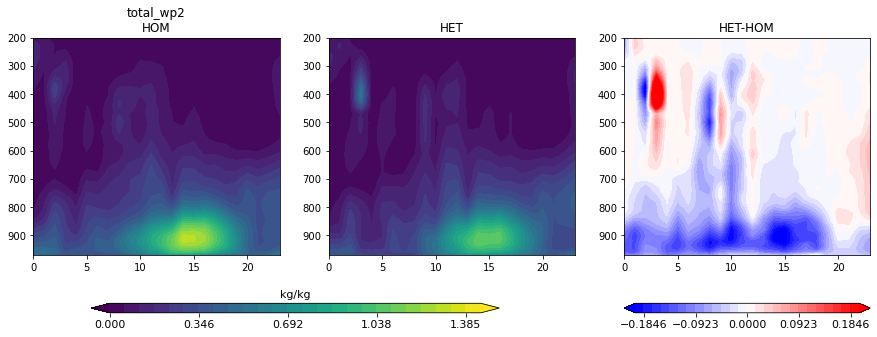

In [225]:
fig,axs = plt.subplots(1,3, figsize=(15,4))
axs     = axs.ravel()

# varPlot = 'total_wprtp'
# minCval = -2e-7
# maxCval = 2.3e-4
# diffMax = 3.5e-5

# varPlot = 'total_wpthlp'
# minCval = -1e-1
# maxCval = 0.2
# diffMax = 0.08

varPlot = 'total_wp2'
minCval = 0
maxCval = 1.5
diffMax = 0.2

axs[0].contourf(hrMean_match.hour.values, hrMean_match.levInterp.values,
                hrMean_match.sel(case='clubbMF')[varPlot].values.transpose(), 
                np.arange(minCval, maxCval, maxCval/26), extend='both')

cplt = axs[1].contourf(hrMean_match.hour.values, hrMean_match.levInterp.values,
                hrMean_match.sel(case='clasp+MF')[varPlot].values.transpose(), 
                np.arange(minCval, maxCval, maxCval/26), extend='both')
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.22, ax_position.y0-0.2, ax_position.width+0.15, 0.033])
cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
cbar.ax.locator_params(nbins=6)
cbar.ax.set_title('kg/kg', fontsize=11)
cbar.ax.tick_params(labelsize=11) 

cplt = axs[2].contourf(hrMean_match.hour.values, hrMean_match.levInterp.values,
                (hrMean_match.sel(case='clasp+MF')[varPlot].values-hrMean_match.sel(case='clubbMF')[varPlot].values).transpose(), 
                np.arange(-diffMax, diffMax+(diffMax*2)/26, (diffMax*2)/26), cmap='bwr', extend='both')
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.033])
cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
cbar.ax.locator_params(nbins=6)
cbar.ax.tick_params(labelsize=11) 

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()

axs[0].set_title(varPlot+'\nHOM')
axs[1].set_title('HET')
axs[2].set_title('HET-HOM')


In [282]:
fig,axs = plt.subplots(1,3, figsize=(15,4))
axs     = axs.ravel()

# varPlot = 'up_macmicAvg_interp'
# minCval = 0
# maxCval = 4.5
# diffMax = 1.0

# varPlot = 'qtu_macmicAvg_interp'
# minCval = 0
# maxCval = 0.016
# diffMax = 0.002

# varPlot = 'thlu_macmicAvg_interp'
# minCval = 290
# maxCval = 310
# diffMax = 20

# varPlot = 'edmf_precc'
# minCval = 0
# maxCval = 2e-4
# diffMax = 1e-5

axs[0].contourf(hrMean_h2_match.hour.values, hrMean_h2_match.levInterp.values,
                hrMean_h2_match.sel(case='clubbMF')[varPlot].mean(dim='nens').values.transpose(), 
                np.arange(minCval, maxCval, (maxCval-minCval)/26), extend='both')

cplt = axs[1].contourf(hrMean_h2_match.hour.values, hrMean_h2_match.levInterp.values,
                hrMean_h2_match.sel(case='clasp+MF')[varPlot].mean(dim='nens').values.transpose(), 
                np.arange(minCval, maxCval, (maxCval-minCval)/26), extend='both')
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.22, ax_position.y0-0.2, ax_position.width+0.15, 0.033])
cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
cbar.ax.locator_params(nbins=6)
cbar.ax.set_title('kg/kg', fontsize=11)
cbar.ax.tick_params(labelsize=11) 

cplt = axs[2].contourf(hrMean_h2_match.hour.values, hrMean_h2_match.levInterp.values,
                (hrMean_h2_match.sel(case='clasp+MF')[varPlot].mean(dim='nens').values-hrMean_h2_match.sel(case='clubbMF')[varPlot].mean(dim='nens').values).transpose(), 
                np.arange(-diffMax, diffMax+(diffMax*2)/26, (diffMax*2)/26), cmap='bwr', extend='both')
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.033])
cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
cbar.ax.locator_params(nbins=6)
cbar.ax.tick_params(labelsize=11) 

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()

axs[0].set_title(varPlot+'\nHOM')
axs[1].set_title('HET')
axs[2].set_title('HET-HOM')


TypeError: Length of y (78) must match number of rows in z (59)

In [283]:
np.mean(hrMean_h2_match.edmf_precc_interp.values)

AttributeError: 'Dataset' object has no attribute 'edmf_precc_interp'

Fraction of days with >= 0.200000 mm/hr of rain: 0.716216
Actual number of days = 53 



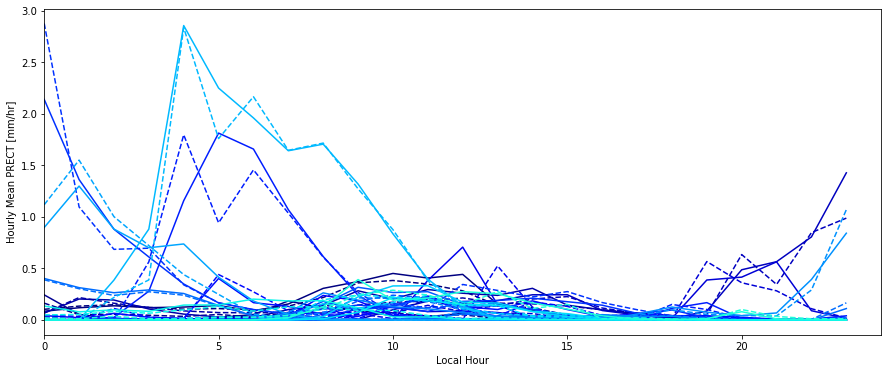

In [115]:
DayMaxRain = scamRain.resample(time='1D').max().dropna(dim='time')

# Updated to look at smaller rain days...
rain_cutoff     = 0.2 ## Threshold for where consider it a decent 'rain' event or not 
iRaining = np.where((DayMaxRain.sel(case='clasp+MF')<=rain_cutoff) & 
                    (DayMaxRain.sel(case='clasp+MF')>10e-4))[0]
print('Fraction of days with >= %f mm/hr of rain: %f' % (rain_cutoff, len(iRaining)/len(DayMaxRain.sel(case='clubbMF').values)))
print('Actual number of days = %i \n' % (len(iRaining)))

## Now get that DS...
iCount = 0 # Number of days saved 
keepTimes = []

fig,axs = plt.subplots(1,1, figsize=(15,6))
n = len(iRaining)
colors = plt.cm.jet(np.linspace(0,1,n))

for iDay in range(len(DayMaxRain.sel(case='clubbMF').time.values)):
    
    if DayMaxRain.sel(case='clubbMF')[iDay]>=rain_cutoff:
    
        iTimes = np.where( (scamDS['time.year'].values == DayMaxRain['time.year'].values[iDay]) & 
                           (scamDS['time.month'].values == DayMaxRain['time.month'].values[iDay]) &  
                           (scamDS['time.day'].values == DayMaxRain['time.day'].values[iDay]) )[0]
        
        dayRain   = scamDS.isel(time=iTimes.astype(int)).PRECT.resample(time='1H').mean().dropna(dim='time')*(3600*1e3)
        keepTimes = np.append(keepTimes, iTimes)

        axs.plot(dayRain.sel(case='clubbMF').values, color=colors[iCount])
        axs.plot(dayRain.sel(case='clasp+MF').values,'--', color=colors[iCount])
        axs.set_xlim([0,24])
#         axs.set_ylim([0,1.0])
        axs.set_xlabel('Local Hour')
        axs.set_ylabel('Hourly Mean PRECT [mm/hr]')
        
        iCount = iCount+1

#     else:
#         print('Skipping day %12s, max rainfall = %.2f mm/hr' % 
#               (DayMaxRain.sel(case='clubbMF')['time'].values[iDay].astype(str), 
#                DayMaxRain.sel(case='clubbMF').values[iDay]))


In [116]:
scamDS_rainDays   =  scamDS.isel(time=keepTimes.astype(int))
scamRain_rainDays = scamDS_rainDays.PRECT.resample(time='1H').mean().dropna(dim='time')*(3600*1e3) ## Convert units to mm/hr,


In [117]:
fig,axs = plt.subplots(1,1, figsize=(6,4))

axs.plot(scamRain_rainDays.sel(case='clubbMF').values, 
         scamRain_rainDays.sel(case='clasp+MF').values,'o')

axs.plot(np.arange(-0.2,3.1,0.1), 
         np.arange(-0.2,3.1,0.1), '--', color='grey')

axs.set_xlim([-0.1,3])
axs.set_ylim([-0.1,3])

axs.set_xlabel('clubbMF hourly rainfall')
axs.set_ylabel('claspMF hourly rainfall')


Text(0, 0.5, 'claspMF hourly rainfall')

### Grab a few samples to look at individual days

In [137]:
scamDS_h2.up_macmicAvg_interp.isel(levInterp=-6,time=90).mean(dim='nens')

<xarray.DataArray 'up_macmicAvg_interp' (case: 2)>
array([1.32019647, 1.37125126])
Coordinates:
    time       datetime64[ns] 2015-06-06T14:33:30
    levInterp  float64 920.0
  * case       (case) object 'clubbMF' 'clasp+MF'

In [107]:
np.nanmean(scamDS_h2.up_macmicAvg_interp.isel(case=0,levInterp=-6,time=14).values)

0.5251816808650073

In [78]:
edmf_grass = scamDS_h2.isel(nens=[0,1,2]).mean(dim='nens')
edmf_crop  = scamDS_h2.isel(nens=[3,4,5]).mean(dim='nens')
edmf_urban = scamDS_h2.isel(nens=[6]).mean(dim='nens')
edmf_lake  = scamDS_h2.isel(nens=[7,8,9]).mean(dim='nens')


In [133]:
def plotByTile(fullDS,                      ## Contains ens-mean for HOM/HET cases 
               tile1, tile2, tile3, tile4,  ## Tile DS 
               pltVar, mult, unitStr,       ## Variable to plot, any multiplier needed, string with units 
               cMin, cMax, diffMax,         ## Colorbar ranges 
               maxLev,                      ## Max height plotted 
               str1, str2, str3, str4):     ## Strings identifying each patch/tile
    
    fig,axs = plt.subplots(3,3,figsize=(20,10))
    axs     = axs.ravel()
    
    ## Plot control cases 
    cplt = axs[0].contourf(fullDS['time.hour'].values, fullDS.levInterp.values,
                     np.squeeze(fullDS[pltVar].sel(case='clubbMF').values.transpose()*mult), 
                     np.arange(cMin, cMax, (cMax-cMin)/26), 
                     cmap='Spectral_r', extend='both')
    cplt = axs[3].contourf(fullDS['time.hour'].values, fullDS.levInterp.values,
                     np.squeeze(fullDS[pltVar].sel(case='clasp+MF').values.transpose()*mult), 
                     np.arange(cMin, cMax, (cMax-cMin)/26), 
                     cmap='Spectral_r', extend='both')
    
    ## Plot difference case
    diffVals = fullDS[pltVar].sel(case='clasp+MF').values - fullDS[pltVar].sel(case='clubbMF').values
    cplt = axs[6].contourf(fullDS['time.hour'].values, fullDS.levInterp.values,
                     np.squeeze(diffVals.transpose()*mult), 
                     np.arange(-diffMax, diffMax, (2*diffMax)/26), 
                     cmap='bwr', extend='both')
    cbar = fig.colorbar(cplt, ax=axs[6])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 

    ## Plot tiles (HET case only)
    cplt = axs[4].contourf(tile1['time.hour'].values, tile1.levInterp.values,
                     np.squeeze(tile1[pltVar].sel(case='clasp+MF').values.transpose()*mult), 
                     np.arange(cMin, cMax, (cMax-cMin)/26), 
                     cmap='Spectral_r', extend='both')
    cplt = axs[5].contourf(tile2['time.hour'].values, tile2.levInterp.values,
                     np.squeeze(tile2[pltVar].sel(case='clasp+MF').values.transpose()*mult), 
                     np.arange(cMin, cMax, (cMax-cMin)/26), 
                     cmap='Spectral_r', extend='both')
    
    cplt = axs[7].contourf(tile3['time.hour'].values, tile3.levInterp.values,
                     np.squeeze(tile3[pltVar].sel(case='clasp+MF').values.transpose()*mult), 
                     np.arange(cMin, cMax, (cMax-cMin)/26), 
                     cmap='Spectral_r', extend='both')
        
    cplt = axs[8].contourf(tile4['time.hour'].values, tile4.levInterp.values,
                     np.squeeze(tile4[pltVar].sel(case='clasp+MF').values.transpose()*mult), 
                     np.arange(cMin, cMax, (cMax-cMin)/26), 
                     cmap='Spectral_r', extend='both')
    
    cbar = fig.colorbar(cplt, ax=axs[8])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(unitStr, fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
#     axs[2].set_title(fullDS.time.values[0].astype(str)[0:10], fontsize=12)

    axs[0].text(26, maxLev*1.2, fullDS.time.values[0].astype(str)[0:10], fontsize=16)
    axs[0].text(26, maxLev*1.3, pltVar, fontsize=16)

    axs[0].set_title('HOM (clubbMF)')
    axs[3].set_title('HET (clasp+MF)')
    axs[6].set_title('HET - HOM')
    axs[4].set_title(str1)
    axs[5].set_title(str2)
    axs[7].set_title(str3)
    axs[7].set_title(str4)
    
    axs[0].invert_yaxis()
    axs[3].invert_yaxis()
    axs[4].invert_yaxis()
    axs[5].invert_yaxis()
    axs[6].invert_yaxis()
    axs[7].invert_yaxis()
    axs[8].invert_yaxis()

    axs[0].set_ylim([975,maxLev])
    axs[3].set_ylim([975,maxLev])
    axs[4].set_ylim([975,maxLev])
    axs[5].set_ylim([975,maxLev])
    axs[6].set_ylim([975,maxLev])
    axs[7].set_ylim([975,maxLev])
    axs[8].set_ylim([975,maxLev])

    fig.delaxes(axs[1])
    fig.delaxes(axs[2])
    
    return 

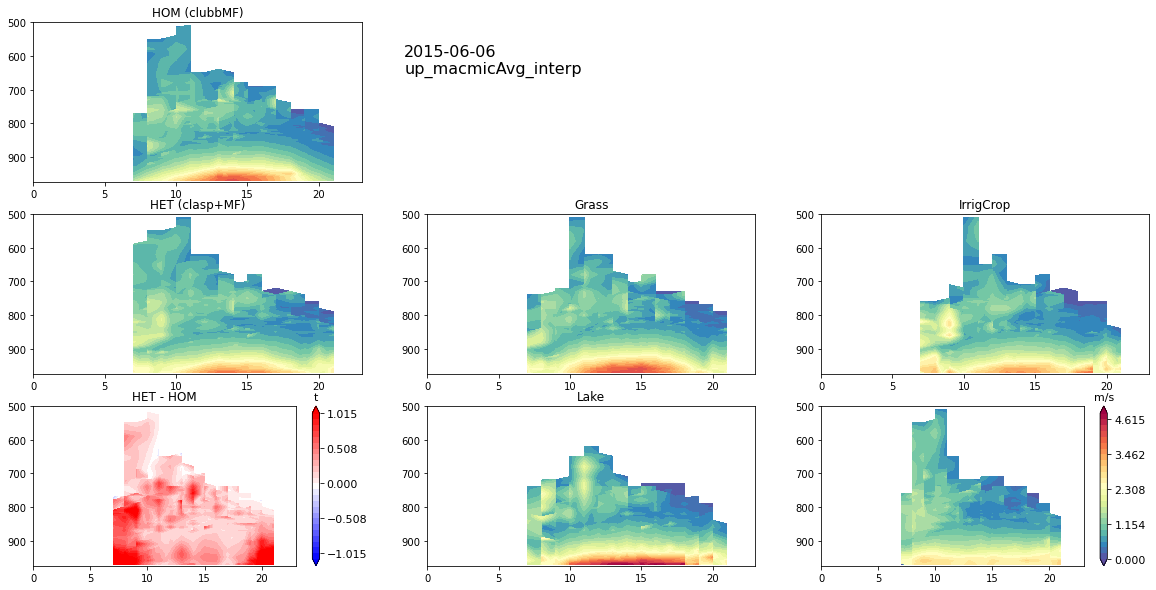

In [139]:
plotByTile(scamDS_h2.resample(time='1H').mean(dim='time').mean(dim='nens'), 
           edmf_grass.resample(time='1H').mean(dim='time'), 
           edmf_crop.resample(time='1H').mean(dim='time'), 
           edmf_urban.resample(time='1H').mean(dim='time'), 
           edmf_lake.resample(time='1H').mean(dim='time'),  ## Tile DS 
           'up_macmicAvg_interp', 1, 'm/s',       ## Variable to plot, any multiplier needed, string with units 
           0, 5, 1.1,         ## Colorbar ranges 
           500,
           'Grass', 'IrrigCrop', 'Urban', 'Lake')


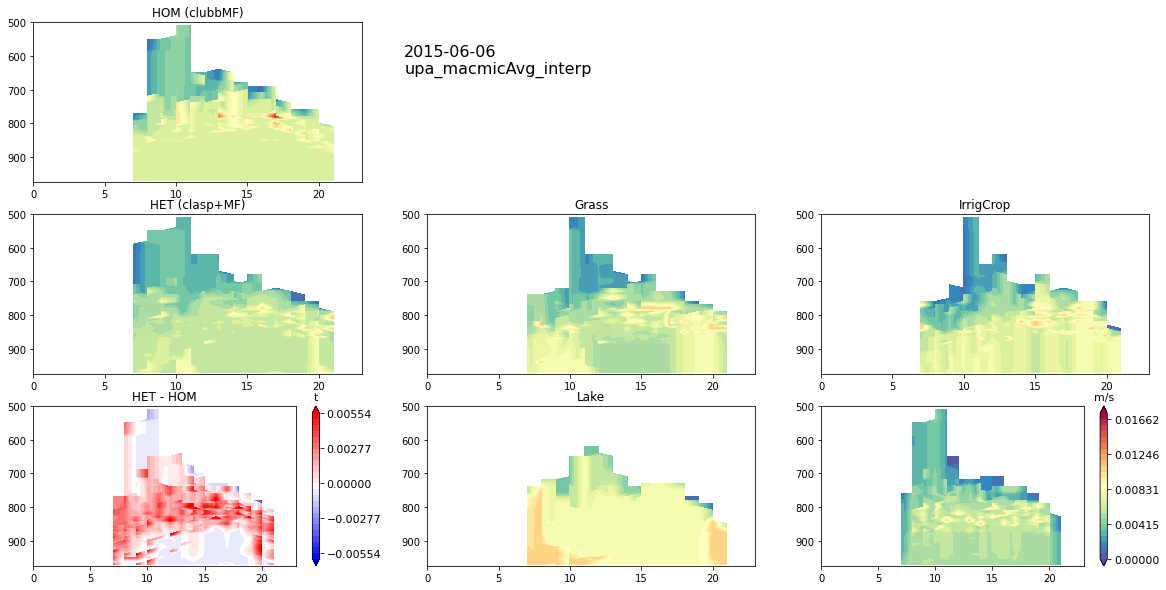

In [143]:
plotByTile(scamDS_h2.resample(time='1H').mean(dim='time').mean(dim='nens'), 
           edmf_grass.resample(time='1H').mean(dim='time'), 
           edmf_crop.resample(time='1H').mean(dim='time'), 
           edmf_urban.resample(time='1H').mean(dim='time'), 
           edmf_lake.resample(time='1H').mean(dim='time'),  ## Tile DS 
           'upa_macmicAvg_interp', 1, 'm/s',       ## Variable to plot, any multiplier needed, string with units 
           0, 0.018, 0.006,         ## Colorbar ranges 
           500,
           'Grass', 'IrrigCrop', 'Urban', 'Lake')


Selecting 10 days to look at


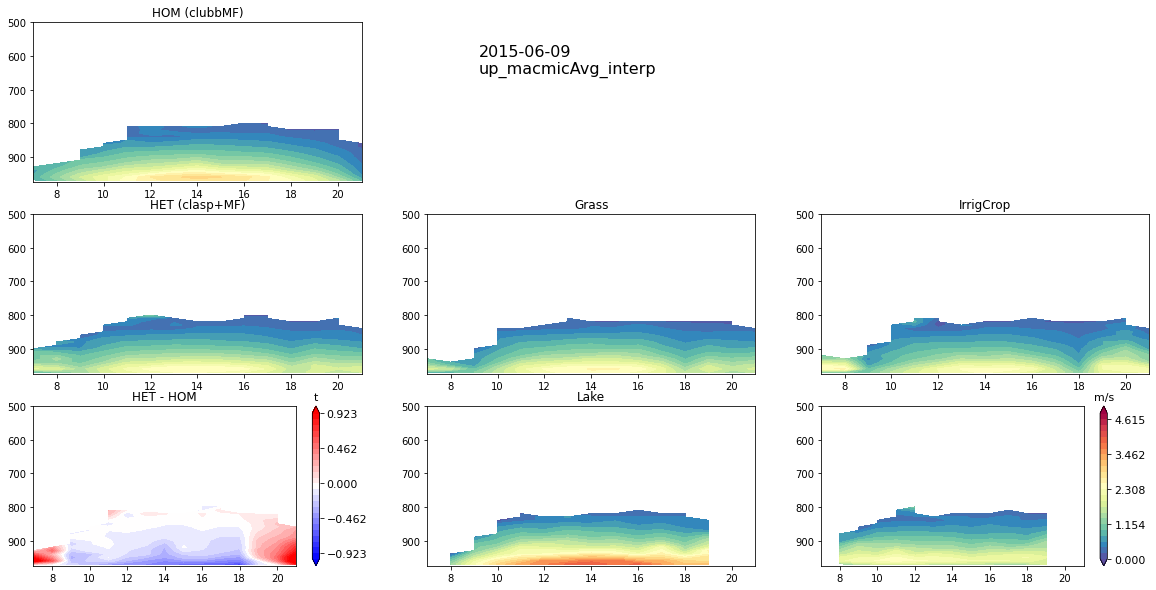

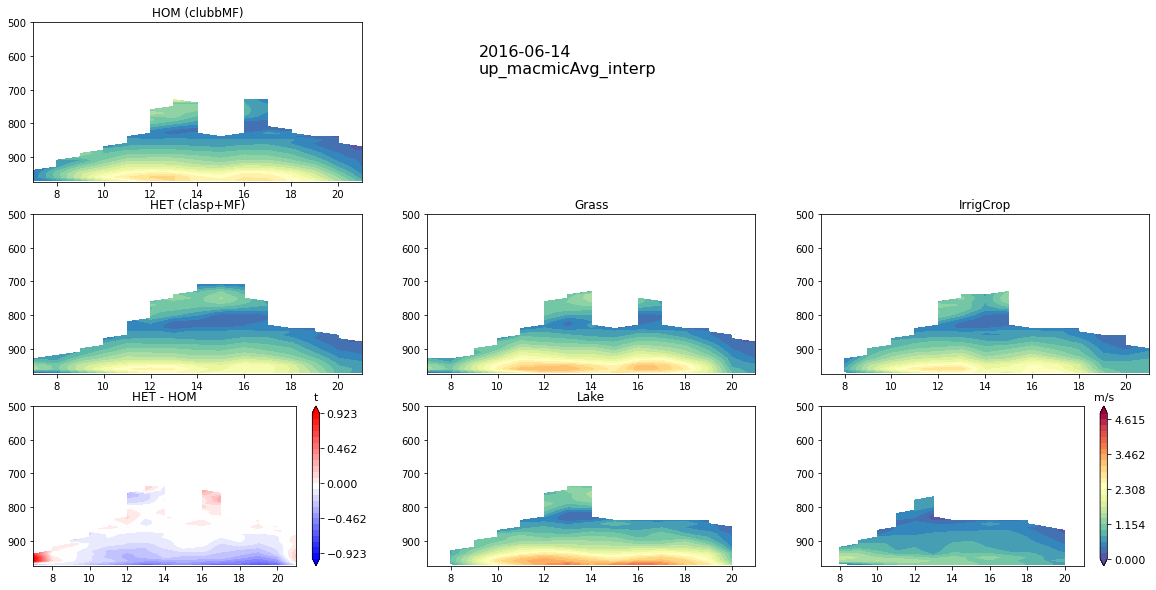

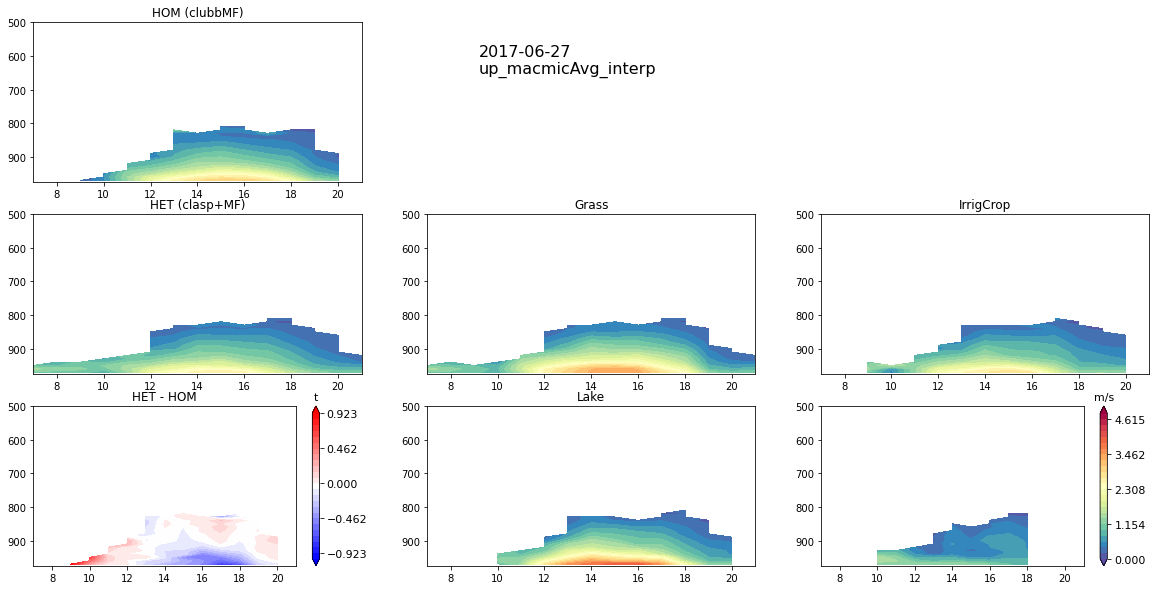

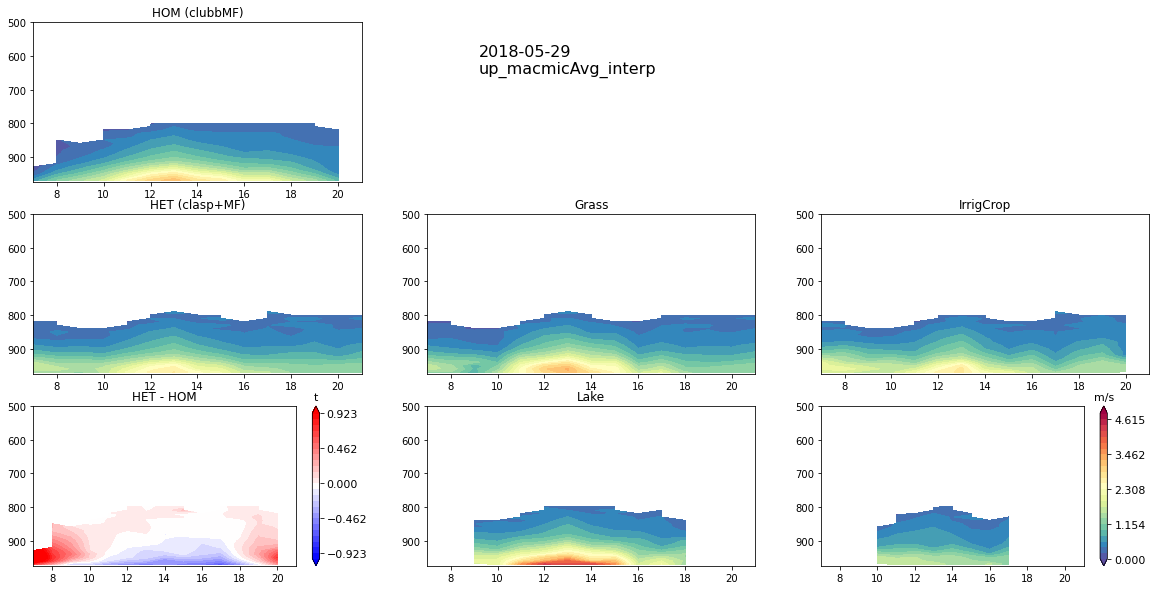

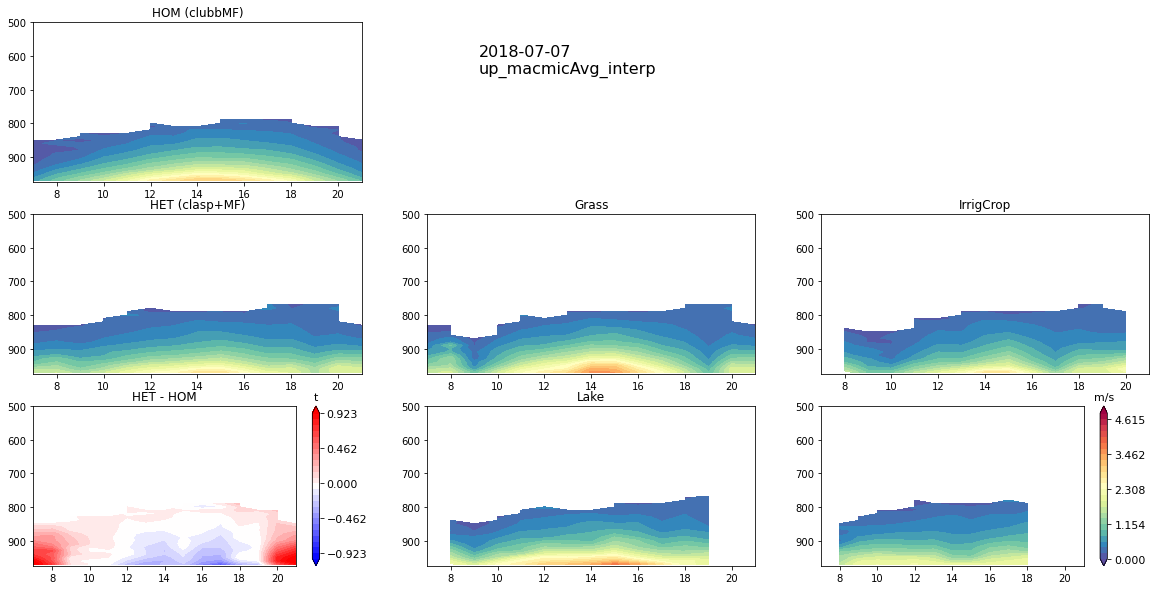

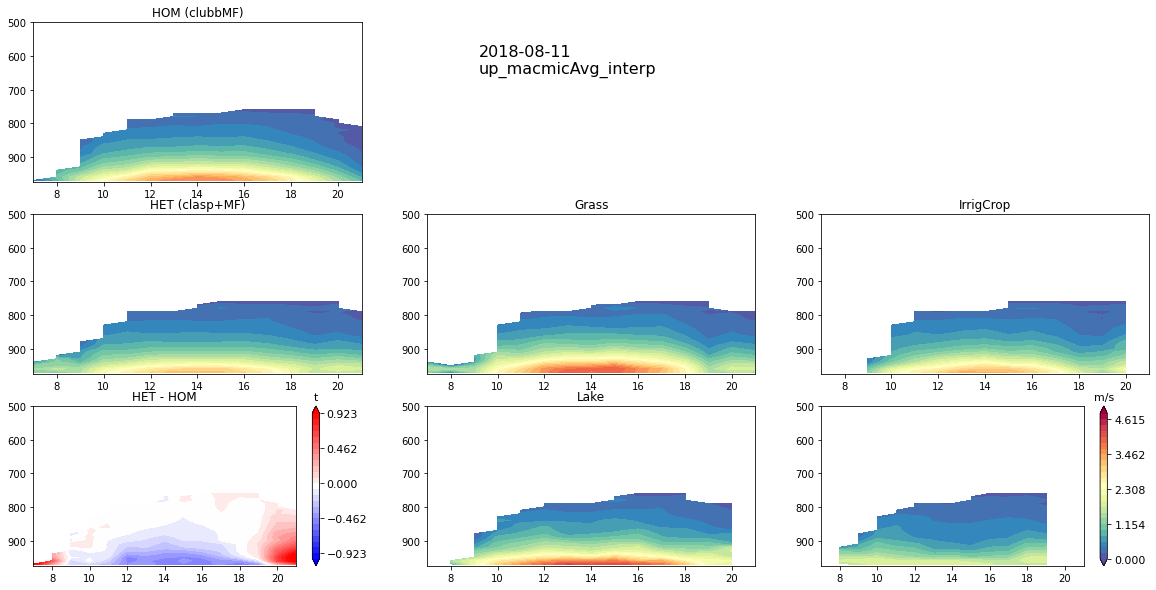

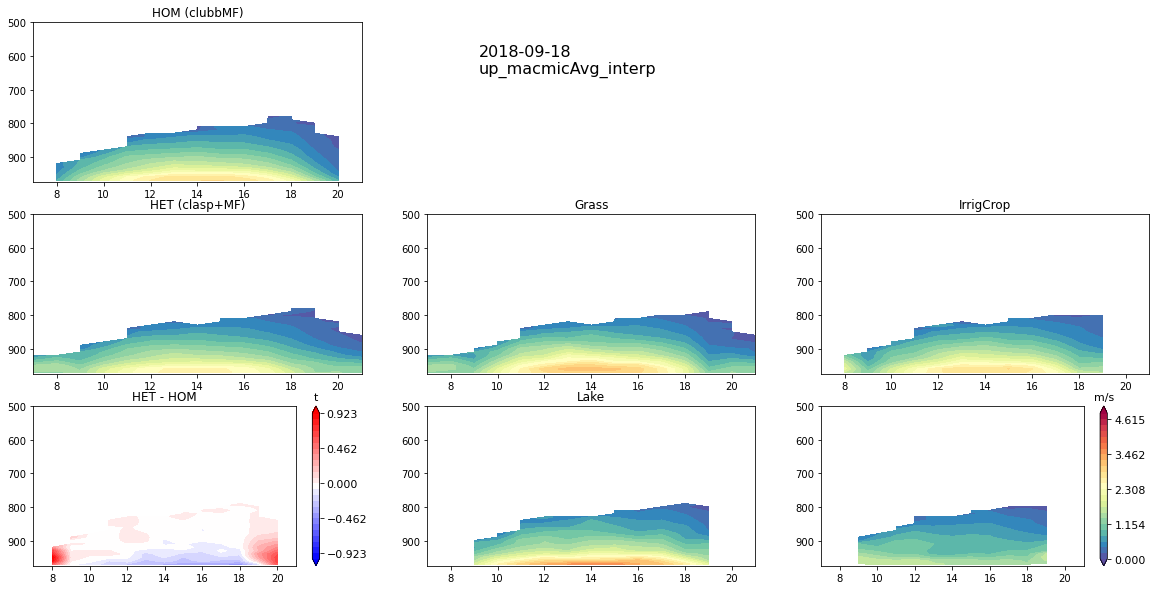

In [134]:
test = scamDS['time'].resample(time='1D').mean().dropna(dim='time')

nDays = len(test.time.values)
iDays = np.arange(1,nDays,8)
print('Selecting %i days to look at' % len(iDays))

selYears  = test['time.year'].values[iDays]
selMonths = test['time.month'].values[iDays]
selDays   = test['time.day'].values[iDays]

iTimesKeep = []

for iD in range(len(iDays)):
    iT = np.where((scamDS['time.year'].values==selYears[iD]) & 
                  (scamDS['time.month'].values==selMonths[iD]) & 
                  (scamDS['time.day'].values==selDays[iD]) )[0]

    iTimesKeep = np.append(iTimesKeep,iT)
    
    # Or maybe just make a handful of plots now? 
    thisDS    = scamDS.isel(time=iT.astype(int)).resample(time='1H').mean(dim='time')
    thisDS_h2 = scamDS_h2.isel(time=iT.astype(int)).resample(time='1H').mean(dim='time')

    plotByTile(thisDS_h2.mean(dim='nens'), 
               edmf_grass.isel(time=iT.astype(int)).resample(time='1H').mean(dim='time'), 
               edmf_crop.isel(time=iT.astype(int)).resample(time='1H').mean(dim='time'), 
               edmf_urban.isel(time=iT.astype(int)).resample(time='1H').mean(dim='time'), 
               edmf_lake.isel(time=iT.astype(int)).resample(time='1H').mean(dim='time'),  ## Tile DS 
               'up_macmicAvg_interp', 1, 'm/s',       ## Variable to plot, any multiplier needed, string with units 
               0, 5, 1,         ## Colorbar ranges 
               500,
               'Grass', 'IrrigCrop', 'Urban', 'Lake')



Selecting 10 days to look at


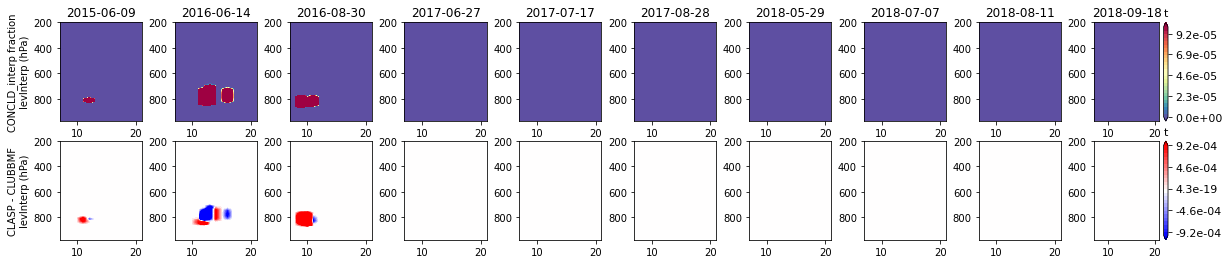

In [75]:
test = scamDS['time'].resample(time='1D').mean().dropna(dim='time')

nDays = len(test.time.values)
iDays = np.arange(1,nDays,8)
print('Selecting %i days to look at' % len(iDays))

selYears  = test['time.year'].values[iDays]
selMonths = test['time.month'].values[iDays]
selDays   = test['time.day'].values[iDays]

iTimesKeep = []


## Plotting options

# plt2d   = True
# pltVar  = 'TMQ'
# units   = scamDS[pltVar].units
# # units   = 'mm/hr'
# # mult    = 1000*3600
# mult = 1
# yMin = 25
# yMax = 55


plt2d   = False
plt3d   = True
h2      = False
maxLev  = 200 

pltVar  = 'CONCLD_interp'
units   = scamDS['CONCLD'].units
mult    = 1
cMin    = 0
cMax    = 0.1e-3
diffMax = 0.1e-2

# pltVar  = 'total_wprtp'
# units   = 'kg/kg m/s'
# mult = 1
# cMin    = -2e-7
# cMax    = 2.5e-4
# diffMax = 1.5e-4

if plt2d==True:
    fig,axs = plt.subplots(1,len(iDays),figsize=(20,2))
    axs     = axs.ravel()
elif plt3d==True:
    fig,axs = plt.subplots(2,len(iDays),figsize=(20,4))
    axs     = axs.ravel()
    
for iD in range(len(iDays)):
    iT = np.where((scamDS['time.year'].values==selYears[iD]) & 
                  (scamDS['time.month'].values==selMonths[iD]) & 
                  (scamDS['time.day'].values==selDays[iD]) )[0]

    iTimesKeep = np.append(iTimesKeep,iT)
    
    # Or maybe just make a handful of plots now? 
    thisDS    = scamDS.isel(time=iT.astype(int)).resample(time='1H').mean(dim='time')
    thisDS_h2 = scamDS_h2.isel(time=iT.astype(int)).resample(time='1H').mean(dim='time')
    
    if plt2d==True: 

        axs[iD].plot(thisDS['time.hour'].values, 
                     np.squeeze(thisDS[pltVar].sel(case='clubbMF').values)*mult, 
                     color='dodgerblue', label='clubb' )
        axs[iD].plot(thisDS['time.hour'].values, 
                     np.squeeze(thisDS[pltVar].sel(case='clasp+MF').values)*mult, 
                     color='orangered', label='clasp' )
        if iD==0:
            axs[iD].legend(bbox_to_anchor=(-0.05, 0.1))
            axs[iD].set_ylabel(pltVar+' '+units)
        axs[iD].set_title(test.time.values[iD].astype(str)[0:10])
        axs[iD].set_ylim([yMin, yMax])
        
    elif plt3d==True:
        if h2==True:
            ## Plot control case 
            cplt = axs[iD].contourf(thisDS_h2['time.hour'].values, thisDS_h2.levInterp.values,
                             np.squeeze(thisDS_h2[pltVar].sel(case='clubbMF').values.transpose()*mult), 
                             np.arange(cMin, cMax, (cMax-cMin)/26), 
                             cmap='Spectral_r', extend='both')
            if iD==len(iDays)-1:
                cbar = fig.colorbar(cplt, ax=axs[iD], format='%.1e')
                cbar.ax.locator_params(nbins=6)
                cbar.ax.set_title(units[iVar], fontsize=11)
                cbar.ax.tick_params(labelsize=11) 
                
            ## Plot difference case
            diffVals = thisDS_h2[pltVar].sel(case='clasp+MF').values - thisDS_h2[pltVar].sel(case='clubbMF').values
            cplt = axs[iD+10].contourf(thisDS_h2['time.hour'].values, thisDS_h2.levInterp.values,
                             np.squeeze(diffVals.transpose()*mult), 
                             np.arange(-diffMax, diffMax, (2*diffMax)/26), 
                             cmap='bwr', extend='both')
            if iD==len(iDays)-1:
                cbar = fig.colorbar(cplt, ax=axs[iD+10], format='%.1e')
                cbar.ax.locator_params(nbins=6)
                cbar.ax.set_title(units[iVar], fontsize=11)
                cbar.ax.tick_params(labelsize=11) 
        
        elif h2==False:
            ## Plot control case 
            cplt = axs[iD].contourf(thisDS['time.hour'].values, thisDS.levInterp.values,
                             np.squeeze(thisDS[pltVar].sel(case='clubbMF').values.transpose()*mult), 
                             np.arange(cMin, cMax, (cMax-cMin)/26), 
                             cmap='Spectral_r', extend='both')
            if iD==len(iDays)-1:
                cbar = fig.colorbar(cplt, ax=axs[iD], format='%.1e')
                cbar.ax.locator_params(nbins=6)
                cbar.ax.set_title(units[iVar], fontsize=11)
                cbar.ax.tick_params(labelsize=11) 
                
            ## Plot difference case
            diffVals = thisDS[pltVar].sel(case='clasp+MF').values - thisDS[pltVar].sel(case='clubbMF').values
            cplt = axs[iD+10].contourf(thisDS['time.hour'].values, thisDS.levInterp.values,
                             np.squeeze(diffVals.transpose()*mult), 
                             np.arange(-diffMax, diffMax, (2*diffMax)/26), 
                             cmap='bwr', extend='both')
            if iD==len(iDays)-1:
                cbar = fig.colorbar(cplt, ax=axs[iD+10], format='%.1e')
                cbar.ax.locator_params(nbins=6)
                cbar.ax.set_title(units[iVar], fontsize=11)
                cbar.ax.tick_params(labelsize=11)            
            
        if iD==0:
            axs[iD].set_ylabel(pltVar+' '+units+'\nlevInterp (hPa)')
            axs[iD+10].set_ylabel('CLASP - CLUBBMF'+'\nlevInterp (hPa)')

        axs[iD].set_title(test.time.values[iDays[iD]].astype(str)[0:10])
        axs[iD].invert_yaxis()
        axs[iD].set_ylim([975,maxLev])

        axs[iD+10].invert_yaxis()
        axs[iD+10].set_ylim([975,maxLev])
            
        
    
fig.subplots_adjust(wspace=0.4)


In [50]:
yrSelList  = [2017,2016,2017]
monSelList = [9,   6,   7]
daySelList = [24,  10,  16]

iselDate1 = np.where( (scamDS['time.year'].values==yrSelList[0]) & 
                      (scamDS['time.month'].values==monSelList[0]) & 
                      (scamDS['time.day'].values==daySelList[0]) )[0]
scamSel1 = scamDS.isel(time=iselDate1).groupby('time.hour').mean(dim='time')


iselDate2 = np.where( (scamDS['time.year'].values==yrSelList[1]) & 
                      (scamDS['time.month'].values==monSelList[1]) & 
                      (scamDS['time.day'].values==daySelList[1]) )[0]
scamSel2 = scamDS.isel(time=iselDate2).groupby('time.hour').mean(dim='time')


iselDate3 = np.where( (scamDS['time.year'].values==yrSelList[2]) & 
                      (scamDS['time.month'].values==monSelList[2]) & 
                      (scamDS['time.day'].values==daySelList[2]) )[0]
scamSel3 = scamDS.isel(time=iselDate3).groupby('time.hour').mean(dim='time')



In [51]:
pltVars = ['SHFLX','LHFLX',
           'TREFHT','QREFHT',
#            'SWCF','LWCF',
           'CLDTOT','PRECT',
           'TGCLDLWP','PBLH',]

ctrlCase  = 'clubbMF'
testCase  = 'clasp+MF'

# ctrlCase2 = 'clubbMF_setSfcFlux'
# testCase2 = 'claspMF_setSfcFlux'

fig,axs = plt.subplots(len(pltVars),3, figsize=(13,4*len(pltVars)))
axs     = axs.ravel()

for iPlt in range(len(pltVars)):

    ## Day 1
    axs[iPlt*3].plot(scamSel1.hour.values, np.squeeze(scamSel1[pltVars[iPlt]].sel(case=ctrlCase).values), 
             'k--', label=ctrlCase)
    axs[iPlt*3].plot(scamSel1.hour.values, np.squeeze(scamSel1[pltVars[iPlt]].sel(case=testCase).values), 
             color='orangered', label=testCase)
#     axs[iPlt*3].plot(scamSel1.hour.values, np.squeeze(scamSel1[pltVars[iPlt]].sel(case=ctrlCase2).values), 
#          color='orangered', linestyle='--', label=ctrlCase2)
#     axs[iPlt*3].plot(scamSel1.hour.values, np.squeeze(scamSel1[pltVars[iPlt]].sel(case=testCase2).values), 
#          color='dodgerblue', linestyle='--', label=testCase2)
    
    ## Day 2
    axs[iPlt*3+1].plot(scamSel2.hour.values, np.squeeze(scamSel2[pltVars[iPlt]].sel(case=ctrlCase).values), 
             'k--', label=ctrlCase)
    axs[iPlt*3+1].plot(scamSel2.hour.values, np.squeeze(scamSel2[pltVars[iPlt]].sel(case=testCase).values), 
             color='orangered', label=testCase)
#     axs[iPlt*3+1].plot(scamSel2.hour.values, np.squeeze(scamSel2[pltVars[iPlt]].sel(case=ctrlCase2).values), 
#          color='orangered', linestyle='--', label=ctrlCase2)
#     axs[iPlt*3+1].plot(scamSel2.hour.values, np.squeeze(scamSel2[pltVars[iPlt]].sel(case=testCase2).values), 
#          color='dodgerblue', linestyle='--', label=testCase2)

    ## Day 3
    axs[iPlt*3+2].plot(scamSel3.hour.values, np.squeeze(scamSel3[pltVars[iPlt]].sel(case=ctrlCase).values), 
             'k--', label=ctrlCase)
    axs[iPlt*3+2].plot(scamSel3.hour.values, np.squeeze(scamSel3[pltVars[iPlt]].sel(case=testCase).values), 
             color='orangered', label=testCase)
#     axs[iPlt*3+2].plot(scamSel3.hour.values, np.squeeze(scamSel3[pltVars[iPlt]].sel(case=ctrlCase2).values), 
#          color='orangered', linestyle='--', label=ctrlCase2)
#     axs[iPlt*3+2].plot(scamSel3.hour.values, np.squeeze(scamSel3[pltVars[iPlt]].sel(case=testCase2).values), 
#          color='dodgerblue', linestyle='--', label=testCase2)
    
    if iPlt==0: 
        axs[iPlt*3].set_title(str(monSelList[0])+'/'+str(daySelList[0])+'/'+str(yrSelList[0])+'\n'+pltVars[iPlt])
        axs[iPlt*3+1].set_title(str(monSelList[1])+'/'+str(daySelList[1])+'/'+str(yrSelList[1])+'\n')
        axs[iPlt*3+2].set_title(str(monSelList[2])+'/'+str(daySelList[2])+'/'+str(yrSelList[2])+'\n')
    else: 
        axs[iPlt*3].set_title(pltVars[iPlt])
        
    axs[iPlt*3].legend()
    
    

Text(0.5, 0, 'Local Hour')

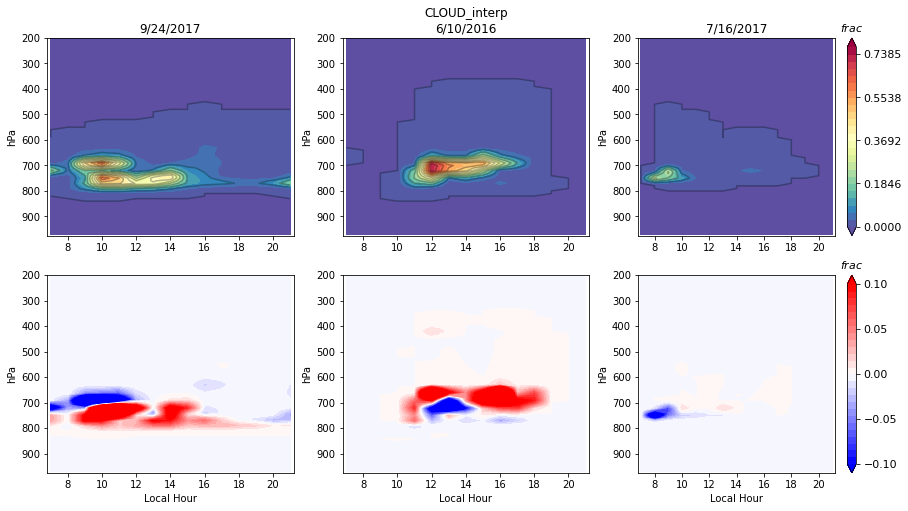

In [52]:
# pltVar  = 'THLP2_CLUBB_interp'
# cMin    = 0.0 
# cMax    = 0.1
# diffMax = 0.01
# multpl  = 1 
# maxLev  = 500 
# unitsStr = r'$K^2$'

# pltVar  = 'RTP2_CLUBB_interp'
# cMin    = 0.0 
# cMax    = 2.0e-7
# diffMax = 0.4e-7
# multpl  = 1e-6 
# maxLev  = 500 
# unitsStr = r'$kg^2/kg^2$'

pltVar  = 'CLOUD_interp'
cMin    = 0.0 
cMax    = 0.8
diffMax = 0.1
multpl  = 1 
maxLev  = 200 
unitsStr = r'$frac$'

fig,axs = plt.subplots(2,3, figsize=(15,8))
axs     = axs.ravel()

# Set up case 
ctrlCase = 'clubbMF'
testCase = 'clasp+MF'

# ctrlCase = 'clubbMF_setSfcFlux'
# testCase = 'claspMF_setSfcFlux'


## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
## Day 1 
## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

ctrlDS    = scamSel1.sel(case=ctrlCase)
testDS    = scamSel1.sel(case=testCase)
diffCases = testDS - ctrlDS
# - - - - Plot control case - - - -
cplt = axs[0].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                   np.squeeze(ctrlDS[pltVar].values * multpl).transpose(),
                   np.arange(cMin, cMax, (cMax-cMin)/26), 
                   cmap='Spectral_r', extend='both')

# Add contour lines
cplt = axs[0].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                np.squeeze(ctrlDS[pltVar].values * multpl).transpose(),
                np.arange(cMin, cMax, (cMax-cMin)/26)[::2], colors='k', alpha=0.3 )

# - - - - Plot difference case - - - -
nStep = (2*diffMax)/26

cplt = axs[3].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                np.squeeze(diffCases[pltVar].values* multpl).transpose(),
                np.arange(-diffMax, diffMax+nStep, nStep), cmap='bwr', extend='both')

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
## Day 2
## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

ctrlDS    = scamSel2.sel(case=ctrlCase)
testDS    = scamSel2.sel(case=testCase)
diffCases = testDS - ctrlDS
# - - - - Plot control case - - - -
cplt = axs[1].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                   np.squeeze(ctrlDS[pltVar].values * multpl).transpose(),
                   np.arange(cMin, cMax, (cMax-cMin)/26), 
                   cmap='Spectral_r', extend='both')

# Add contour lines
cplt = axs[1].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                np.squeeze(ctrlDS[pltVar].values * multpl).transpose(),
                np.arange(cMin, cMax, (cMax-cMin)/26)[::2], colors='k', alpha=0.3 )


# - - - - Plot difference case - - - -
nStep = (2*diffMax)/26

cplt = axs[4].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                np.squeeze(diffCases[pltVar].values* multpl).transpose(),
                np.arange(-diffMax, diffMax+nStep, nStep), cmap='bwr', extend='both')

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
## Day 3 
## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

ctrlDS    = scamSel3.sel(case=ctrlCase)
testDS    = scamSel3.sel(case=testCase)
diffCases = testDS - ctrlDS

# - - - - Plot control case - - - -
cplt = axs[2].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                   np.squeeze(ctrlDS[pltVar].values * multpl).transpose(),
                   np.arange(cMin, cMax, (cMax-cMin)/26), 
                   cmap='Spectral_r', extend='both')
# Add colorbar
if (pltVar=='RTPTHLP_CLUBB_interp'):
        cbar = fig.colorbar(cplt, ax=axs[2],ticks=[cMin, cMin/2, 0, cMax/2, cMax])
else: 
    cbar = fig.colorbar(cplt, ax=axs[2])
    cbar.ax.locator_params(nbins=6)
cbar.ax.set_title(unitsStr, fontsize=11)
cbar.ax.tick_params(labelsize=11) 


# Add contour lines
cplt = axs[2].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                np.squeeze(ctrlDS[pltVar].values * multpl).transpose(),
                np.arange(cMin, cMax, (cMax-cMin)/26)[::2], colors='k', alpha=0.3 )


# - - - - Plot difference case - - - -
nStep = (2*diffMax)/26

cplt = axs[5].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                np.squeeze(diffCases[pltVar].values* multpl).transpose(),
                np.arange(-diffMax, diffMax+nStep, nStep), cmap='bwr', extend='both')

cbar = fig.colorbar(cplt, ax=axs[5],ticks=[-diffMax, -diffMax/2, 0, diffMax/2, diffMax])
cbar.ax.locator_params(nbins=6)
cbar.ax.set_title(unitsStr, fontsize=11)
cbar.ax.tick_params(labelsize=11) 

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
## Other plot options 
## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

axs[0].set_title('\n'+str(monSelList[0])+'/'+str(daySelList[0])+'/'+str(yrSelList[0]))
axs[1].set_title(pltVar+'\n'+str(monSelList[1])+'/'+str(daySelList[1])+'/'+str(yrSelList[1]))
axs[2].set_title('\n'+str(monSelList[2])+'/'+str(daySelList[2])+'/'+str(yrSelList[2]))

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()


axs[0].set_ylim([975, maxLev])
axs[1].set_ylim([975, maxLev])
axs[2].set_ylim([975, maxLev])
axs[3].set_ylim([975, maxLev])
axs[4].set_ylim([975, maxLev])
axs[5].set_ylim([975, maxLev])

axs[0].set_ylabel('hPa')
axs[1].set_ylabel('hPa')
axs[2].set_ylabel('hPa')
axs[3].set_ylabel('hPa')
axs[4].set_ylabel('hPa')
axs[5].set_ylabel('hPa')

axs[0].set_xlim([6.8,21.2])
axs[1].set_xlim([6.8,21.2])
axs[2].set_xlim([6.8,21.2])
axs[3].set_xlim([6.8,21.2])
axs[4].set_xlim([6.8,21.2])
axs[5].set_xlim([6.8,21.2])

axs[0].set_xticks([8,10,12,14,16,18,20])
axs[1].set_xticks([8,10,12,14,16,18,20])
axs[2].set_xticks([8,10,12,14,16,18,20])
axs[3].set_xticks([8,10,12,14,16,18,20])
axs[4].set_xticks([8,10,12,14,16,18,20])
axs[5].set_xticks([8,10,12,14,16,18,20])

axs[3].set_xlabel('Local Hour')
axs[4].set_xlabel('Local Hour')
axs[5].set_xlabel('Local Hour')


## Assess what's happening in the land

## Scratch work

In [69]:
caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_setSfcFlxTRUE_fixEvap.LASSO_20180605.budgetMFvars001'
caseDir = '/project/amp/mdfowler/cases/'
histDir = '/run/atm/hist/'

listFiles_h2 = np.sort(glob.glob(caseDir+caseName+histDir+'*cam.h2*'))

testDS = xr.open_dataset(listFiles_h2[0], decode_times=True)


In [84]:
nens = 10
fig,axs = plt.subplots(1,1, figsize=(4,8))

pltVar = 'edmf_upthl'

for iEns in range(nens):
    axs.plot(testDS[pltVar].values[200,iEns,:,0,0], testDS.ilev.values,label=str(iEns+1))
    
axs.invert_yaxis()
axs.legend()
axs.set_title(pltVar+': '+testDS[pltVar].long_name)
axs.set_xlabel(testDS[pltVar].units)
axs.set_ylim([1000,500])


(1000.0, 500.0)

In [70]:
testDS

<xarray.Dataset>
Dimensions:         (ilev: 59, lat: 1, lev: 58, lon: 1, nbnd: 2, nens: 10, time: 865)
Coordinates:
  * lat             (lat) float64 36.6
  * lon             (lon) float64 262.5
  * lev             (lev) float64 3.018 5.445 9.087 14.25 ... 983.2 991.2 997.5
  * ilev            (ilev) float64 2.055 3.98 6.909 11.27 ... 987.4 995.1 1e+03
  * time            (time) object 2018-06-05 05:01:00 ... 2018-06-08 05:01:00
Dimensions without coordinates: nbnd, nens
Data variables:
    ntrk            int32 ...
    ntrn            int32 ...
    ntrm            int32 ...
    gw              (lat) float64 ...
    hyam            (lev) float64 ...
    hybm            (lev) float64 ...
    P0              float64 ...
    hyai            (ilev) float64 ...
    hybi            (ilev) float64 ...
    date            (time) int32 ...
    datesec         (time) int32 ...
    time_bnds       (time, nbnd) object ...
    date_written    (time) |S8 ...
    time_written    (time) |S8 ...
    ndbase          int32 ...
    nsbase          int32 ...
    nbdate          int32 ...
    nbsec           int32 ...
    mdt             int32 ...
    ndcur           (time) int32 ...
    nscur           (time) int32 ...
    co2vmr          (time) float64 ...
    ch4vmr          (time) float64 ...
    n2ovmr          (time) float64 ...
    f11vmr          (time) float64 ...
    f12vmr          (time) float64 ...
    sol_tsi         (time) float64 ...
    nsteph          (time) int32 ...
    edmf_DRY_A      (time, ilev, lat, lon) float32 ...
    edmf_DRY_QT     (time, ilev, lat, lon) float32 ...
    edmf_DRY_THL    (time, ilev, lat, lon) float32 ...
    edmf_DRY_W      (time, ilev, lat, lon) float32 ...
    edmf_MOIST_A    (time, ilev, lat, lon) float32 ...
    edmf_MOIST_QC   (time, ilev, lat, lon) float32 ...
    edmf_MOIST_QT   (time, ilev, lat, lon) float32 ...
    edmf_MOIST_THL  (time, ilev, lat, lon) float32 ...
    edmf_MOIST_W    (time, ilev, lat, lon) float32 ...
    edmf_cloudfrac  (time, lev, lat, lon) float32 ...
    edmf_dnqt       (time, nens, ilev, lat, lon) float32 ...
    edmf_dnthl      (time, nens, ilev, lat, lon) float32 ...
    edmf_dnw        (time, nens, ilev, lat, lon) float32 ...
    edmf_precc      (time, ilev, lat, lon) float32 ...
    edmf_qtflxdn    (time, ilev, lat, lon) float32 ...
    edmf_qtflxup    (time, ilev, lat, lon) float32 ...
    edmf_qtforcdn   (time, lev, lat, lon) float32 ...
    edmf_qtforcup   (time, lev, lat, lon) float32 ...
    edmf_rcm        (time, ilev, lat, lon) float32 ...
    edmf_thlflxdn   (time, ilev, lat, lon) float32 ...
    edmf_thlflxup   (time, ilev, lat, lon) float32 ...
    edmf_thlforcdn  (time, lev, lat, lon) float32 ...
    edmf_thlforcup  (time, lev, lat, lon) float32 ...
    edmf_upa        (time, nens, ilev, lat, lon) float32 ...
    edmf_upbuoy     (time, nens, ilev, lat, lon) float32 ...
    edmf_updet      (time, nens, ilev, lat, lon) float32 ...
    edmf_upent      (time, nens, ilev, lat, lon) float32 ...
    edmf_upmf       (time, nens, ilev, lat, lon) float32 ...
    edmf_upqt       (time, nens, ilev, lat, lon) float32 ...
    edmf_upth       (time, nens, ilev, lat, lon) float32 ...
    edmf_upthl      (time, nens, ilev, lat, lon) float32 ...
    edmf_upthv      (time, nens, ilev, lat, lon) float32 ...
    edmf_upw        (time, nens, ilev, lat, lon) float32 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_set...
    logname:           mdfowler
    host:              izumi.cgd.ucar.e
    initial_file:      /project/amp/rneale/scam/ncar_pbl/ncdata/FWsc_T42_58L_...
    topography_file:   /fs/cgd/csm/inputdata/atm/cam/topo/T42_nc3000_Co060_Fi...
    model_doi_url:     not_set
    time_period_freq:  minute_5